# Generating Music with GANs

Team members: Bergamin Eleonora, Campagnola Stefano, Monti Sebastiano

## Prerequisites

### Install dependencies

In [1]:
#!pip3 install -Uqq ipdb
#import ipdb

In [2]:
#%pdb on

In [3]:
#!pip3 install torch matplotlib tqdm livelossplot gdown "pypianoroll>=1.0.2"

### Import libraries

In [1]:
import os
import os.path
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
from pypianoroll import Multitrack, Track, BinaryTrack
from tqdm import tqdm

In [2]:
# built in package
import metrics
from models import *

## Settings

In [3]:
### Data
n_pitches = 84  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_bars = 4  # number of bars per sample
n_tracks = 1  # number of tracks
beat_resolution = 4  # temporal resolution of a beat (in timestep)
tempo = 100 

if n_tracks == 1:
    programs = [0]  # program number for each track
    is_drums = [False]  # drum indicator for each track
    track_names = ['Piano']  # name of each track
else:
    programs = [0, 0, 25, 33, 48]  # program number for each track
    is_drums = [True, False, False, False, False]  # drum indicator for each track
    track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # name of each track    

### Training
latent_dim = 32 # latent noise dimension
batch_size = 64 # if changed, re-run the dataloader

### Random seed
torch.manual_seed(637528)
np.random.seed(637528)

In [4]:
bar_resolution = 4 * beat_resolution # temporal resolution of a bar (4 beats)
tempo_array = np.full((4 * 4 * bar_resolution, 1), tempo) # tempo information for each timestep

## Data Preparation

### Download the Lakh Pianoroll Dataset (LPD)

In [96]:
# uncomment to work in colab
'''
%mkdir data

!gdown -O data/lpd_5_cleansed.tar.gz https://drive.google.com/uc?id=1HGjvb_czQNQGCX73iSa4VUv54iYv5YIL
!gdown -O data/id_lists_amg.tar.gz https://drive.google.com/uc?id=1hp9b_g1hu_dkP4u8h46iqHeWMaUoI07R

!tar zxf data/lpd_5_cleansed.tar.gz -C data/
!tar zxf data/id_lists_amg.tar.gz -C data/
!tar zxf data/midi.tar.gz -C data/
'''

'\n%mkdir data\n\n!gdown -O data/lpd_5_cleansed.tar.gz https://drive.google.com/uc?id=1HGjvb_czQNQGCX73iSa4VUv54iYv5YIL\n!gdown -O data/id_lists_amg.tar.gz https://drive.google.com/uc?id=1hp9b_g1hu_dkP4u8h46iqHeWMaUoI07R\n\n!tar zxf data/lpd_5_cleansed.tar.gz -C data/\n!tar zxf data/id_lists_amg.tar.gz -C data/\n!tar zxf data/midi.tar.gz -C data/\n'

In [5]:
'''
DATASET_TYPE:
- 0: lpd_5_cleansed # 90000 samples
- 1: amg # 30000 samples / 52000
- 2: midi # 70000 samples / 72000
'''

#n_tracks = 1  # number of tracks
DATASET_TYPE = 0
CONDITIONED = True

if CONDITIONED:
    cons_bars = 2  # number of consecutive bars to sample for conditioned generation
else: 
    cons_bars = 1

In [6]:
if DATASET_TYPE == 0:
    # to collect from lpd_5_cleansed
    
    id_list = []
    for path in os.listdir("data/lpd_5/lpd_5_cleansed"):
        folderpath = os.path.join("data/lpd_5/lpd_5_cleansed", path)

        for fold1path in os.listdir(folderpath):
            fold2path = os.path.join(folderpath, fold1path)

            for fold3path in os.listdir(fold2path):
                fold4path =  os.path.join(fold2path, fold3path)

                for code in os.listdir(fold4path):
                    g = os.path.join(fold4path, code)

                    for file in os.listdir(g):
                        f = os.path.join(g, file)
                        id_list.append(f)

    print(len(id_list))

if DATASET_TYPE == 1:
    # to collect data from amg
    
    dataset_root = Path("data/lpd_5/lpd_5_cleansed/")
    id_list = []
    for path in os.listdir("data/amg"):
        filepath = os.path.join("data/amg", path)
        if os.path.isfile(filepath):
            with open(filepath) as f:
                id_list.extend([line.rstrip() for line in f])
    id_list = list(set(id_list))

    print(len(id_list))

if DATASET_TYPE == 2:
    # to collect from midi
    
    id_list = []
    for path in os.listdir("data/midi/midi"):
        filepath = os.path.join("data/midi/midi", path).replace("\\","/") ###The replace function is new to work locally
        id_list.append(filepath)
    print(len(id_list))

21425


In [7]:
print(id_list[393])

data/lpd_5/lpd_5_cleansed\A\L\J\TRALJBT128F4266FD8\a6e3b3e51ee9eff7da08be50619a9cc0.npz


In [ ]:
id_list.remove('data/midi/midi/Pokemon Mystery Dungeon_Multiplatform_Pokemon Mystery Dungeon Red Rescue Team & Pokemon Mystery Dungeon Blue Rescue Team_Escape Through the Snow Snow Refugees.mid')
id_list.remove('data/midi/midi/Pokemon Mystery Dungeon_Nintendo DS_Pokemon Mystery Dungeon Explorers of Time & Pokemon Mystery Dungeon Explorers of Darkness_A Sinister Smell (Team Skulls Theme).mid')
id_list.remove('data/midi/midi/Pokemon Mystery Dungeon_Nintendo DS_Pokemon Mystery Dungeon Explorers of Time & Pokemon Mystery Dungeon Explorers of Darkness_At the End of the Day.mid')
id_list.remove('data/midi/midi/Pokemon Mystery Dungeon_Nintendo DS_Pokemon Mystery Dungeon Explorers of Time & Pokemon Mystery Dungeon Explorers of Darkness_Guildmaster Wigglytuff.mid')
id_list.remove('data/midi/midi/Pokemon Mystery Dungeon_Nintendo DS_Pokemon Mystery Dungeon Explorers of Time & Pokemon Mystery Dungeon Explorers of Darkness_I Dont Want to Say Goodbye.mid')
id_list.remove('data/midi/midi/The Legend of Zelda_Game Boy Color_The Legend of Zelda Oracle of Ages & The Legend of Zelda Oracle of Seasons_Fairys Fountain and Impas Odd Arrival.mid')
id_list.remove('data/midi/midi/The Legend of Zelda_Game Boy Color_The Legend of Zelda Oracle of Ages & The Legend of Zelda Oracle of Seasons_Sea of No ReturnSkull Pirate Departure.mid')


### Collect training data

In [8]:
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

In [9]:
def create_slices(pianoroll, candidate, target_n_samples): # cut a pianoroll in slices of songs, at max 8 
    id_samples = []
    
    
    if CONDITIONED:
        ### IMPORTING DATA IN THE FORMAT (N, 2, 5, 384, 84)
        for idx in np.random.choice(candidate, target_n_samples, False): # pick 8 random numbers from 0 to 44
            start = np.array([], dtype=int)
            end = np.array([], dtype=int)
            for j in range(cons_bars):
                start = np.append(start, (idx + (j*n_bars)) * bar_resolution)
                end = np.append(end, (idx + ((j+1)*n_bars)) * bar_resolution)
                
            lp = [pianoroll[:, s:e] for s, e in zip(start, end)]
                
            piano = np.stack(lp)
            
            if n_tracks == 1:
                if (piano.sum(axis=(2, 3)) < 10).any():
                    #print(pianoroll.sum(axis=(1, 2)))
                    continue
            
            id_samples.append(piano)
    
    else:
        ### IMPORTING DATA IN THE FORMAT (N, 5, 384, 84)
        for idx in np.random.choice(candidate, target_n_samples, False): # pick 8 random numbers from 0 to 44
            start = idx * bar_resolution   
            end = (idx + n_bars) * bar_resolution   
            
            piano = pianoroll[:, start:end]
            
            if n_tracks == 1:
                if (piano.sum(axis=(1, 2)) < 10).any():
                    #print(pianoroll.sum(axis=(1, 2)))
                    continue
            
            id_samples.append(piano)

    return id_samples

In [10]:
entire_song = False # used only if want to visualize the entire songs

data = []
full_data = []
n_picked_samples = [] ### TO CONTROL, WILL BE ELIMINATED

for msd_id in tqdm(id_list[:]): # for every song in the list
    
    # loading with pypianoroll 
    if DATASET_TYPE == 0:
        multitrack = pypianoroll.load(msd_id)

    if DATASET_TYPE == 1:
        song_dir = dataset_root / msd_id_to_dirs(msd_id)
        multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])

    if DATASET_TYPE == 2:
        multitrack = pypianoroll.read(msd_id)
    
    # binarizing and setting resolution to the multitrack object
    multitrack.binarize()
    multitrack.set_resolution(beat_resolution)
    
    # trasformation to a np.array(track, time, note)
    pianoroll = multitrack.stack()
    
    if DATASET_TYPE == 2:
        pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
        
        for i in range(pianoroll.shape[0]):
            
            piano = pianoroll[i].reshape(1, -1, n_pitches)
            if (piano.sum(axis=(1, 2)) < 10).any():
                #print(pianoroll.sum(axis=(1, 2)))
                continue
            
            n_total_measures = piano.shape[1] // bar_resolution # number of bars in the file (ex. 82)
            candidate = n_total_measures - (cons_bars * n_bars) # number of bars in the file (ex. 82) - number of bars of a sample (ex. 4)
            if candidate <= 0:
                continue
        
            target_n_samples = min(candidate, n_samples_per_song)
            n_picked_samples.append([n_total_measures, candidate, target_n_samples]) ### TO CONTROL, WILL BE ELIMINATED
    
            id_samples = create_slices(piano, candidate, target_n_samples)
            #print(len(id_samples))
            data.extend(id_samples)
    
            if entire_song:
                full_data.append(piano)
                
    else:        
        # Get the target pitch range only
        if n_tracks == 1:
            pianoroll = pianoroll[1:2, :, lowest_pitch:lowest_pitch + n_pitches]
        else:
            pianoroll = pianoroll[:n_tracks, :, lowest_pitch:lowest_pitch + n_pitches]

        if (pianoroll.sum(axis=(1, 2)) < 10).any():
                #print(pianoroll.sum(axis=(1, 2)))
                continue

        n_total_measures = pianoroll.shape[1] // bar_resolution # number of bars in the file (ex. 82)
        candidate = n_total_measures - (cons_bars * n_bars) # number of bars in the file (ex. 82) - number of bars of a sample (ex. 4)
        if candidate <= 0:
            continue

        target_n_samples = min(candidate, n_samples_per_song)
        n_picked_samples.append([n_total_measures, candidate, target_n_samples]) ### TO CONTROL, WILL BE ELIMINATED

        id_samples = create_slices(pianoroll, candidate, target_n_samples)
        #print(len(id_samples))
        data.extend(id_samples)

        if entire_song:
            full_data.append(pianoroll)
            
data = np.stack(data)
#data = data.reshape(-1, 5, 4, bar_resolution, n_pitches)

### REMEMBER TO UNCOMMENT
np.random.shuffle(data)

print(f"Successfully collect {len(data)} samples from {len(id_list)} songs")
print(f"Data shape : {data.shape}") ### (33000, 2, 1, 64, 84)

100%|██████████| 21425/21425 [15:22<00:00, 23.23it/s]


Successfully collect 95604 samples from 21425 songs
Data shape : (95604, 2, 1, 64, 84)


In [103]:
'''
print(len(n_picked_samples))
print(n_picked_samples)
'''

'\nprint(len(n_picked_samples))\nprint(n_picked_samples)\n'

In [16]:
'''
plt.hist(np.array(n_picked_samples)[:, 2])
'''

'\nplt.hist(np.array(n_picked_samples)[:, 2])\n'

### Visualize an example of pianorolls in LPD

In [11]:
def build_multitrack(sample, threshold = 0.5): # build multitrack from an np.array sample
    tracks = []
    
    if sample.shape[0] == n_bars: # check if data is given in (4, 5, ...) format
        sample = sample.transpose(1, 0, 2, 3)

    sample = sample.reshape(n_tracks, -1, n_pitches)      
    for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
        pr = np.pad(sample[idx] > threshold, ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
        tracks.append(pypianoroll.BinaryTrack(name=track_name, program=program, is_drum=is_drum, pianoroll=pr))
            
    multitrack = pypianoroll.Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)

    return multitrack

In [12]:
def show_multitrack(multitrack): # plot a multitrack in a nice way

    #axs = multitrack.plot()
    #plt.gcf().set_size_inches((16, 8))
    
    if n_tracks == 1:
        fig, ax = plt.subplots(1, 1, figsize=(22,4))
        pypianoroll.plot_multitrack(multitrack, axs = [ax])
        
        for x in range(bar_resolution, multitrack.get_max_length(), bar_resolution):
                if x % (bar_resolution * 4) == 0:
                    ax.axvline(x - 0.5, color='k')
                else:
                    ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)

    else:
        fig, axs = plt.subplots(n_tracks, 1, figsize=(22,16))
        pypianoroll.plot_multitrack(multitrack, axs = axs)

        for ax in axs:
            for x in range(bar_resolution, multitrack.get_max_length(), bar_resolution):
                if x % (bar_resolution * 4) == 0:
                    ax.axvline(x - 0.5, color='k')
                else:
                    ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)

    plt.show()

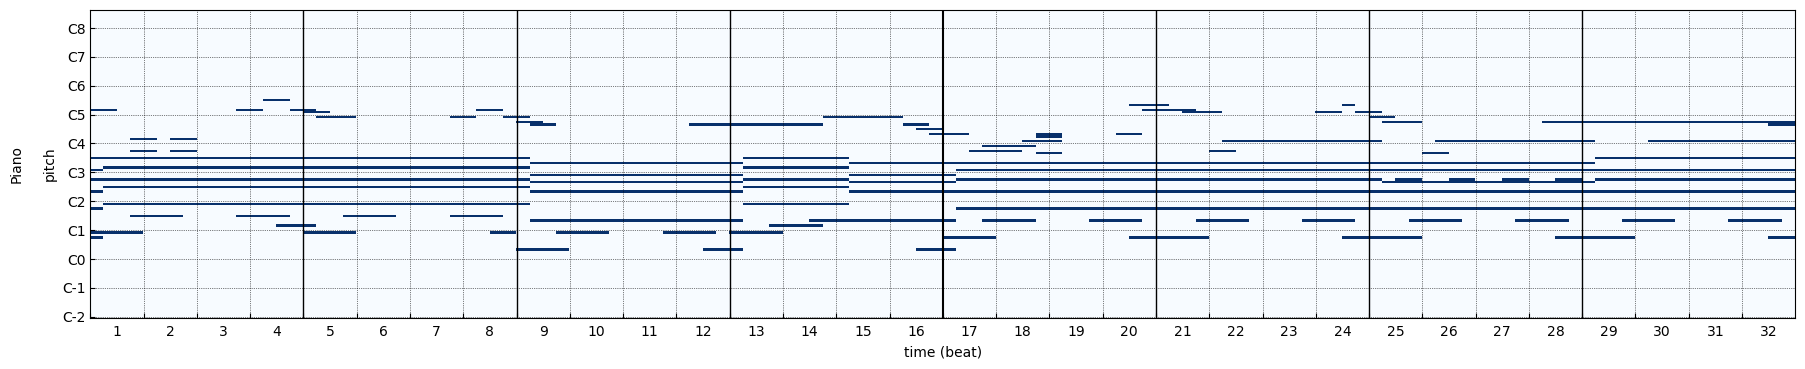

In [13]:
multitrack = build_multitrack(data[20])
show_multitrack(multitrack)


### Create dataset and data loader

In [14]:
import os
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import time as time
from IPython import display
from torch.utils.data import Dataset, DataLoader


class TensorDataset(Dataset): # class to convert np.array to torch.tensor

    def __init__(self, dataset, transform=None):
        self.x = dataset
        self.transform = transform
    
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx]
        if self.transform:
            x = self.transform(x)
        else:
            x = torch.from_numpy(x).type(torch.FloatTensor)
        return x

In [15]:
dataset = TensorDataset(data) # no transform, so convert to torch.tensor

device = "cuda" if torch.cuda.is_available() else "cpu" # selecting device
dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True) # creating dataloader of a given batch size

In [16]:
def weights_init(m): # function to perform weights initialization in a network
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    if classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

## Model

 ### Define the generator

 ### Define the discriminator

## Training functions

In [17]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1)
    #print(alpha.shape)
    if torch.cuda.is_available():
        alpha = alpha.cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1)
    if torch.cuda.is_available():
        fake = fake.cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [18]:
def train_one_step(d_optimizer, g_optimizer, real_samples, latent_dim, counter, train_step, device, add_noise = False):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        latent = latent.cuda()
    
    # Add noise to the training to help convergence
    if add_noise:
        noise1 = (0.1*torch.randn(real_samples.shape)/(train_step+1)).to(device)
        noise2 = (0.1*torch.randn(real_samples.shape)/(train_step+1)).to(device)
    else:
        noise1 = 0
        noise2 = 0
    
    # Train discriminator
    if counter % n_gen == 0:
        d_optimizer.zero_grad()
    
    if CONDITIONED:
        prediction_real = discriminator(real_samples[:, 1] + noise1)
    else:
        prediction_real = discriminator(real_samples + noise1)
        
    d_loss_real = -torch.mean(prediction_real)

    if counter % n_disc == 0:
        d_loss_real.backward()
    
    if CONDITIONED:
        fake_samples = generator(latent, real_samples[:, 0])
    else:
        fake_samples = generator(latent)
    
    prediction_fake_d = discriminator(fake_samples.detach() + noise2)
    d_loss_fake = torch.mean(prediction_fake_d)

    if counter % n_disc == 0:
        d_loss_fake.backward()

    if CONDITIONED:
        gradient_penalty = 10.0 * compute_gradient_penalty(discriminator, real_samples[:, 1].data, fake_samples.data)
    else:
        gradient_penalty = 10.0 * compute_gradient_penalty(discriminator, real_samples.data, fake_samples.data)
    
    if counter % n_disc == 0:
        gradient_penalty.backward()
        d_optimizer.step()
    
    # Train generator
    if counter % n_gen == 0:
        g_optimizer.zero_grad()
        
    prediction_fake_g = discriminator(fake_samples)
    g_loss = -torch.mean(prediction_fake_g)
    
    if counter % n_gen == 0:
        g_loss.backward()
        g_optimizer.step()

    return d_loss_real.detach(), d_loss_fake.detach(), gradient_penalty.detach(), g_loss.detach()

## Training Preparation

In [19]:
epochs = 50
n_disc = 1 # ogni quante batches il discriminator fa training
n_gen = 1 # ogni quante batches il generator fa training
add_wi = False # adding weight initialization
add_noise = False # adding noise to the training
add_layernorm = False # adding layernorm to the discriminator
exp_decay = False # adding exponential decay
add_dropout = False # adding dropout layer
TTUR = 1 # set to 1 if not used
lr = 0.001 # set learning rate value for generator

In [20]:
# Create neural networks
#discriminator =  Discriminator_mine(n_tracks, beat_resolution, n_pitches, add_layernorm, add_dropout)
discriminator =  Discriminator_paper2_all(n_tracks, beat_resolution, n_pitches, add_layernorm, add_dropout)
if add_wi: 
    discriminator.apply(weights_init)

if CONDITIONED:
    generator = Generator_paper2_cond(latent_dim, n_tracks, beat_resolution, n_pitches)
else:
    #generator = Generator_mine(latent_dim, n_tracks, beat_resolution, n_pitches)
    generator = Generator_paper2_all_s(latent_dim, n_tracks, beat_resolution, n_pitches)
    
if add_wi: 
    generator.apply(weights_init)

print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers

if not(exp_decay):

    gen_opt = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))  # to have TTUR set different lr? YES!
    dis_opt = torch.optim.Adam(discriminator.parameters(), lr=TTUR*lr, betas=(0.5, 0.9))

else:
  
    learning_rate = lr
    learning_rate_decay_factor = 0.96
    learning_rate_decay_step = 3000

    gen_opt = torch.optim.Adam(params=generator.parameters(), lr=learning_rate)
    gen_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=gen_opt, gamma=learning_rate_decay_factor,last_epoch=-1)
    dis_opt = torch.optim.Adam(params=discriminator.parameters(), lr=TTUR*learning_rate)
    dis_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=dis_opt, gamma=learning_rate_decay_factor,last_epoch=-1)

'''
# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)


# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()
'''

# Create an empty dictionary to sotre history samples
history_samples = []

'''
# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

# Initialize step
step = 0
'''

Number of parameters in G: 600643
Number of parameters in D: 512065


'\n# Create a LiveLoss logger instance for monitoring\nliveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])\n\n# Initialize step\nstep = 0\n'

In [21]:
from torchsummary import summary

if not CONDITIONED:
    summary(generator, input_size = (1, latent_dim))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [23]:
summary(discriminator, input_size = (1, n_tracks, bar_resolution*n_bars, n_pitches))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1         [-1, 16, 4, 16, 7]             208
DiscriminatorBlock3d-2         [-1, 16, 4, 16, 7]               0
            Conv3d-3         [-1, 16, 4, 16, 7]             208
DiscriminatorBlock3d-4         [-1, 16, 4, 16, 7]               0
            Conv3d-5         [-1, 16, 4, 16, 7]             208
DiscriminatorBlock3d-6         [-1, 16, 4, 16, 7]               0
            Conv3d-7         [-1, 16, 4, 16, 7]             208
DiscriminatorBlock3d-8         [-1, 16, 4, 16, 7]               0
            Conv3d-9         [-1, 16, 4, 16, 7]             208
DiscriminatorBlock3d-10         [-1, 16, 4, 16, 7]               0
           Conv3d-11          [-1, 16, 4, 8, 7]             528
DiscriminatorBlock3d-12          [-1, 16, 4, 8, 7]               0
           Conv3d-13          [-1, 16, 4, 8, 7]             528
DiscriminatorBlock3d-14  

## Training

In [21]:
def train(dataloader, epochs, generator, discriminator, batch_size, input_size, device, add_noise = False):

    g_loss = []
    d_loss = []
    d_fake_loss = []
    d_real_loss = []
    d_gp = []

    for epoch in range(epochs): 
        
        generator.train()
        discriminator.train()

        gen_losses = []
        disc_losses = []
        disc_losses_real = []
        disc_losses_fake = []
        grad_penalties = []

        counter = 1
        
        for image_batch in tqdm(dataloader, desc = "TRAIN Epoch [%d/%d]"%(epoch+1, epochs)):
            
            #image_batch = image_batch.type(torch.FloatTensor)
            image_batch = image_batch.to(device)

            
            #print(image_batch.shape)

            # gen_loss, disc_loss = train_step(image_batch, generator, discriminator, input_size, device, dis_opt, gen_opt)

            disc_loss_real, disc_loss_fake, grad_p, gen_loss = train_one_step(dis_opt, gen_opt, image_batch, latent_dim, counter, epoch, device, add_noise)
            #train_step_grp(image_batch, latent_dim, generator, discriminator, dis_opt, gen_opt, device)

            disc_loss = disc_loss_real + disc_loss_fake + grad_p

            gen_losses.append(gen_loss.detach().cpu())
            disc_losses.append(disc_loss.detach().cpu())
            disc_losses_fake.append(disc_loss_fake.detach().cpu())
            disc_losses_real.append(disc_loss_real.detach().cpu())
            grad_penalties.append(grad_p.detach().cpu())

            counter += 1
            
        if exp_decay == True: #update learning rate for exponential decay, update once per epoch
        
            dis_lr_scheduler.step()
            gen_lr_scheduler.step()

            print(dis_lr_scheduler.get_last_lr())
            print(gen_lr_scheduler.get_last_lr())

        g_loss.append(np.mean(gen_losses))
        d_loss.append(np.mean(disc_losses))
        d_fake_loss.append(np.mean(disc_losses_fake))
        d_real_loss.append(np.mean(disc_losses_real))
        d_gp.append(np.mean(grad_penalties))

        print("\n")
        print("disc:", np.mean(disc_losses))
        print("(fake:", np.mean(disc_losses_fake))
        print("(real:", np.mean(disc_losses_real))
        print("(grad_p:", np.mean(grad_penalties))

        print("gen:", np.mean(gen_losses))
      
        if epoch % 1 == 0:
            plt.figure(figsize=(10,6))
            plt.plot(g_loss, label="Generator loss")
            plt.plot(d_loss, label="Discriminator loss")
            plt.legend()
            plt.show()
            
        #if epoch % 1 == 0:
            # Get generated samples
        #    generator.eval()
        #    sample_latent = torch.randn((4, latent_dim)).to(device)
        #    samples = generator(sample_latent).cpu().detach().numpy()
        #    history_samples.append(samples)

        if epoch % 1 == 0:
            # Get generated samples
            generator.eval()
            sample_latent = torch.randn((4, latent_dim)).to(device)
            if CONDITIONED:
                idxs = np.random.randint(len(dataset), size = 4)
                samples = generator(sample_latent, dataset[idxs, 0].to(device)).cpu().detach().numpy()
            else:
                samples = generator(sample_latent).cpu().detach().numpy()
            history_samples.append(samples)
        
        m = build_multitrack(samples)
        
        show_multitrack(m)

    return g_loss, d_loss, d_fake_loss, d_real_loss, d_gp


In [25]:
#torch.cuda.empty_cache()

TRAIN Epoch [1/50]: 100%|██████████| 1493/1493 [09:33<00:00,  2.61it/s]




disc: -6.0350776
(fake: 15.023544
(real: -22.377028
(grad_p: 1.3184062
gen: -14.689861


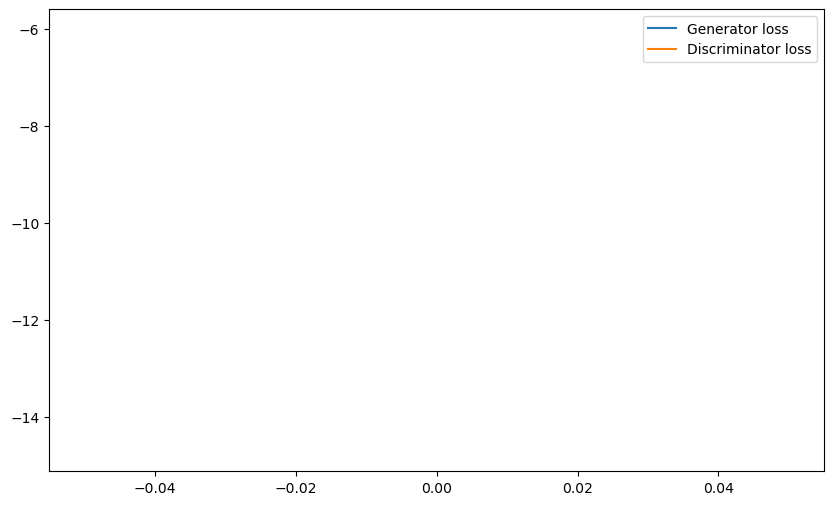

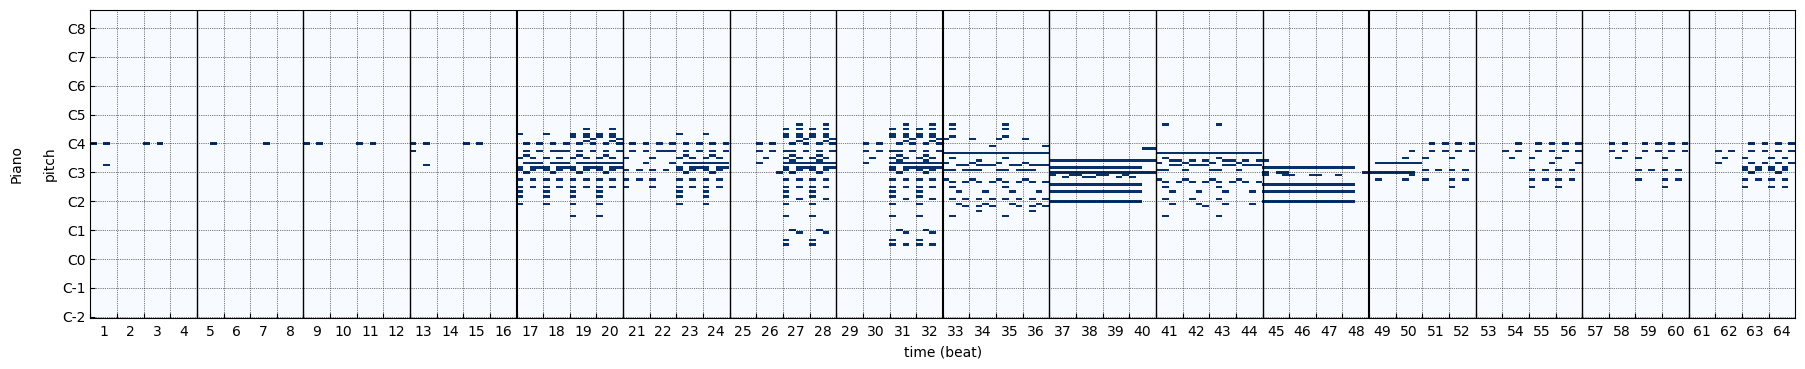

TRAIN Epoch [2/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -4.1216106
(fake: 6.7152586
(real: -11.432108
(grad_p: 0.5952391
gen: -6.472077


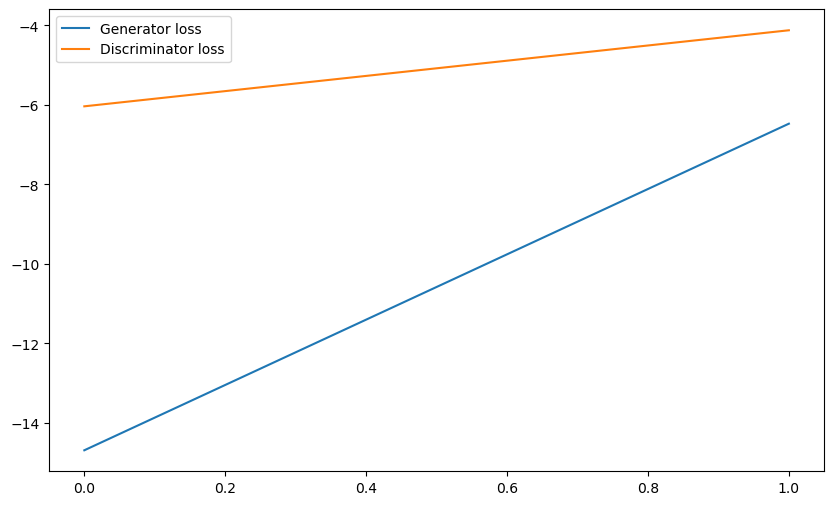

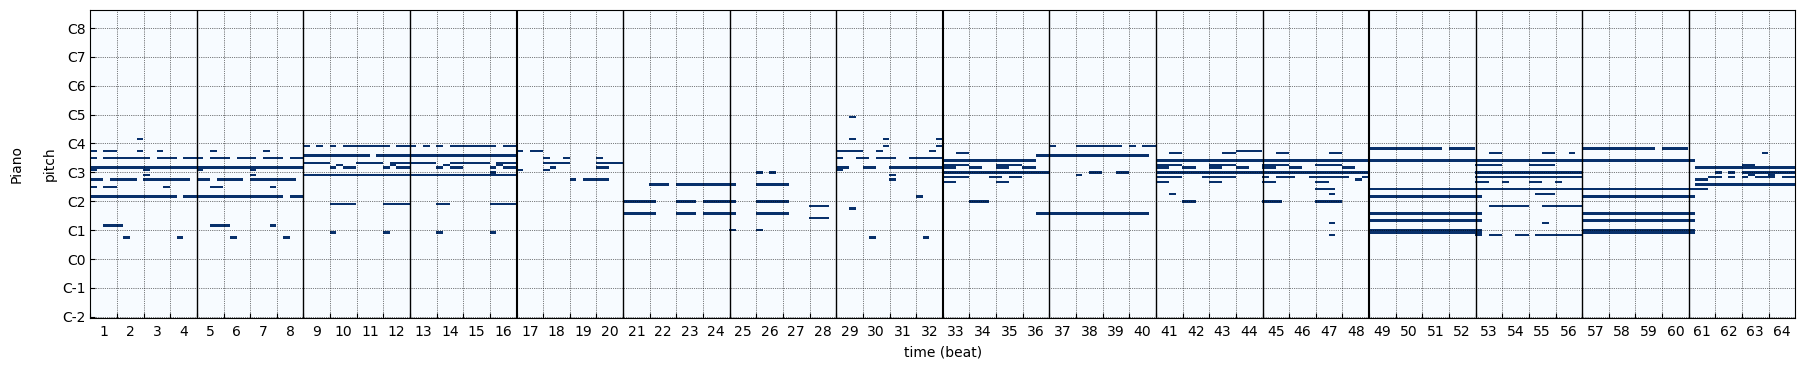

TRAIN Epoch [3/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -2.8054352
(fake: 6.207051
(real: -9.372742
(grad_p: 0.3602563
gen: -5.969537


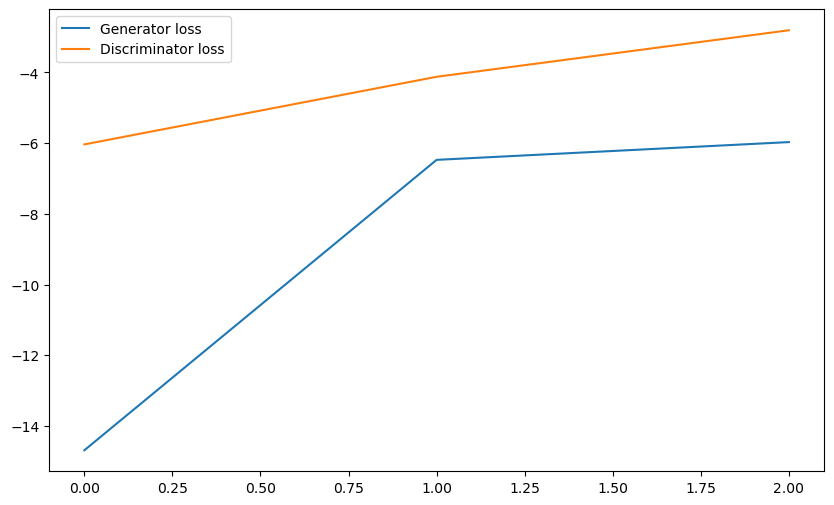

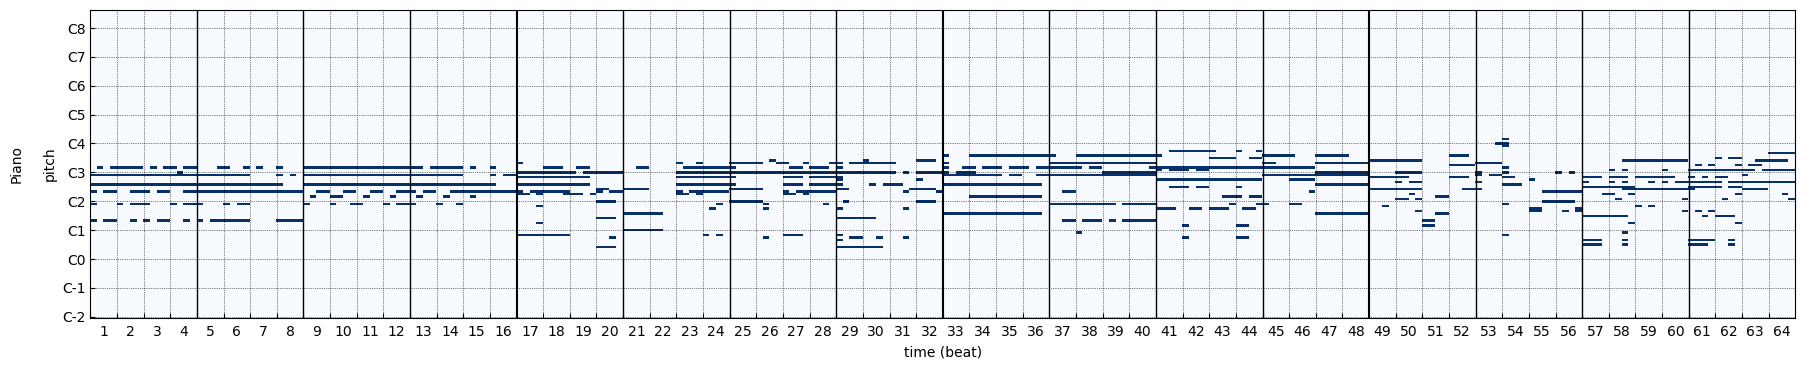

TRAIN Epoch [4/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -2.2121158
(fake: 6.930027
(real: -9.420693
(grad_p: 0.2785513
gen: -6.7133813


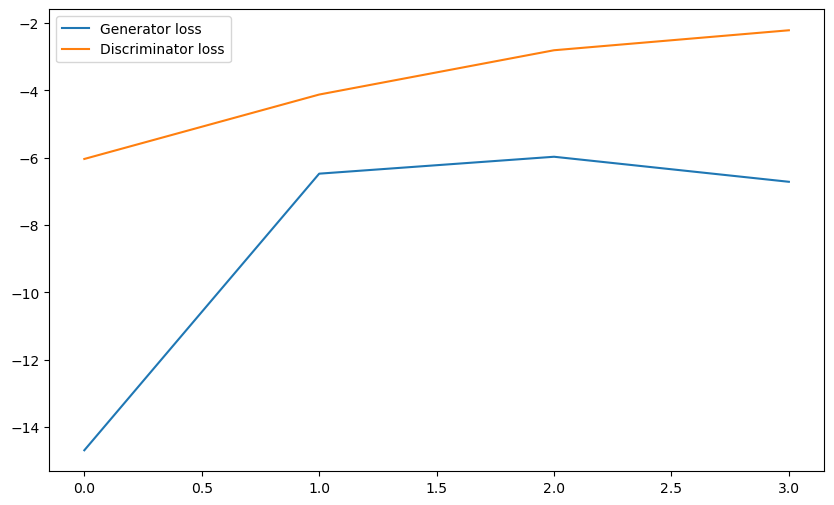

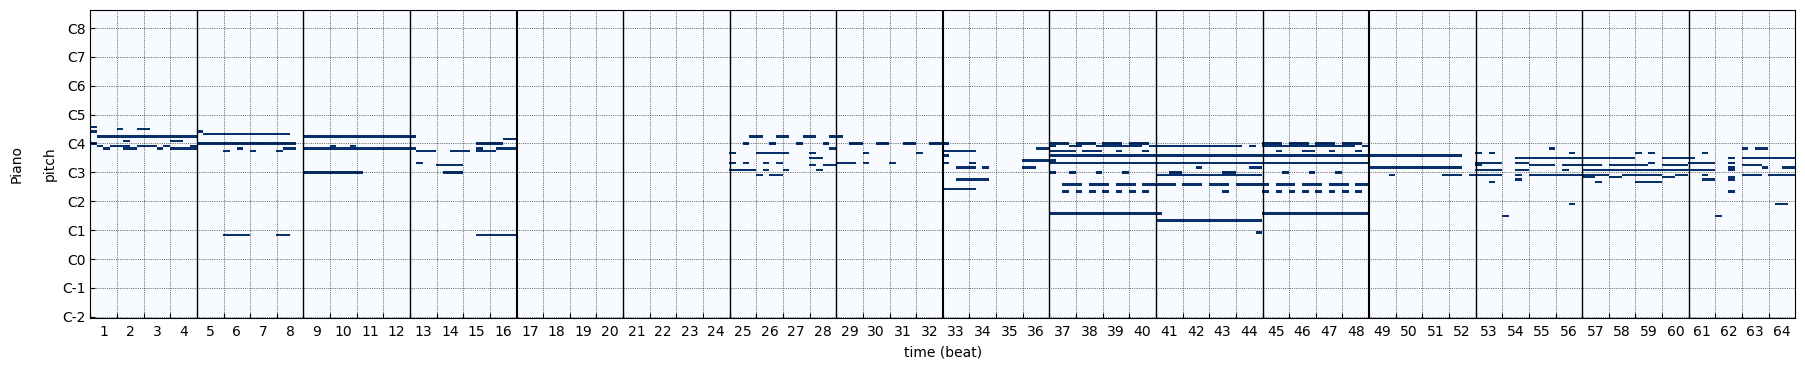

TRAIN Epoch [5/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.864821
(fake: 6.9993773
(real: -9.1063795
(grad_p: 0.24218088
gen: -6.8133874


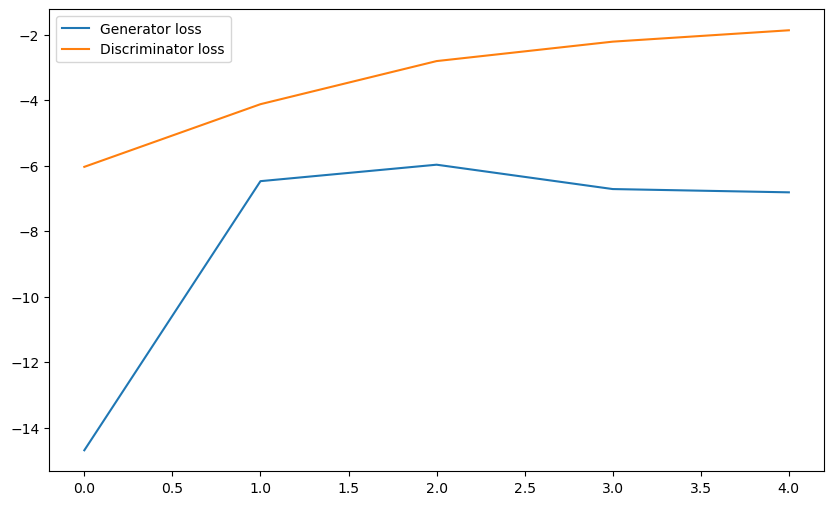

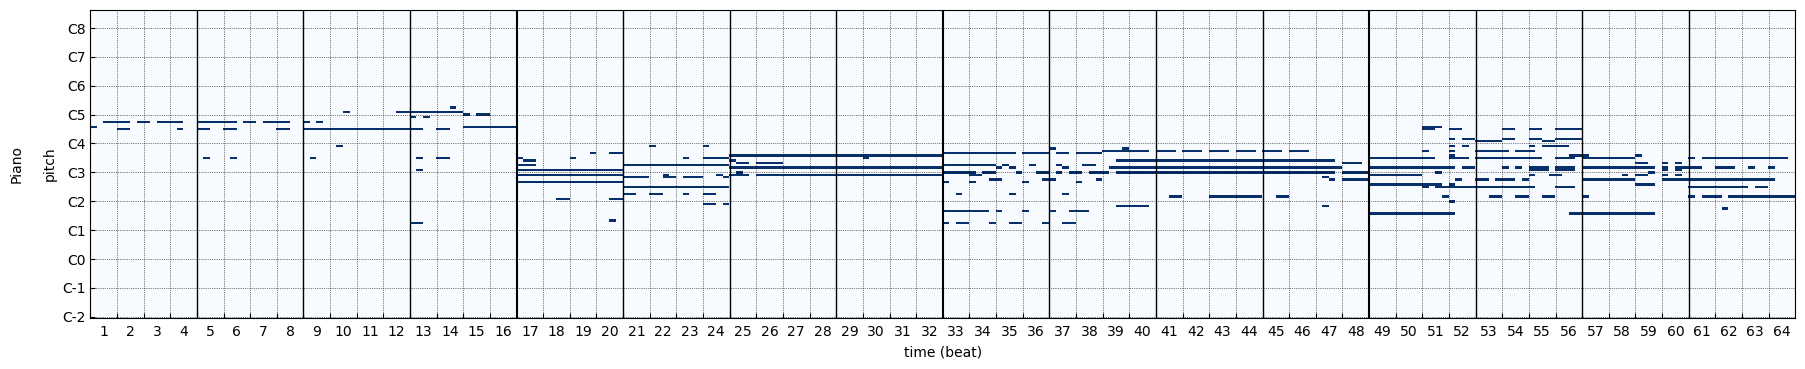

TRAIN Epoch [6/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.6481942
(fake: 6.7432075
(real: -8.62007
(grad_p: 0.2286695
gen: -6.572704


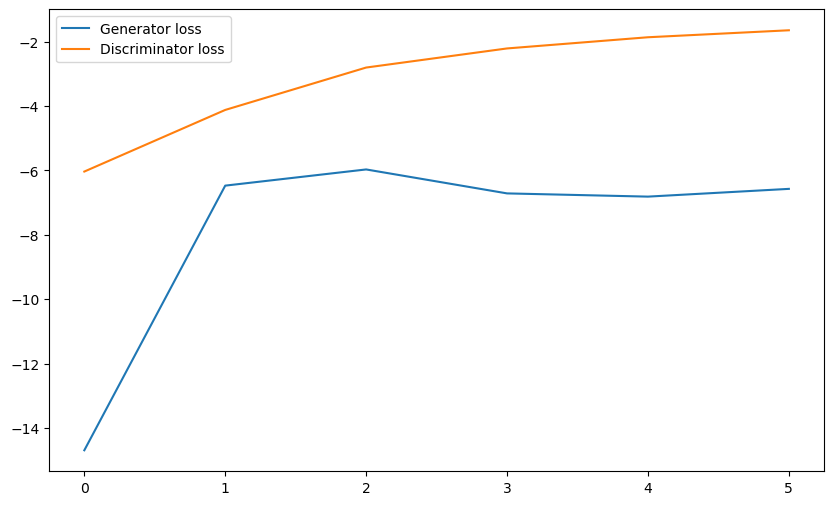

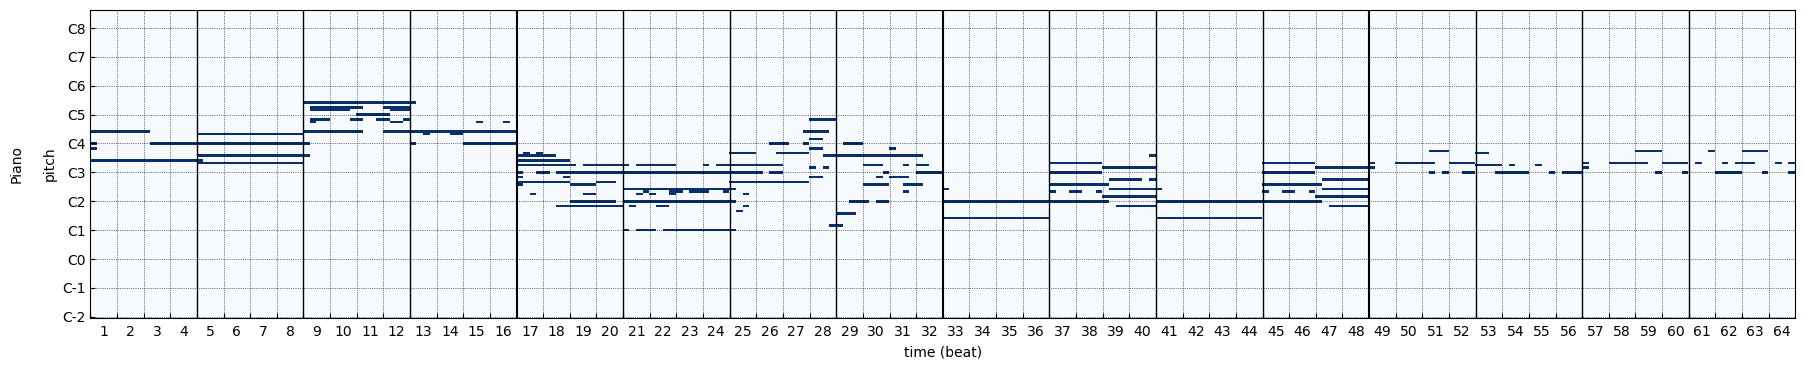

TRAIN Epoch [7/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.5264482
(fake: 6.605126
(real: -8.347726
(grad_p: 0.21615095
gen: -6.448249


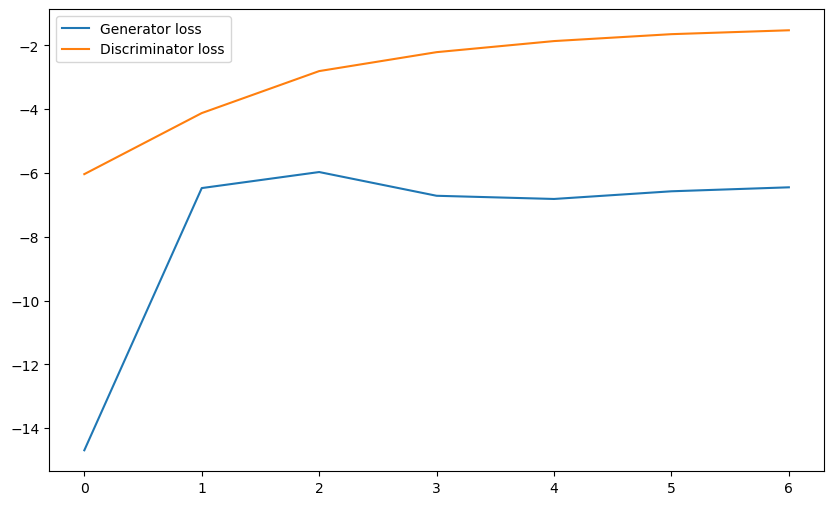

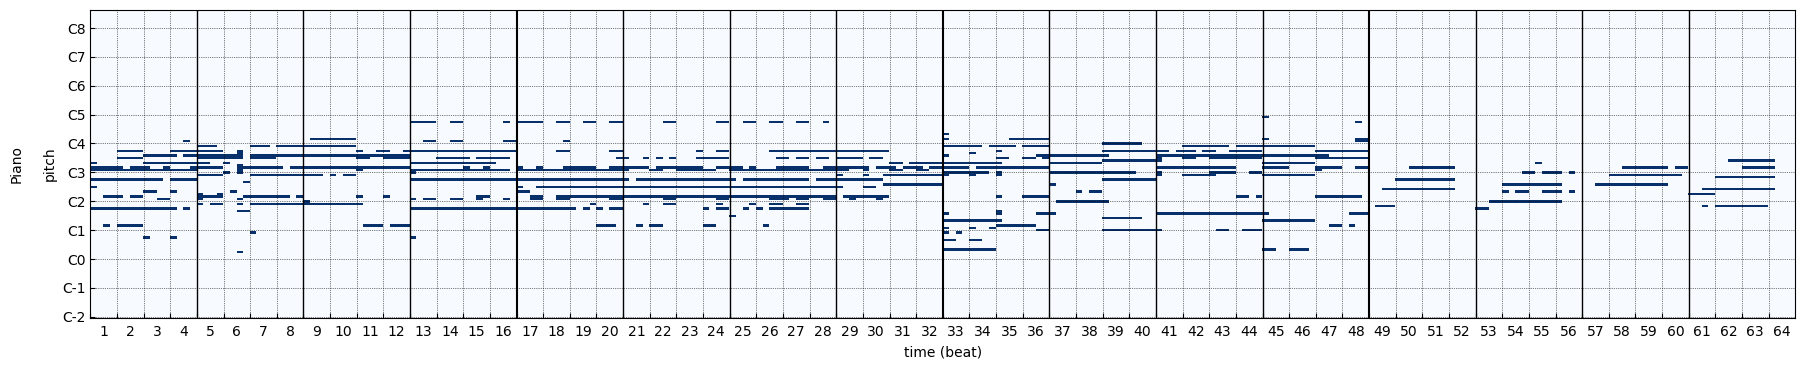

TRAIN Epoch [8/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.4120197
(fake: 6.313405
(real: -7.939492
(grad_p: 0.2140668
gen: -6.1610155


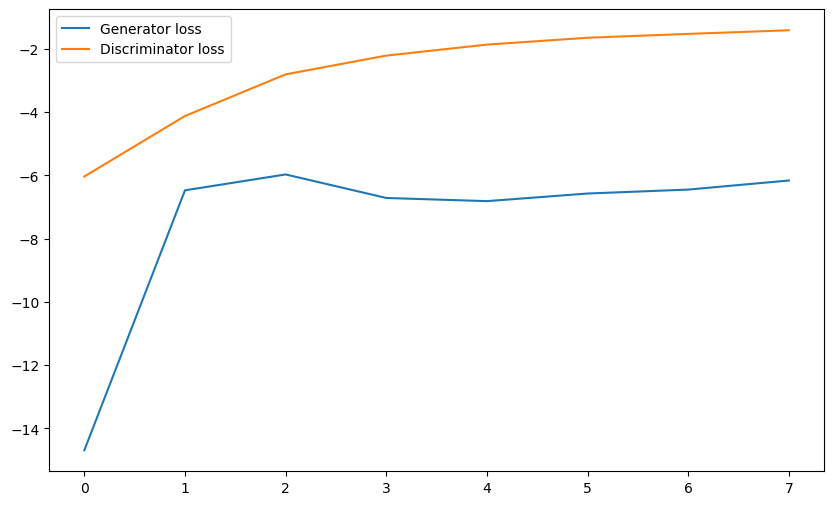

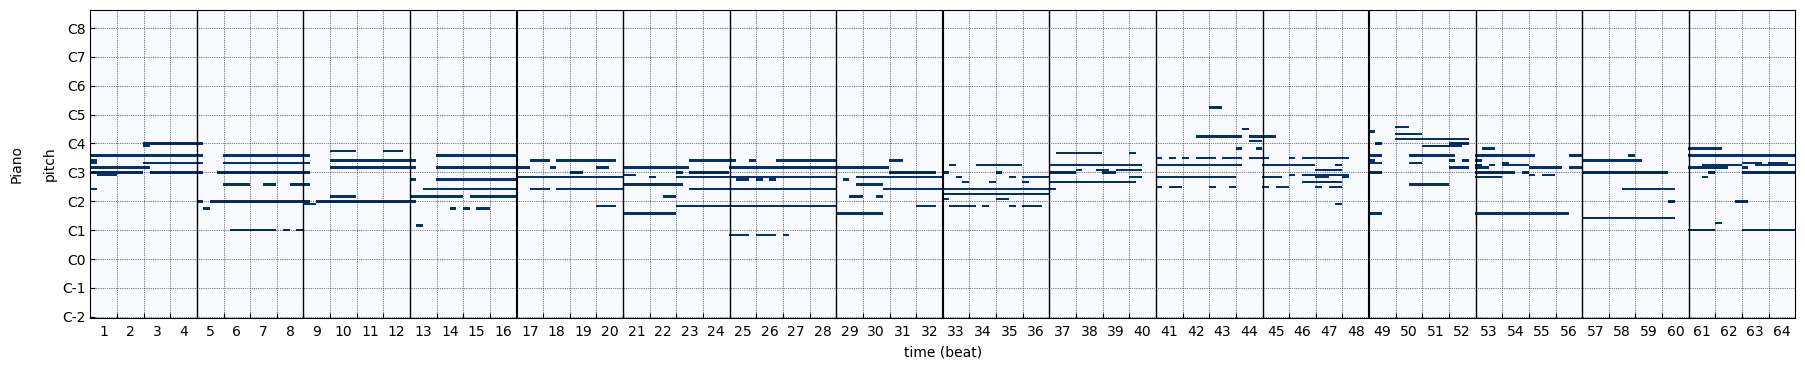

TRAIN Epoch [9/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.3392437
(fake: 6.192777
(real: -7.743016
(grad_p: 0.21099474
gen: -6.0436063


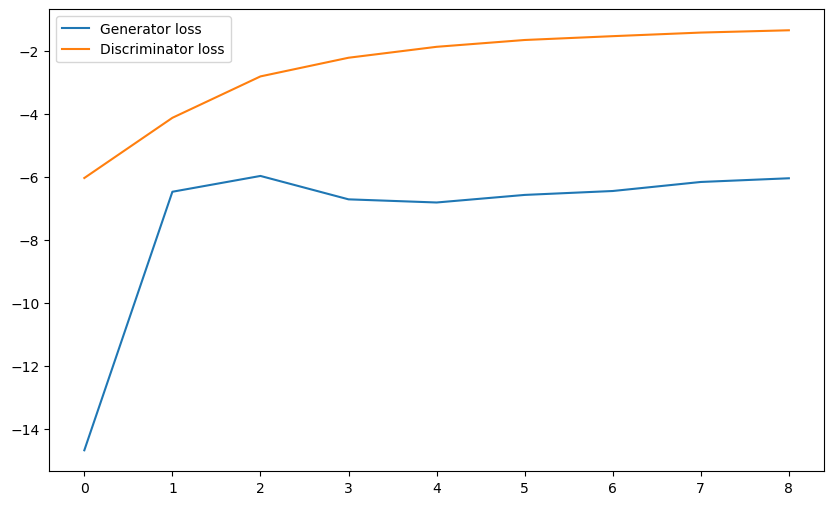

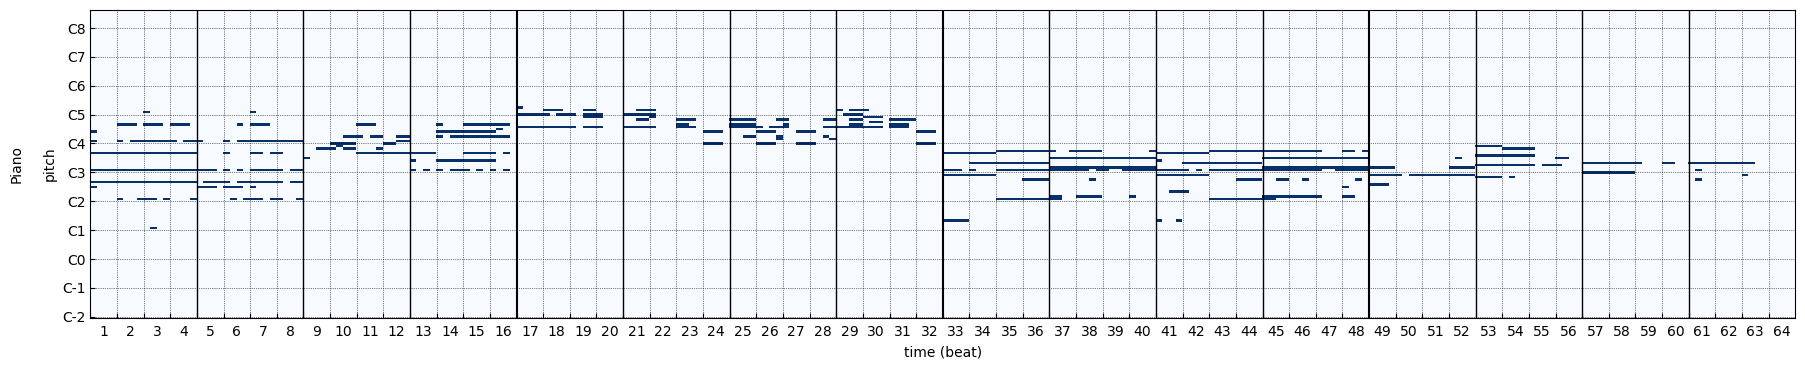

TRAIN Epoch [10/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.2871736
(fake: 5.9234934
(real: -7.411985
(grad_p: 0.20131765
gen: -5.772202


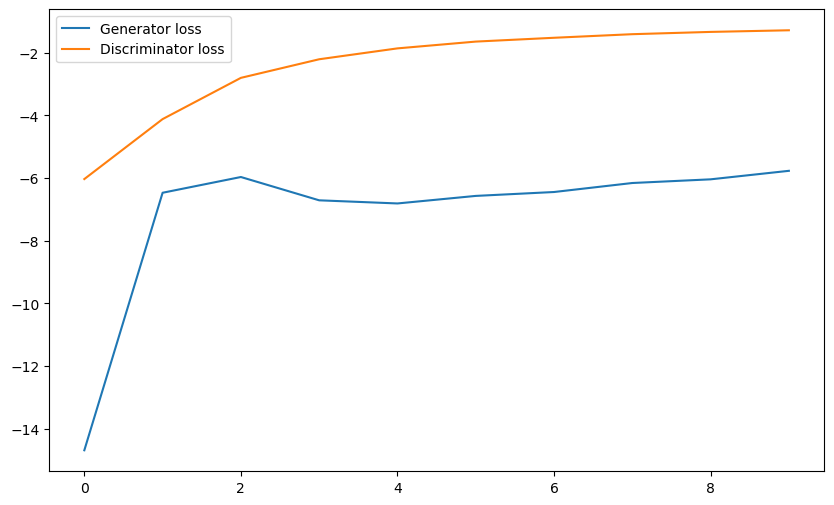

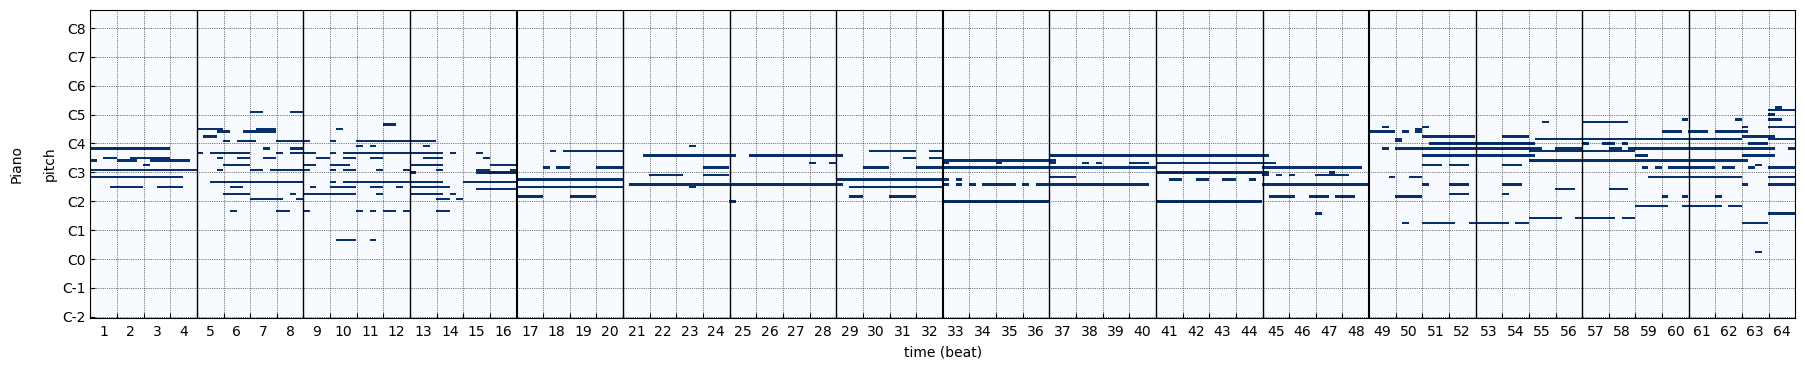

TRAIN Epoch [11/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.2411302
(fake: 5.4285126
(real: -6.8698783
(grad_p: 0.20023525
gen: -5.28097


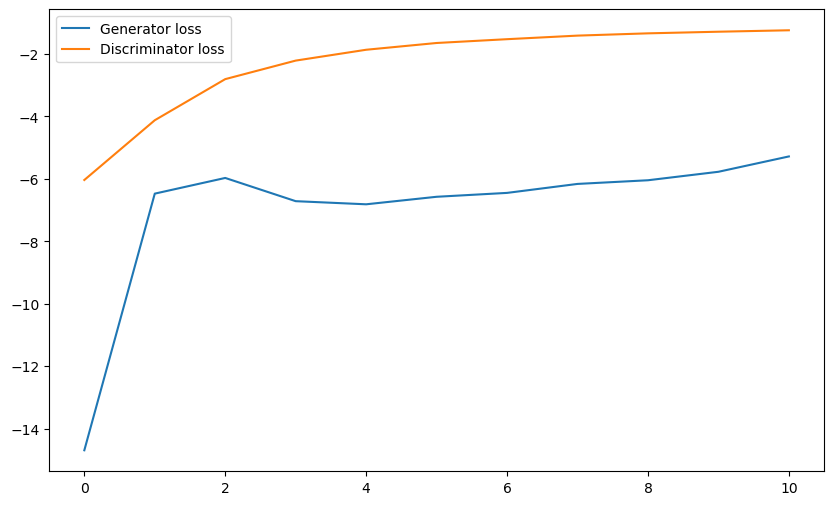

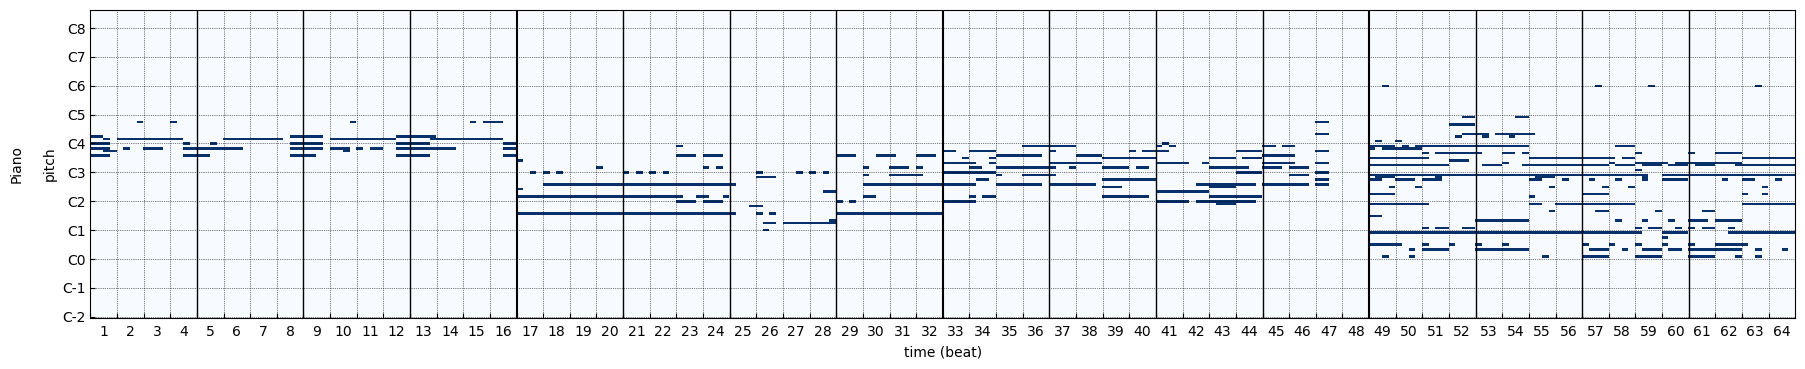

TRAIN Epoch [12/50]: 100%|██████████| 1493/1493 [09:25<00:00,  2.64it/s]




disc: -1.2194735
(fake: 5.3868723
(real: -6.8041406
(grad_p: 0.19779544
gen: -5.238473


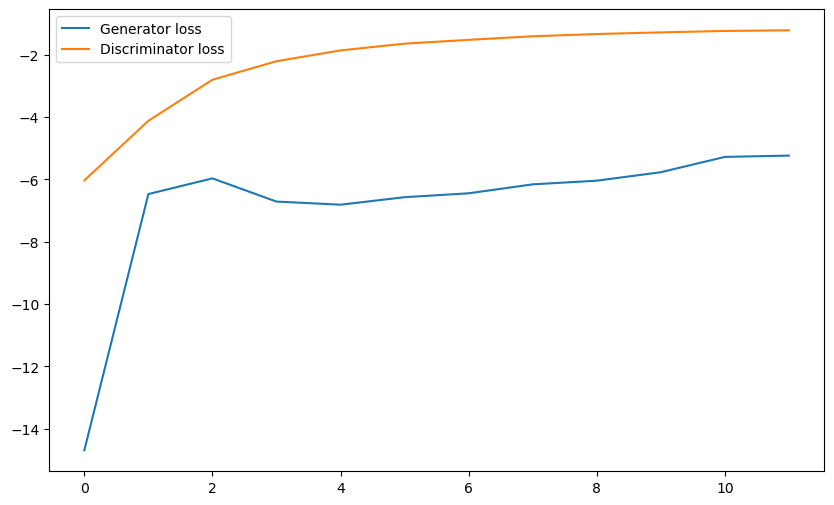

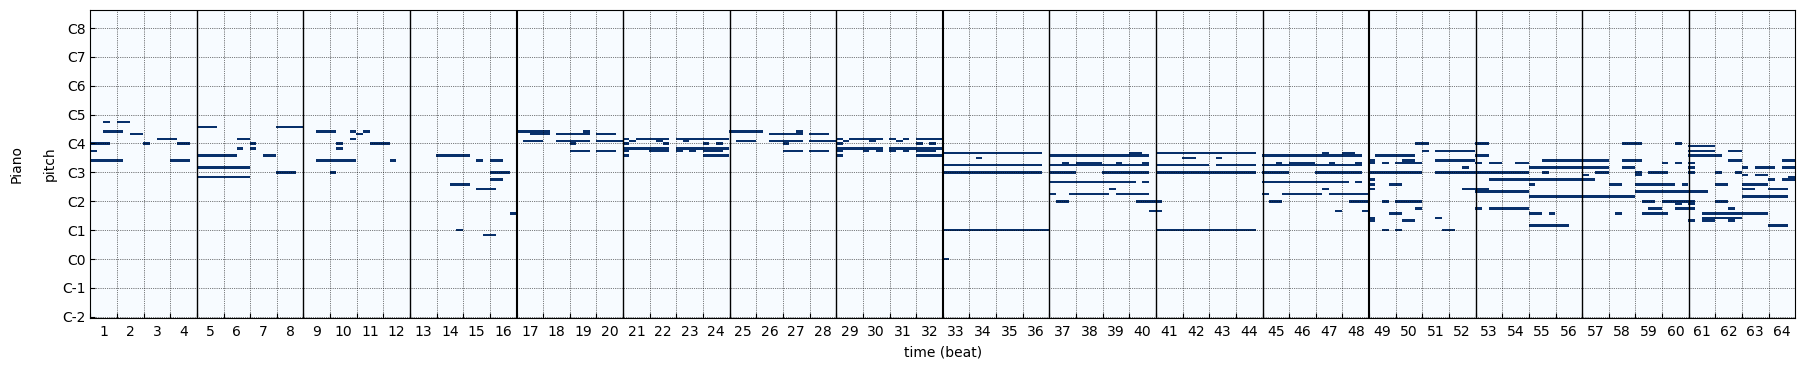

TRAIN Epoch [13/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.202401
(fake: 5.1853557
(real: -6.587861
(grad_p: 0.20010392
gen: -5.0358596


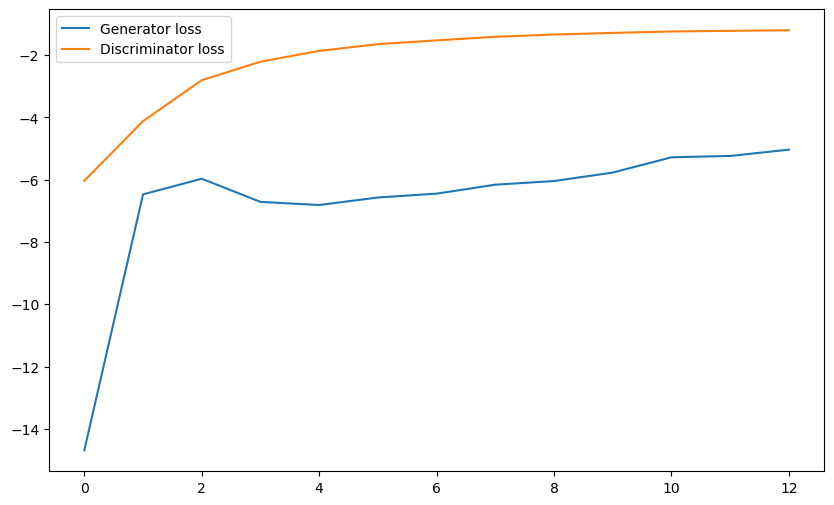

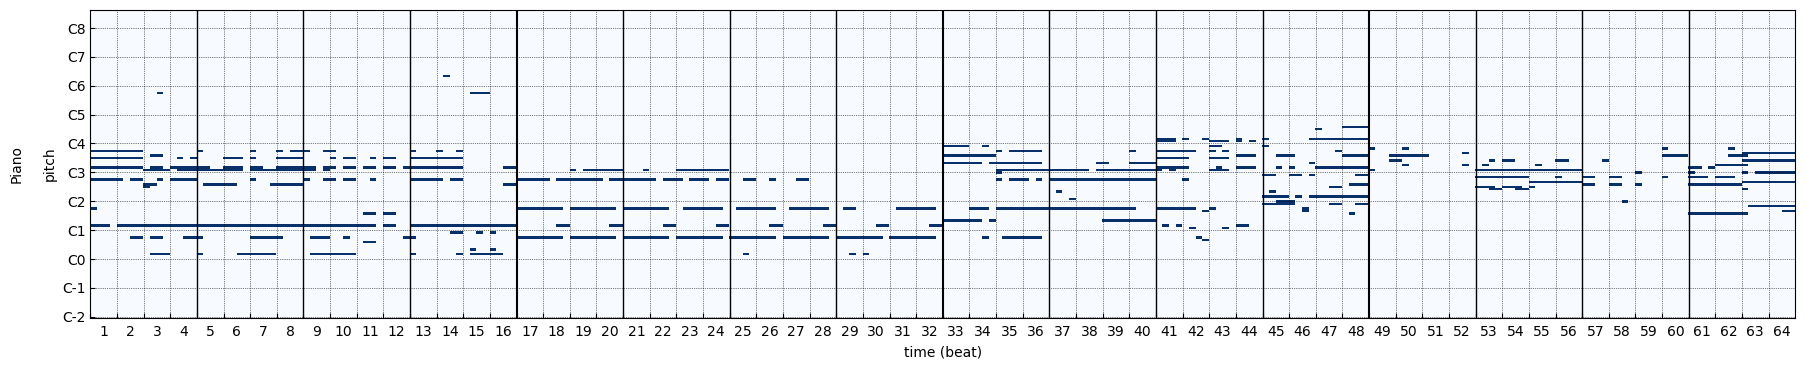

TRAIN Epoch [14/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.1994903
(fake: 5.292607
(real: -6.6910934
(grad_p: 0.19899607
gen: -5.1414857


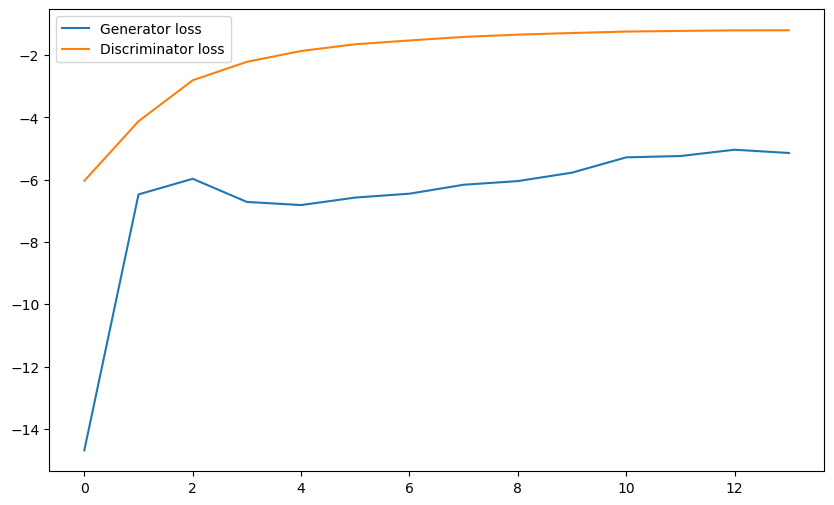

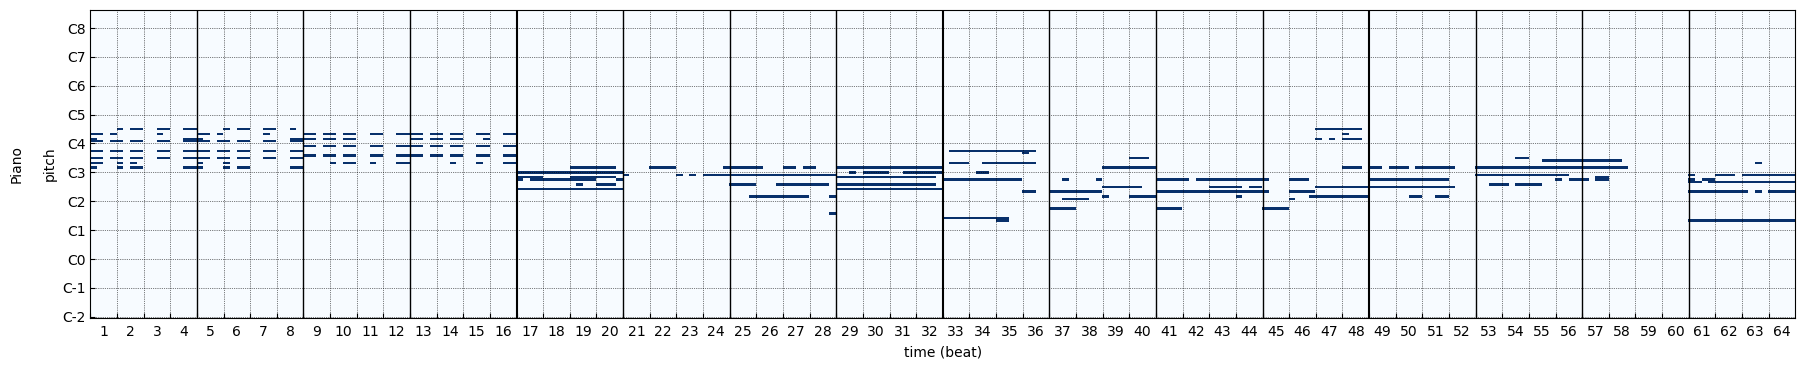

TRAIN Epoch [15/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.1767724
(fake: 5.280375
(real: -6.667805
(grad_p: 0.21065749
gen: -5.1219764


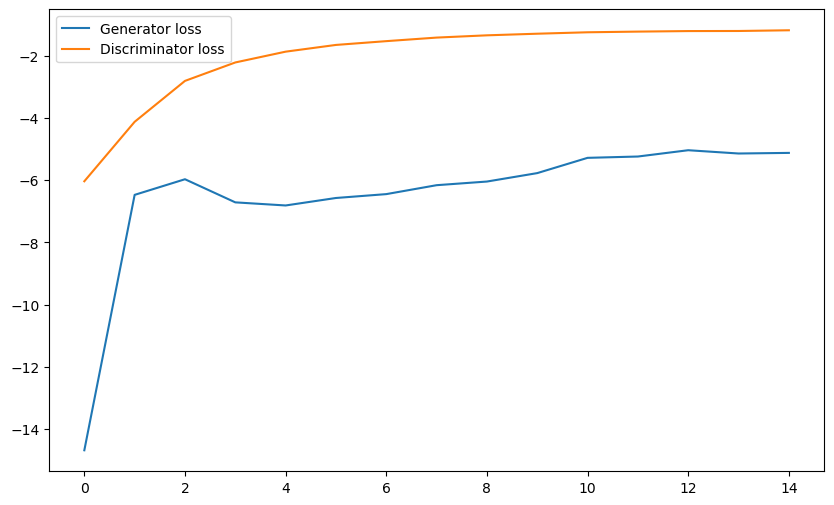

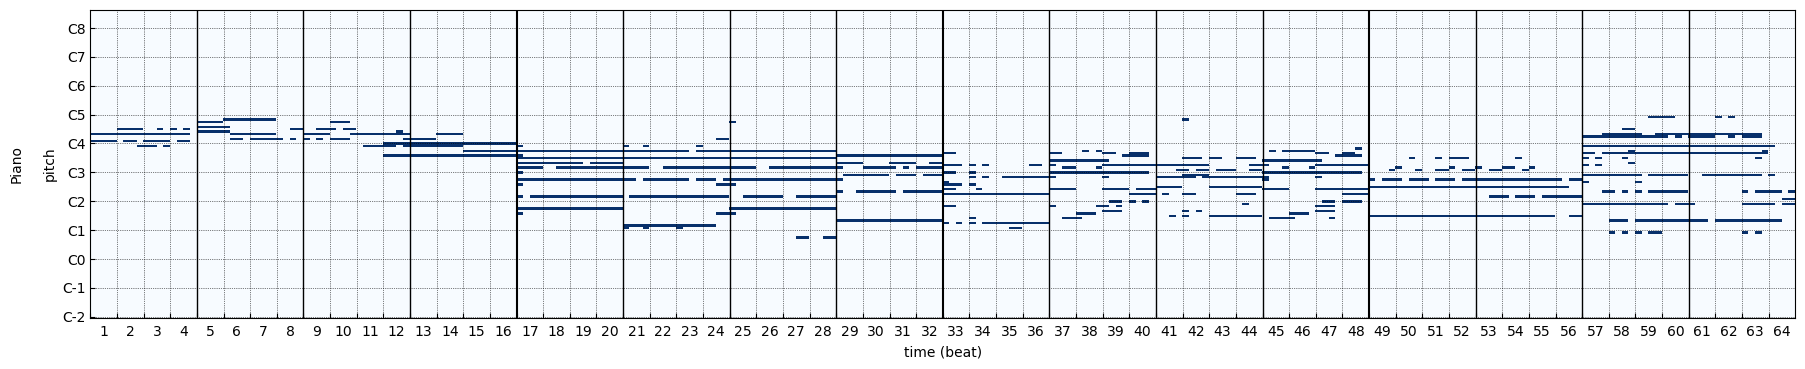

TRAIN Epoch [16/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.1172725
(fake: 5.384676
(real: -6.7163405
(grad_p: 0.21439216
gen: -5.222621


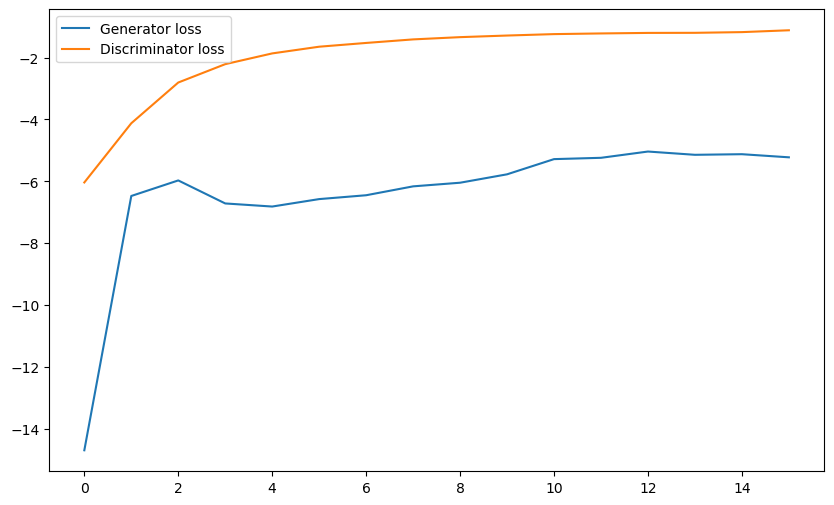

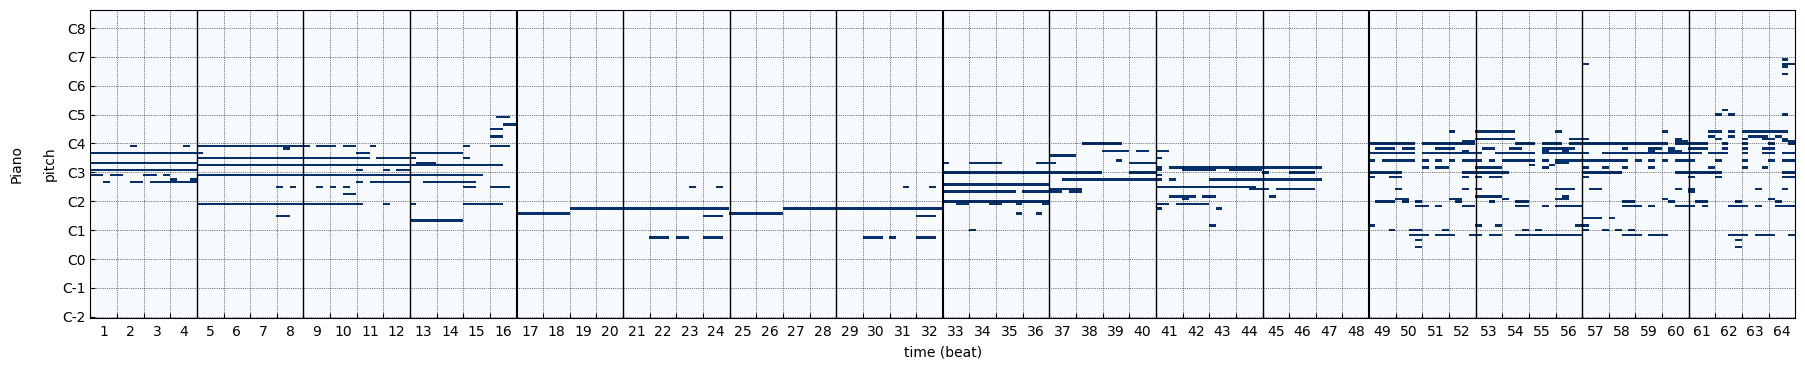

TRAIN Epoch [17/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.0798117
(fake: 5.100217
(real: -6.3973503
(grad_p: 0.21732236
gen: -4.9367623


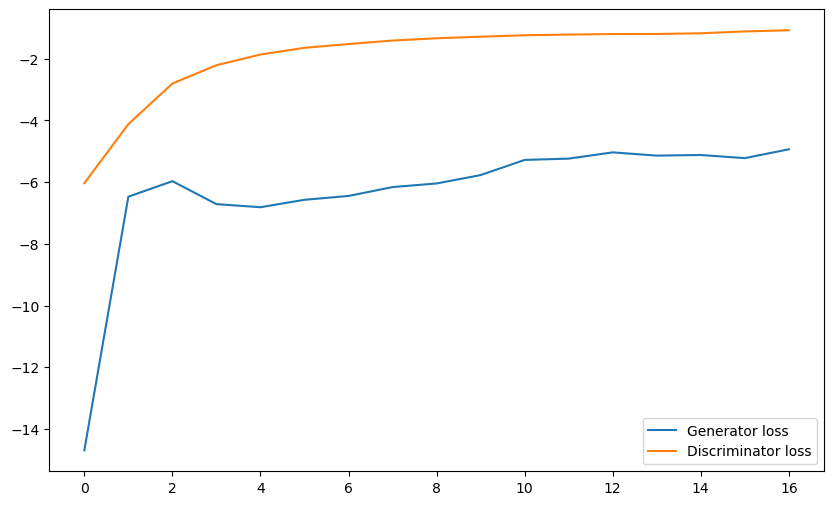

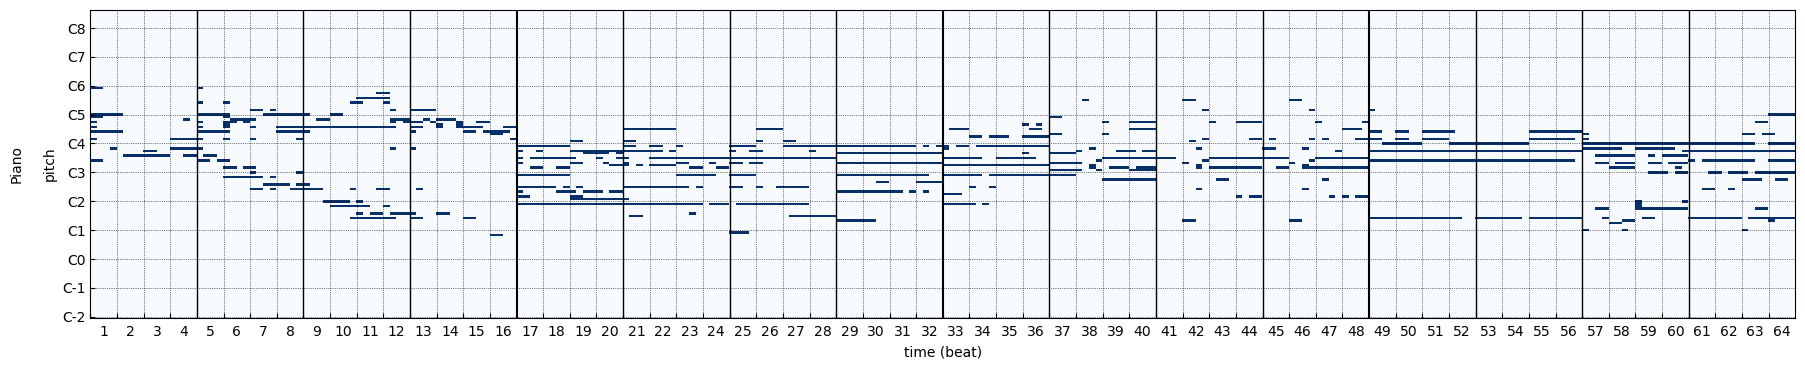

TRAIN Epoch [18/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.0599931
(fake: 5.0137525
(real: -6.292615
(grad_p: 0.21886986
gen: -4.8467116


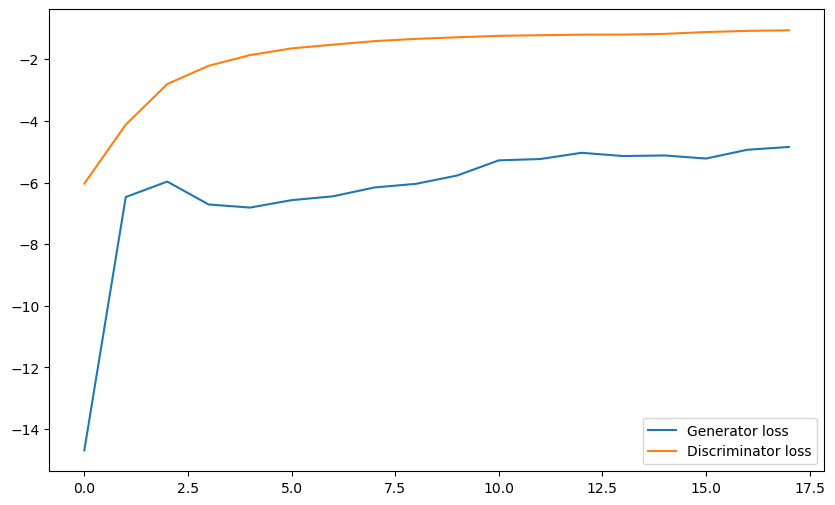

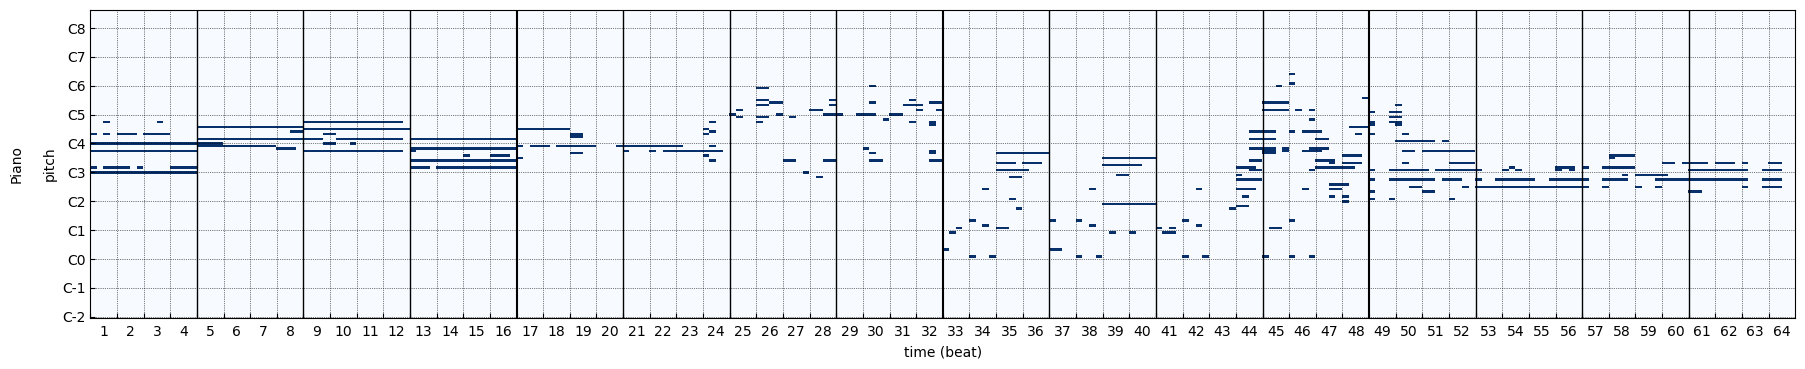

TRAIN Epoch [19/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.0557715
(fake: 5.0965905
(real: -6.370201
(grad_p: 0.21783866
gen: -4.9251323


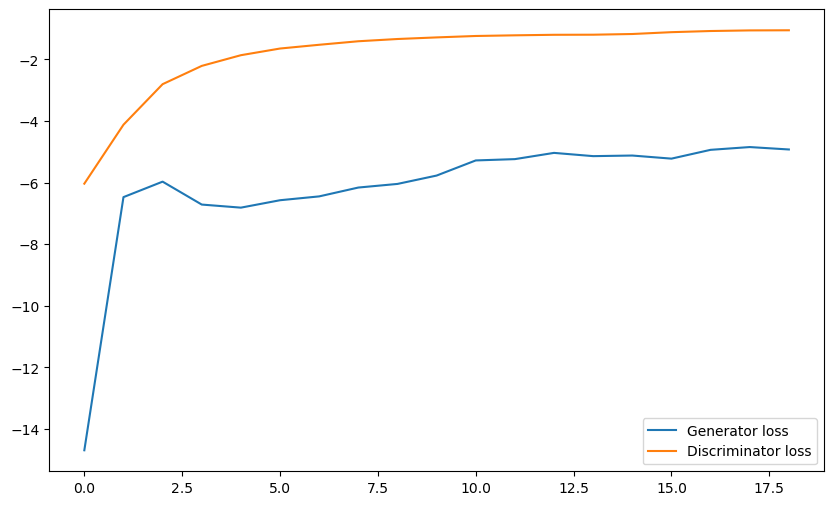

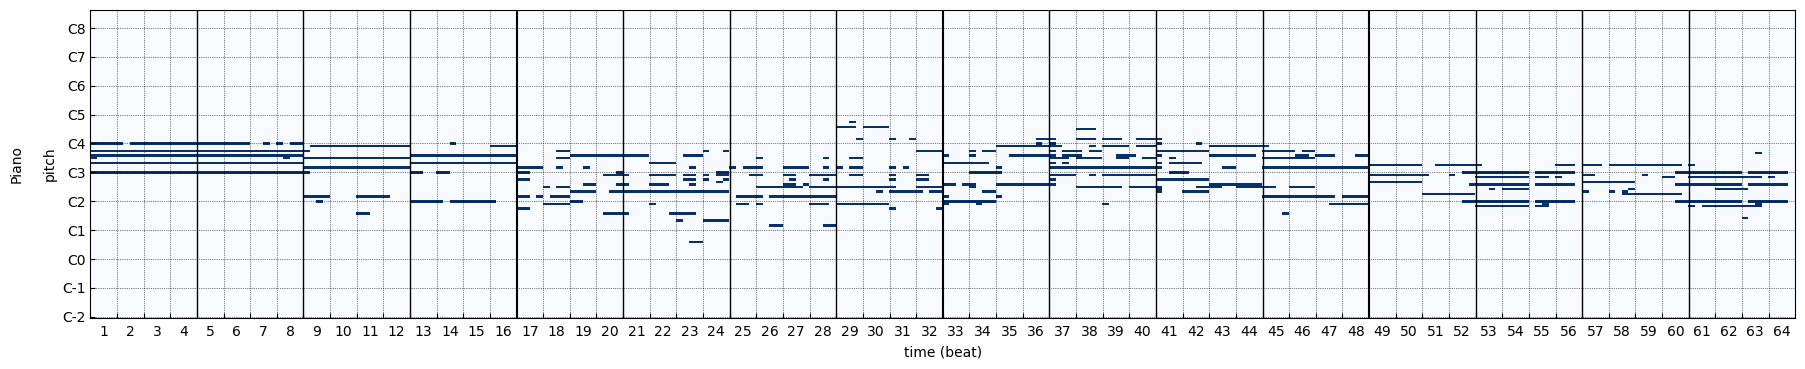

TRAIN Epoch [20/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.0488003
(fake: 4.958785
(real: -6.2312727
(grad_p: 0.2236873
gen: -4.789267


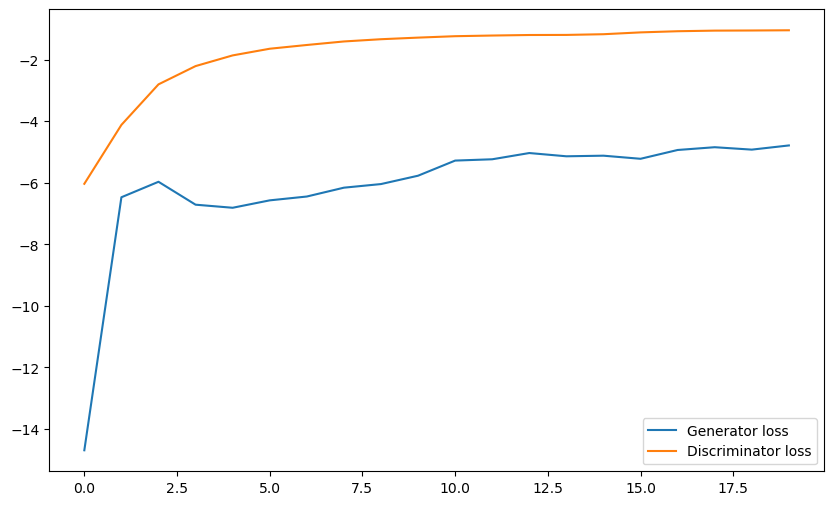

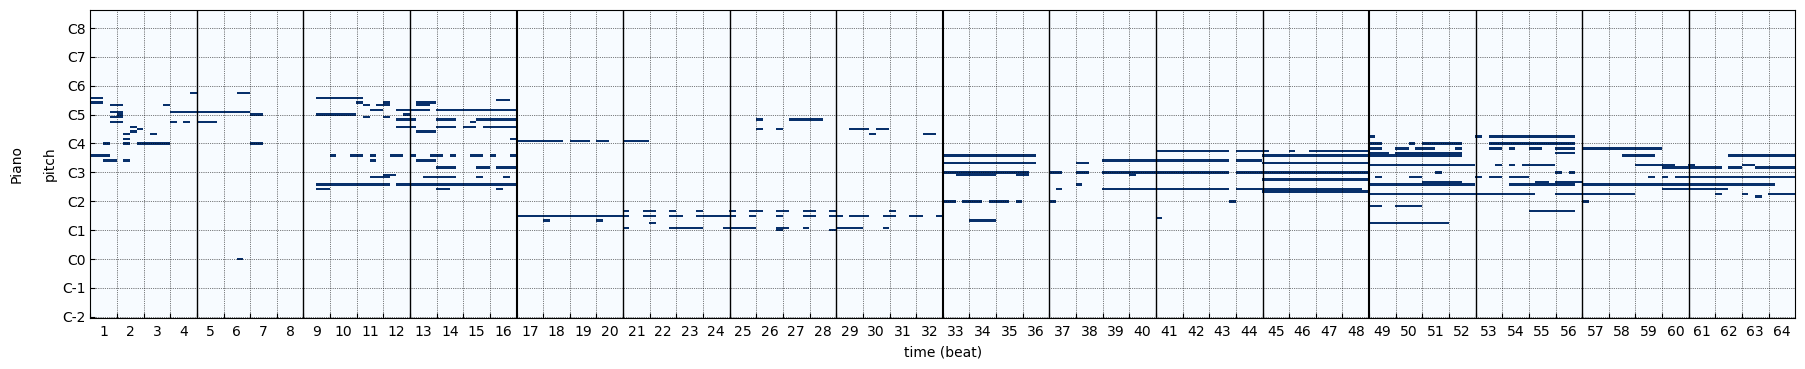

TRAIN Epoch [21/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.0594926
(fake: 4.9392905
(real: -6.2104716
(grad_p: 0.21168865
gen: -4.769932


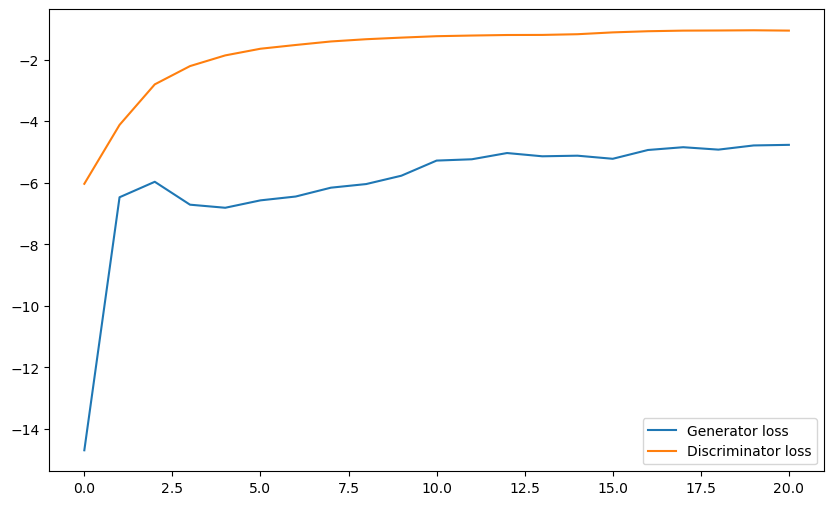

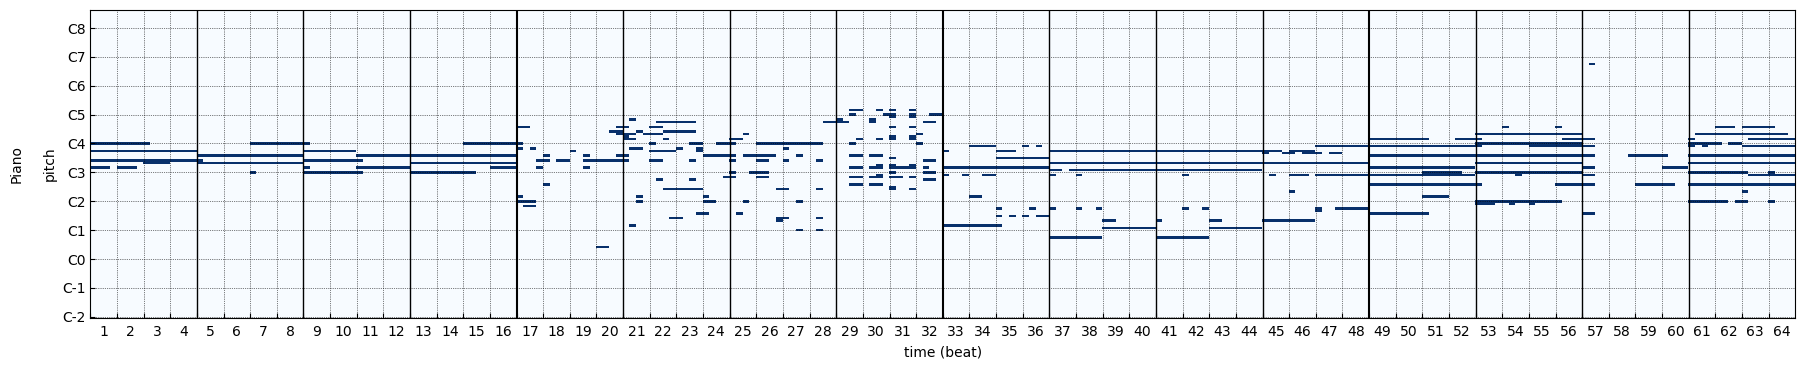

TRAIN Epoch [22/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.03342
(fake: 4.9025197
(real: -6.1554246
(grad_p: 0.21948488
gen: -4.7348313


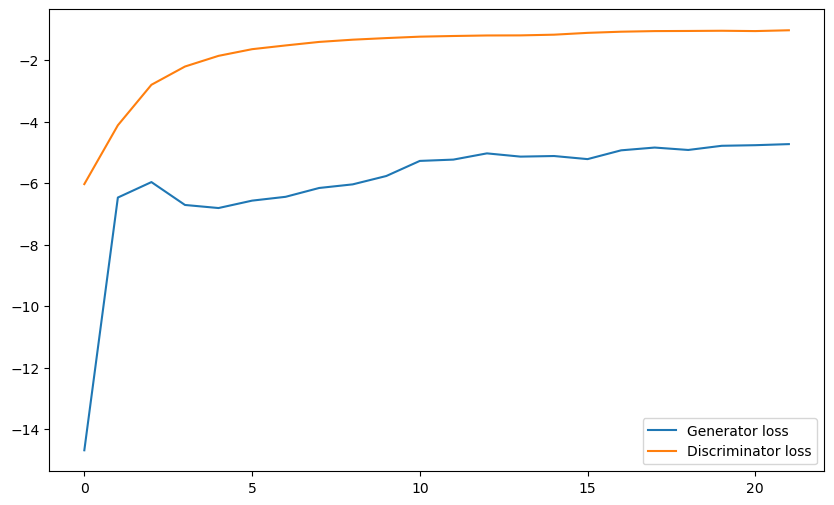

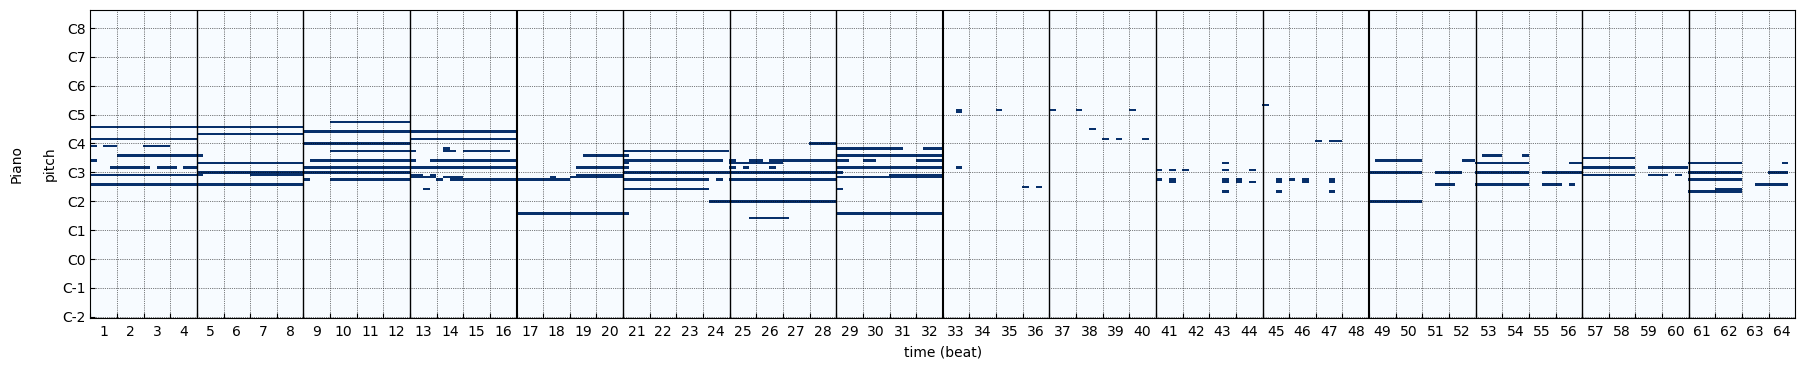

TRAIN Epoch [23/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.0280455
(fake: 4.8944182
(real: -6.1325192
(grad_p: 0.21005553
gen: -4.727416


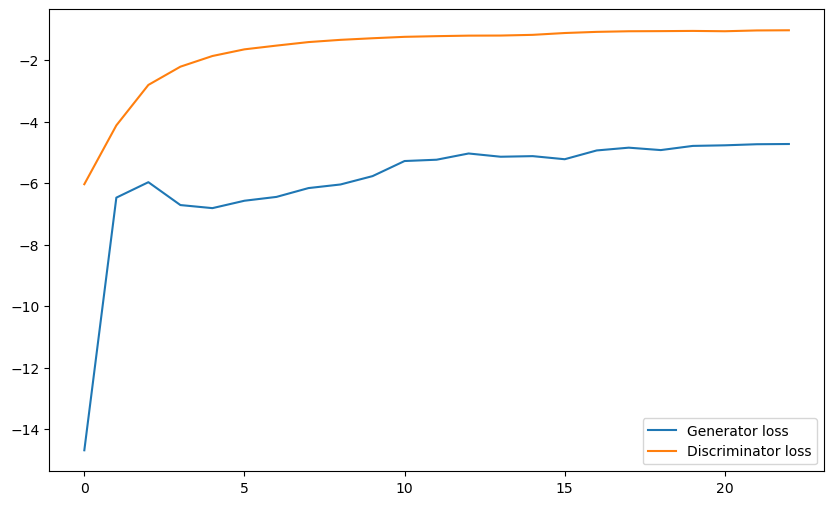

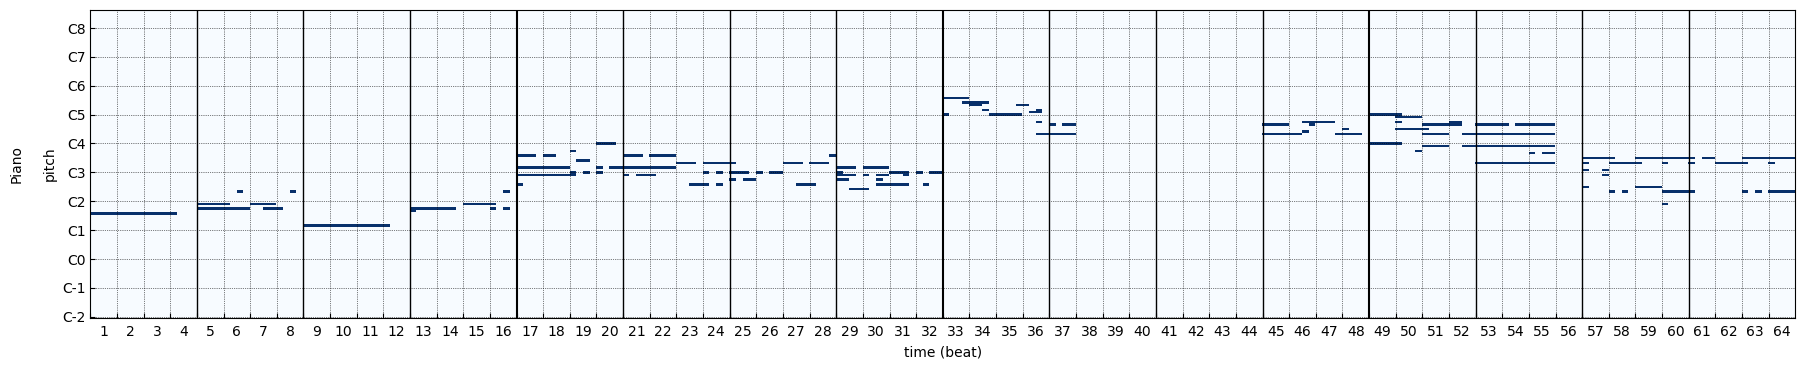

TRAIN Epoch [24/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.0218416
(fake: 4.937611
(real: -6.1753483
(grad_p: 0.21589525
gen: -4.766303


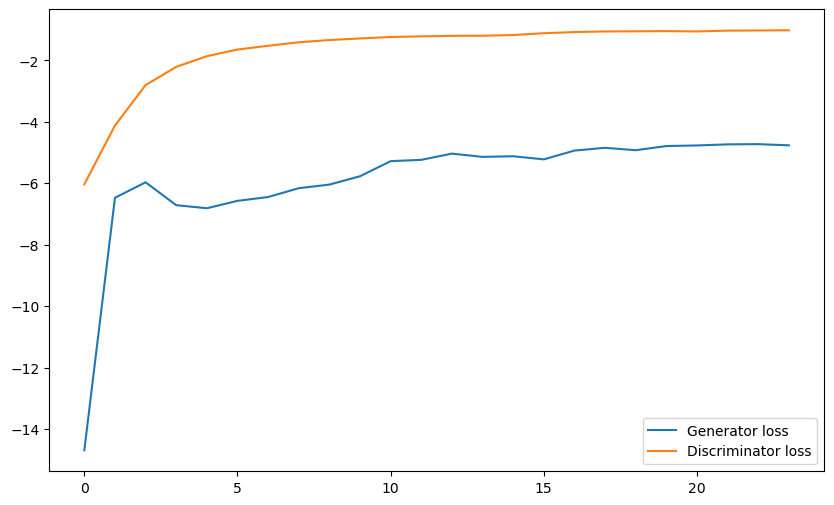

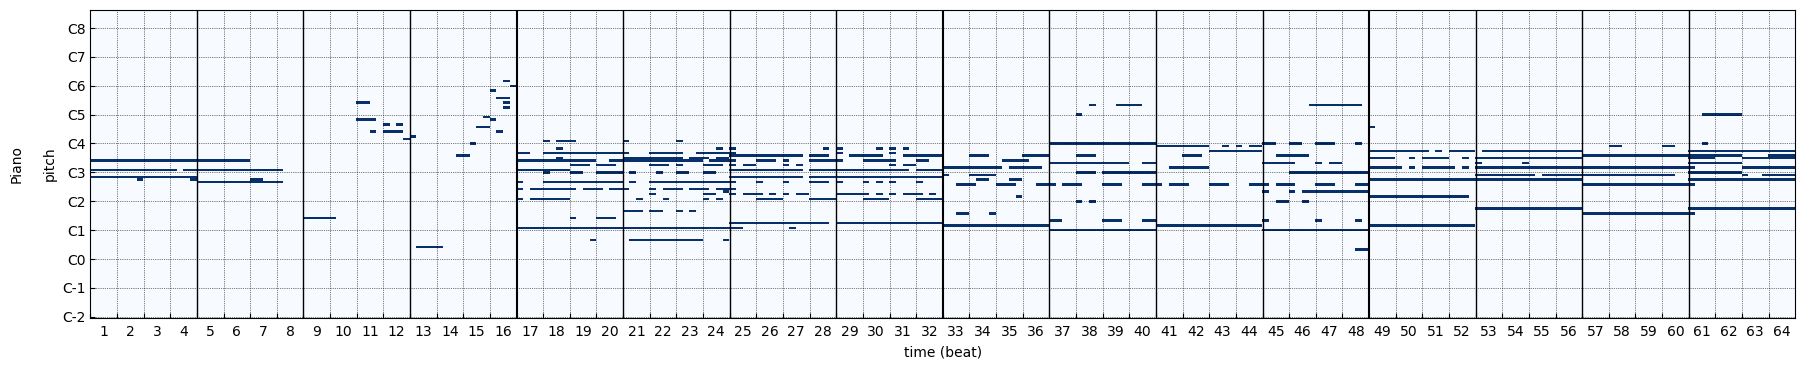

TRAIN Epoch [25/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.0074162
(fake: 4.977303
(real: -6.1950083
(grad_p: 0.21028958
gen: -4.807221


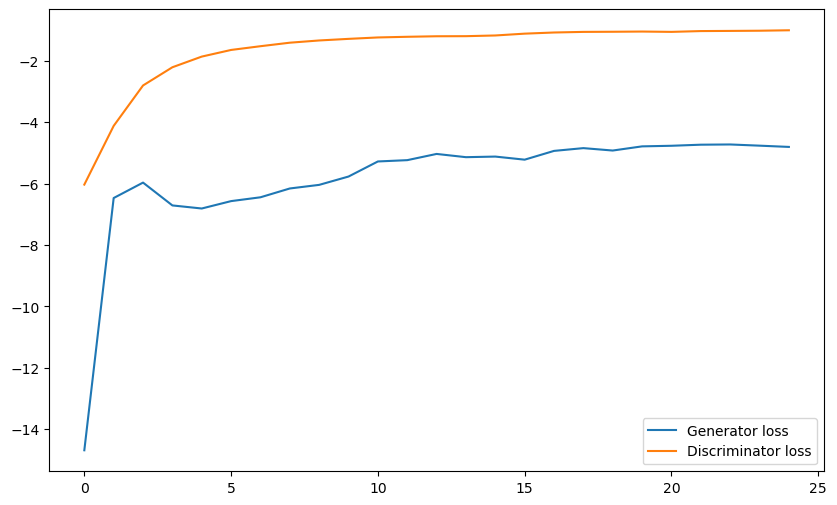

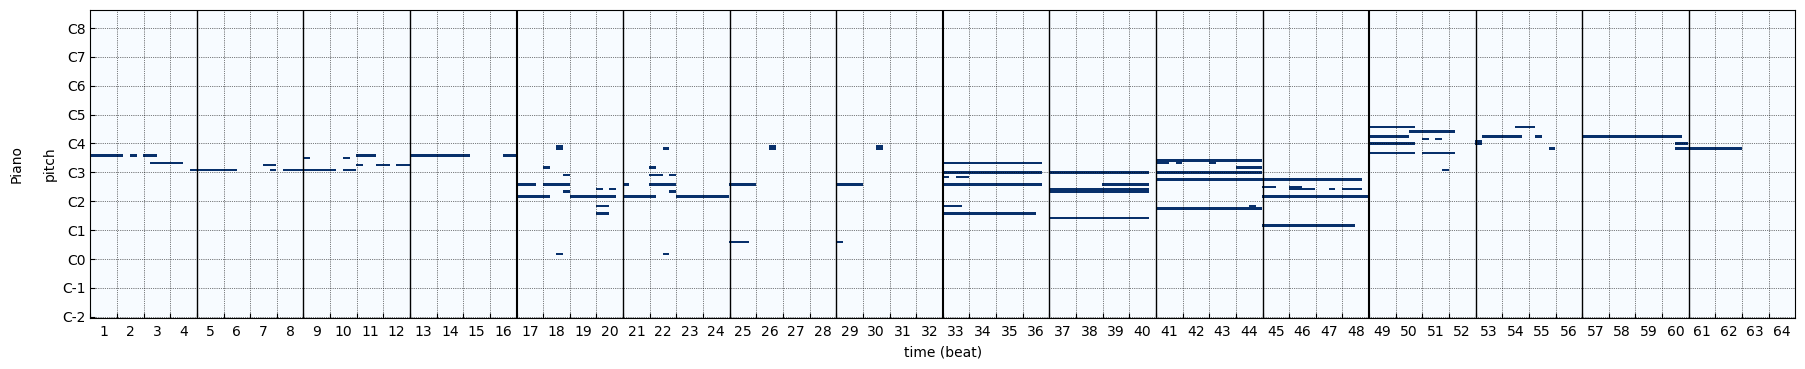

TRAIN Epoch [26/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -1.0092505
(fake: 5.1044736
(real: -6.3177905
(grad_p: 0.20406681
gen: -4.935285


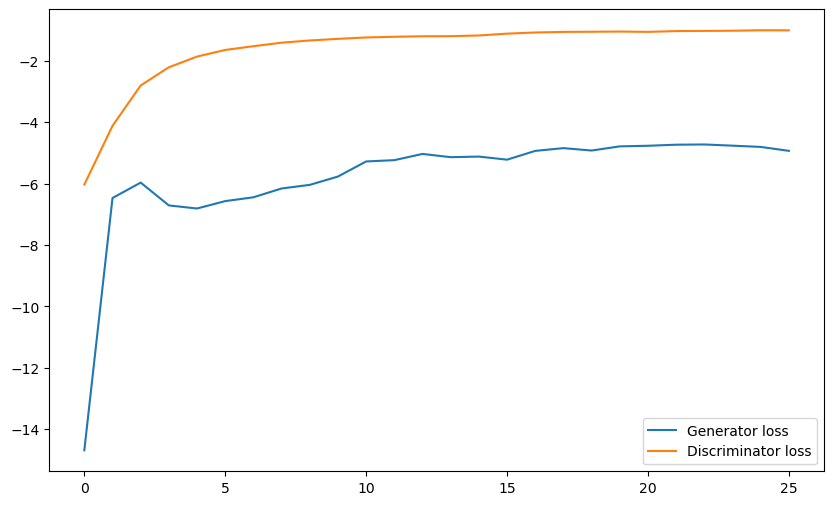

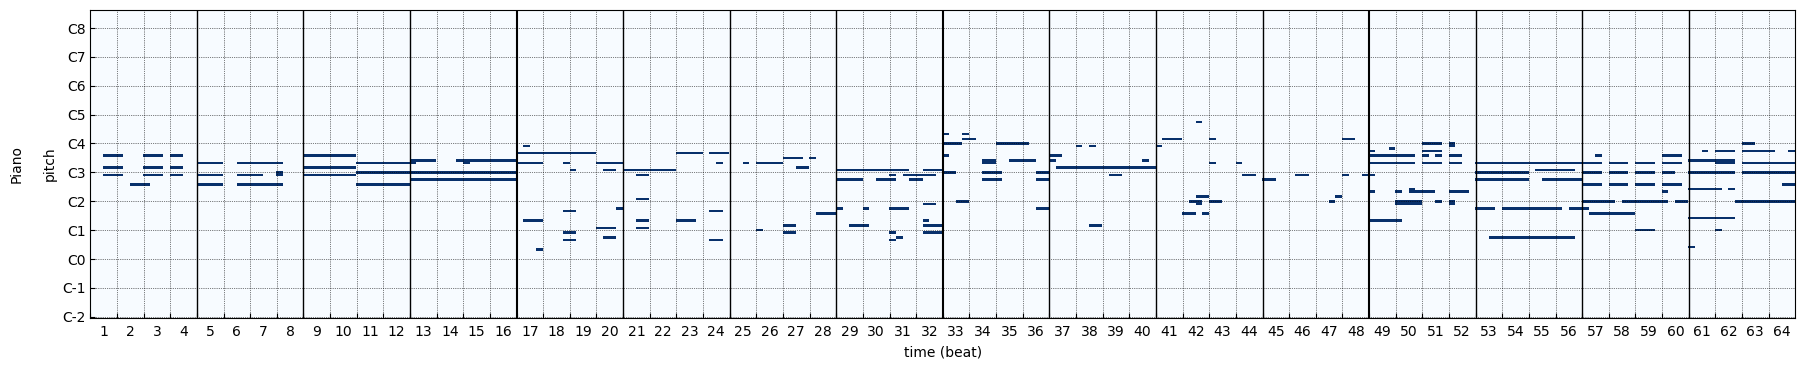

TRAIN Epoch [27/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.65it/s]




disc: -0.9870312
(fake: 5.2641206
(real: -6.455541
(grad_p: 0.20438951
gen: -5.093507


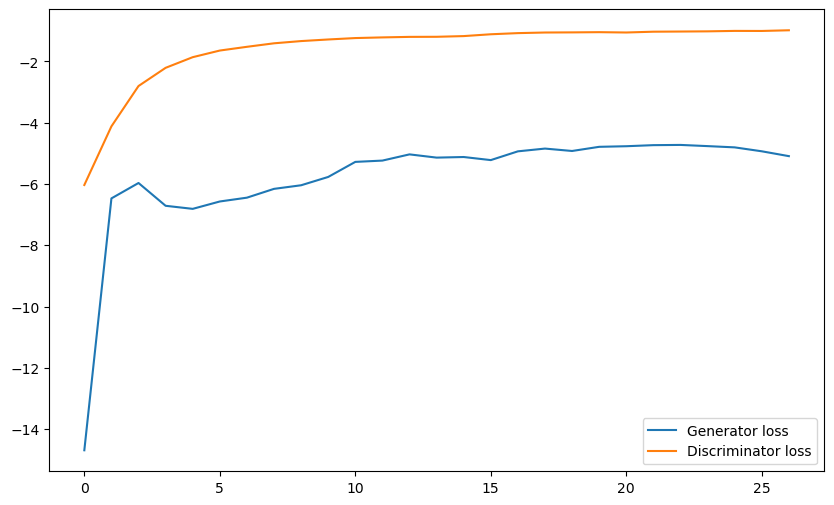

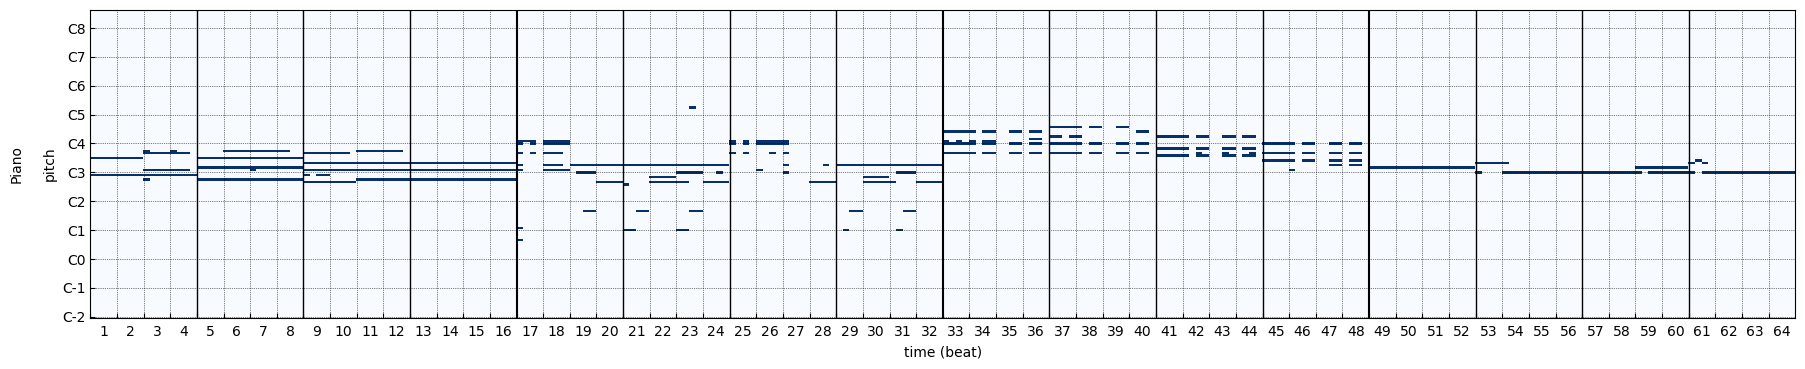

TRAIN Epoch [28/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -0.9632751
(fake: 5.161087
(real: -6.3298845
(grad_p: 0.20552266
gen: -4.996216


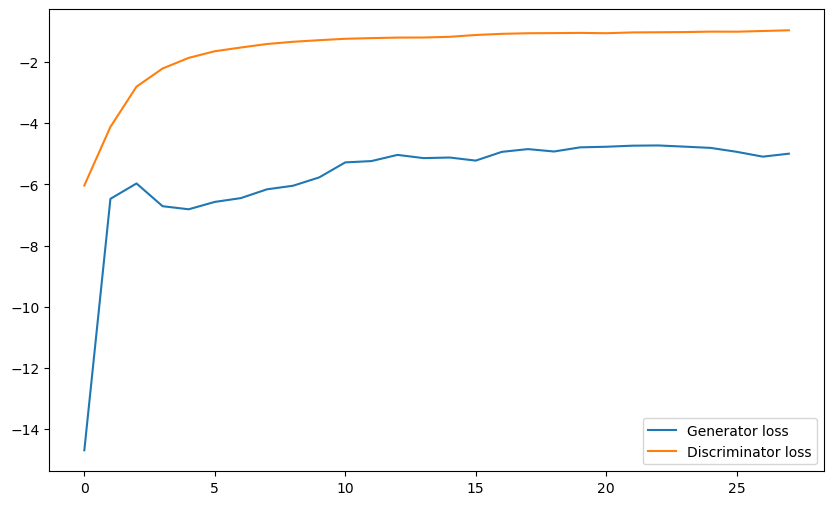

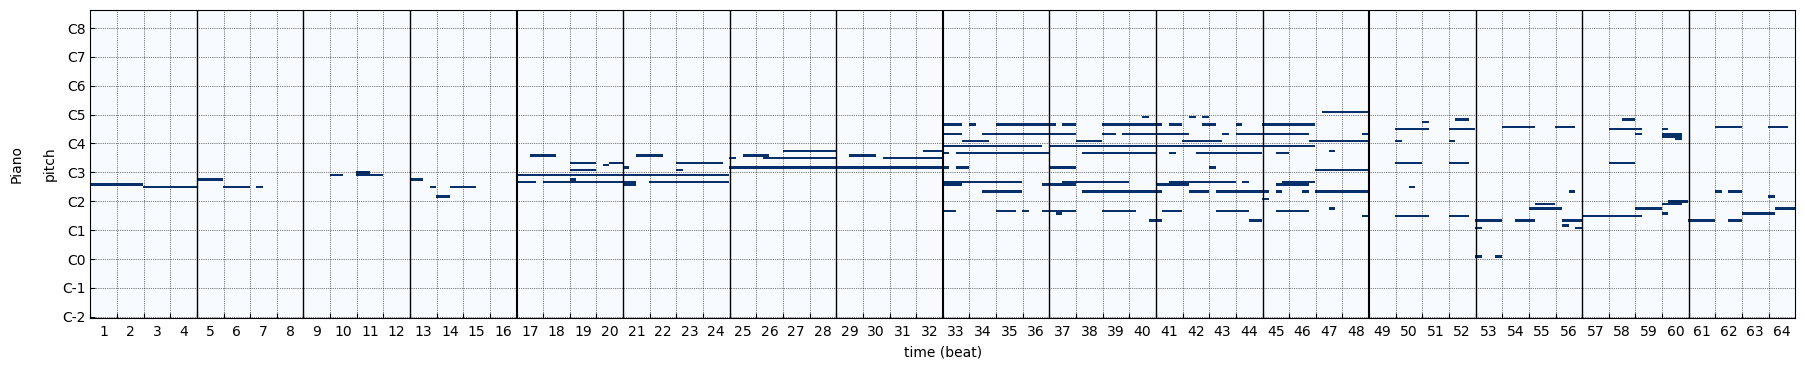

TRAIN Epoch [29/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.65it/s]




disc: -0.9609934
(fake: 5.179849
(real: -6.340917
(grad_p: 0.20007451
gen: -5.0174694


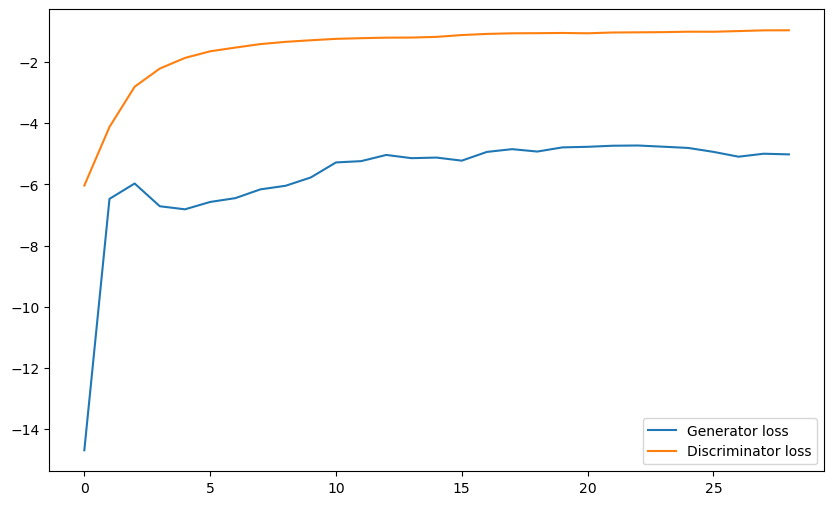

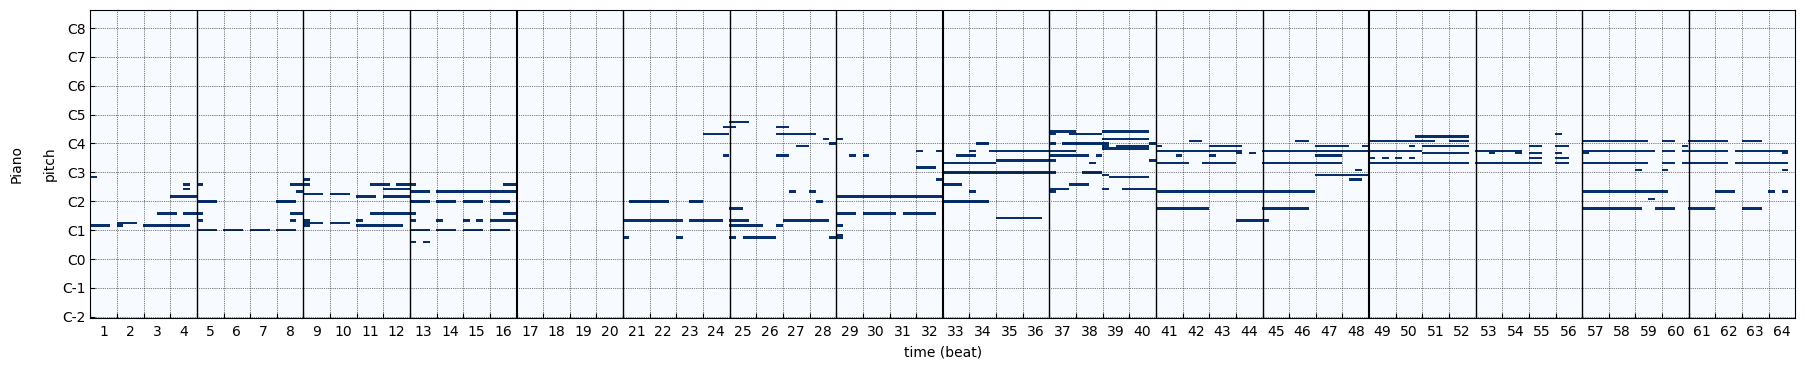

TRAIN Epoch [30/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.65it/s]




disc: -0.9436042
(fake: 5.2267275
(real: -6.3682117
(grad_p: 0.19787984
gen: -5.062848


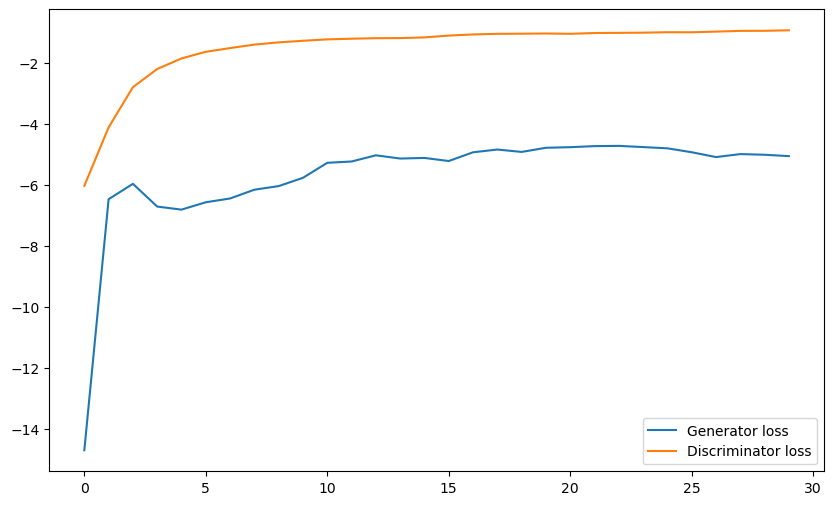

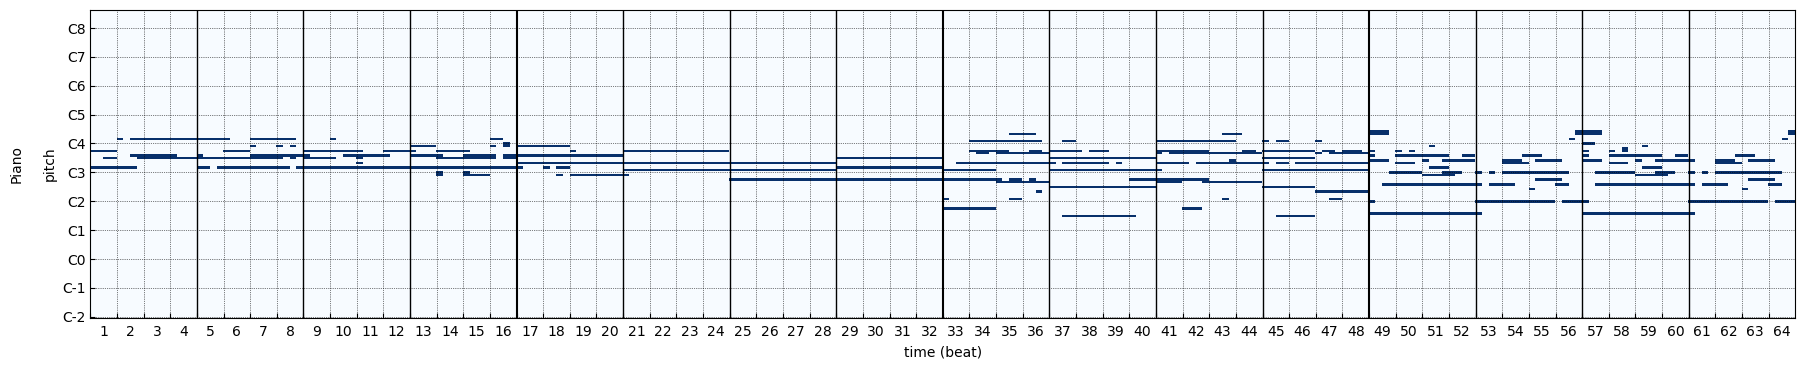

TRAIN Epoch [31/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.65it/s]




disc: -0.9363627
(fake: 5.385054
(real: -6.518123
(grad_p: 0.19670653
gen: -5.2252874


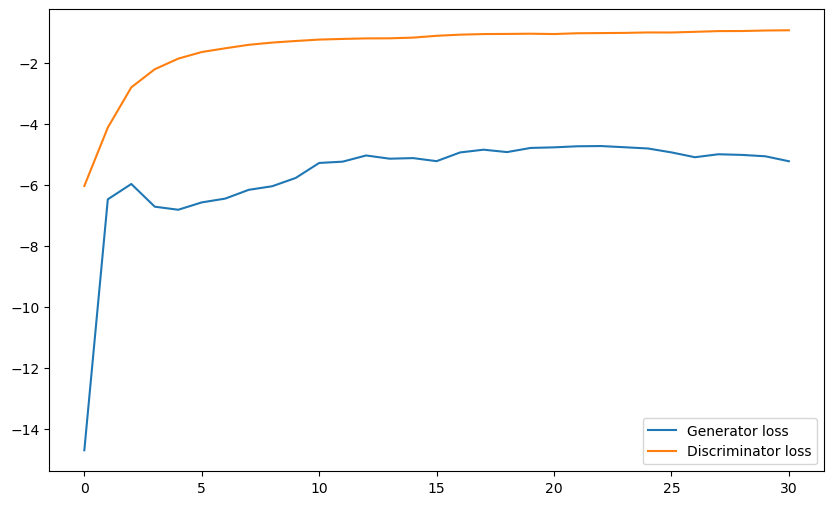

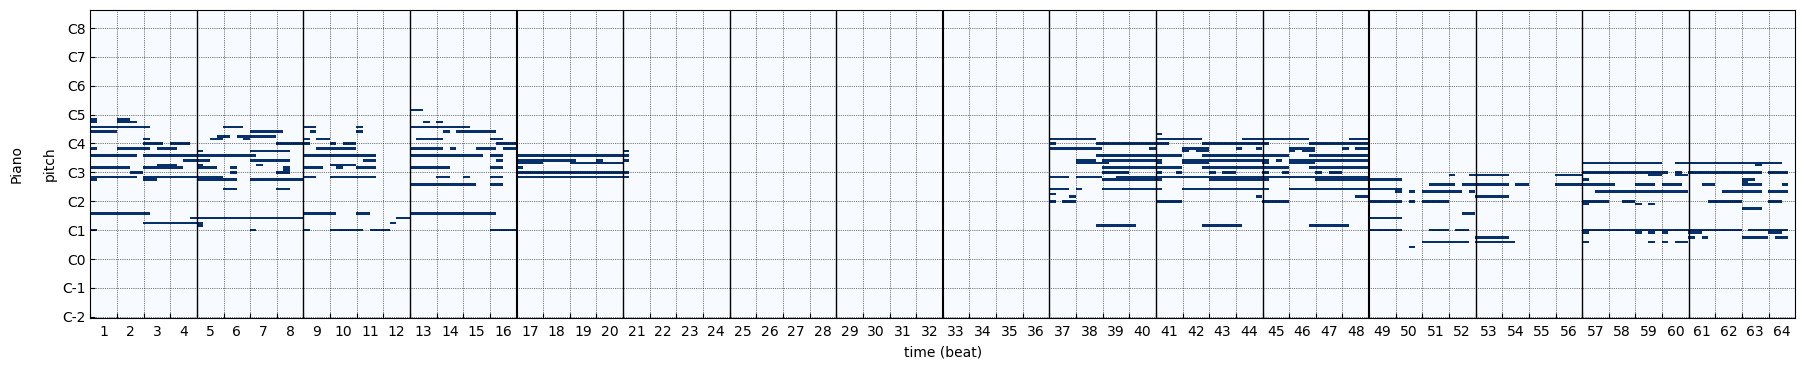

TRAIN Epoch [32/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.65it/s]




disc: -0.9303256
(fake: 5.3398075
(real: -6.471847
(grad_p: 0.2017141
gen: -5.1814466


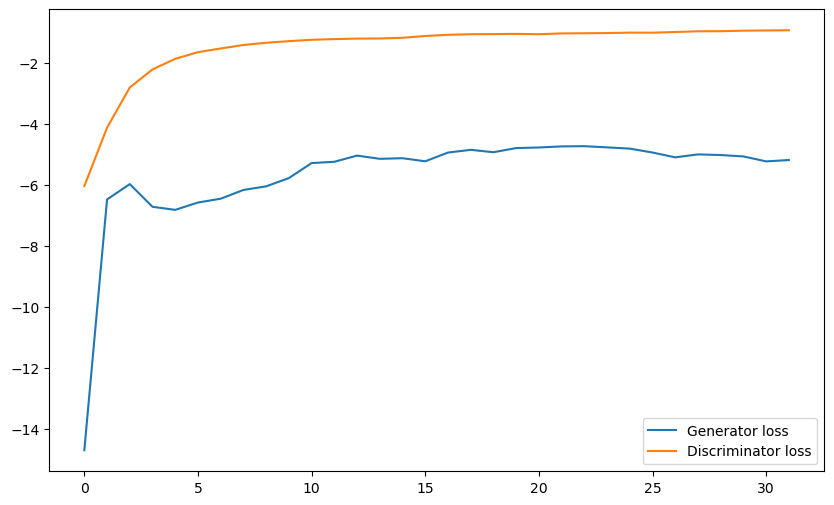

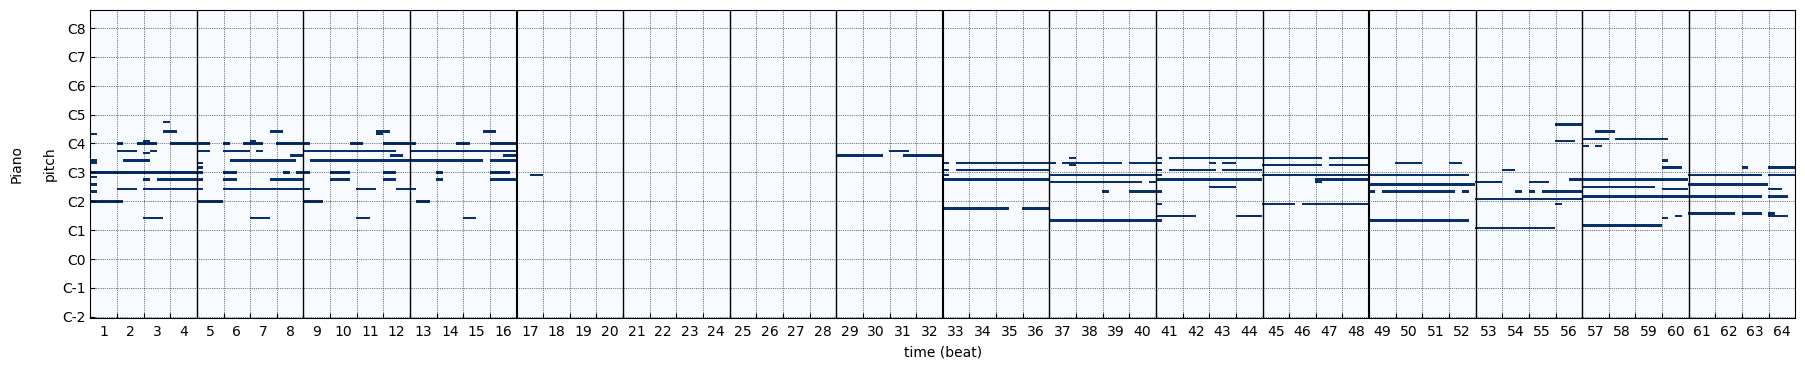

TRAIN Epoch [33/50]: 100%|██████████| 1493/1493 [09:23<00:00,  2.65it/s]




disc: -0.91566086
(fake: 5.3540316
(real: -6.4726744
(grad_p: 0.20298141
gen: -5.1937404


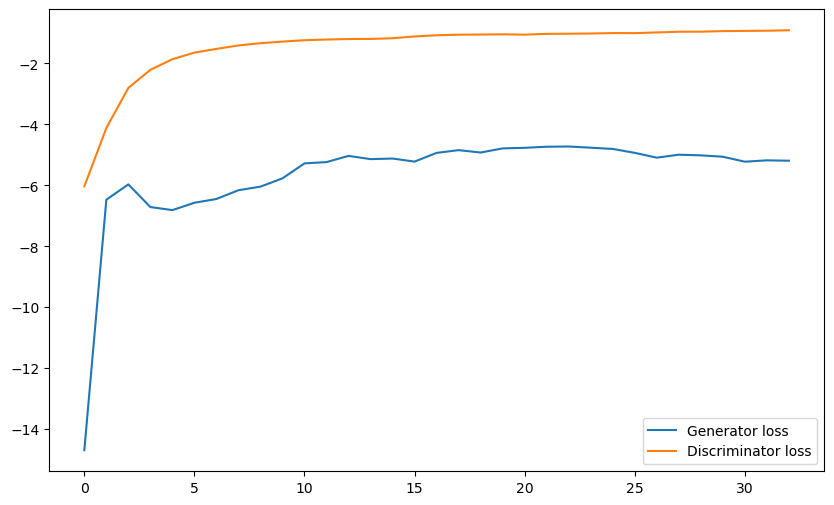

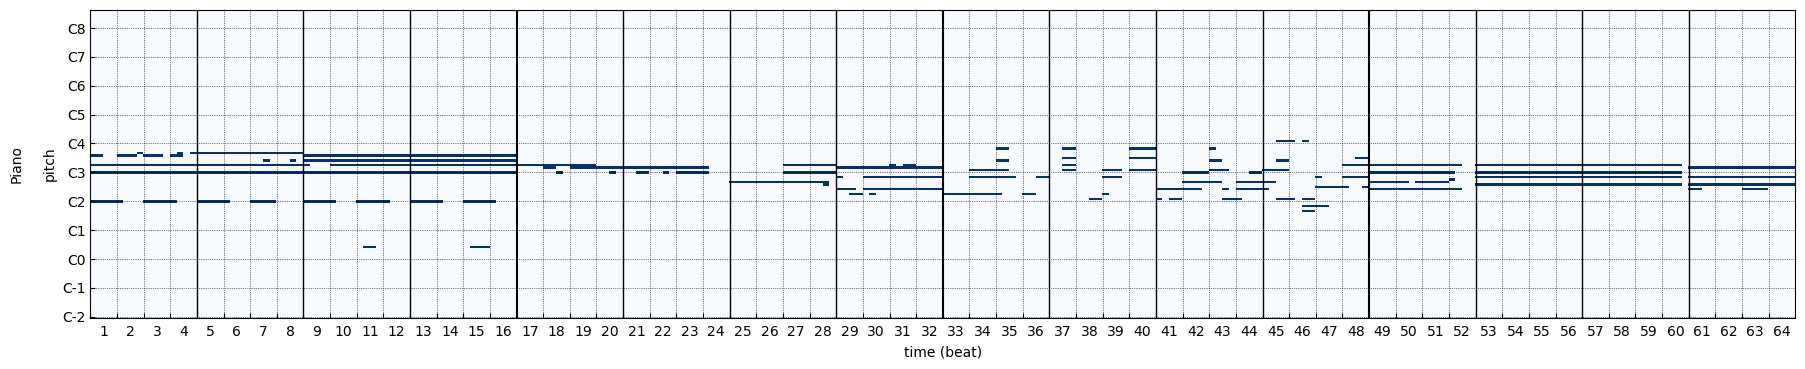

TRAIN Epoch [34/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.65it/s]




disc: -0.91088146
(fake: 5.532117
(real: -6.640796
(grad_p: 0.19779801
gen: -5.3761716


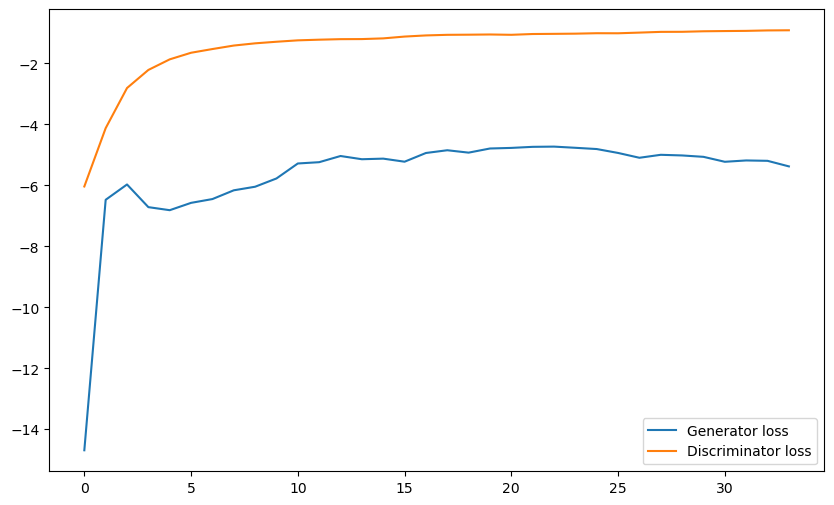

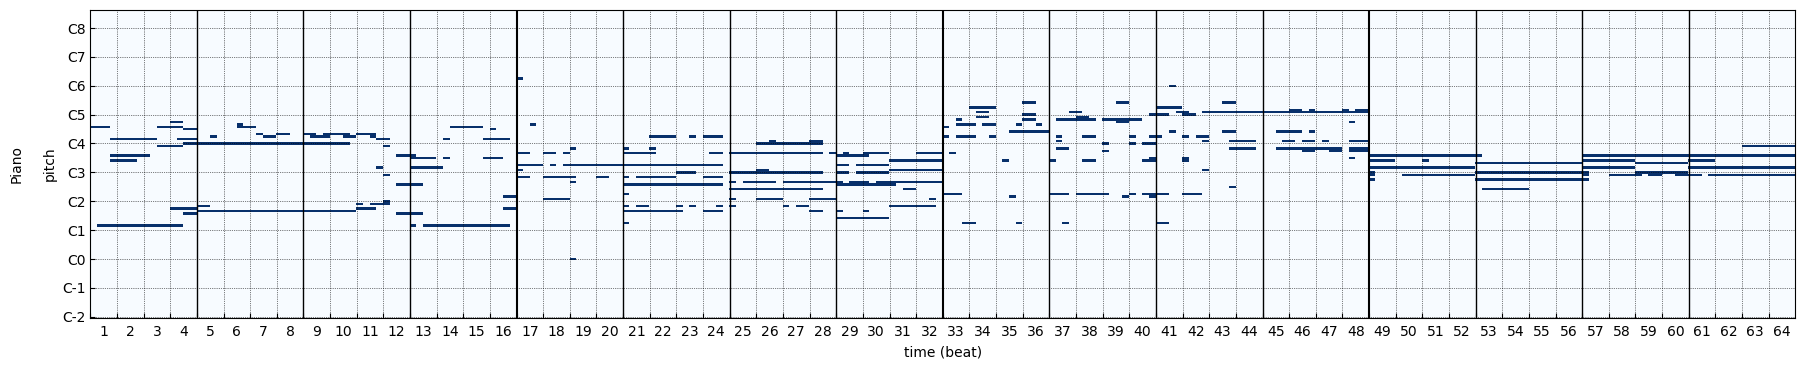

TRAIN Epoch [35/50]: 100%|██████████| 1493/1493 [09:23<00:00,  2.65it/s]




disc: -0.90439194
(fake: 5.5607586
(real: -6.65927
(grad_p: 0.19411953
gen: -5.401141


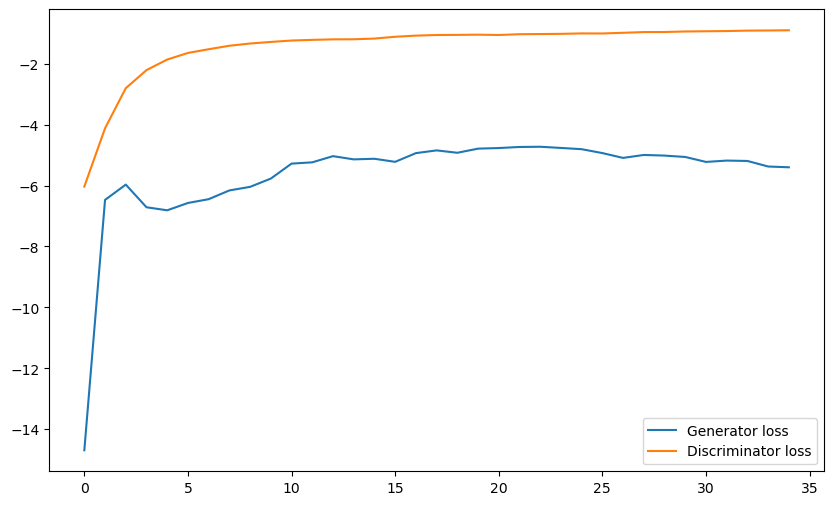

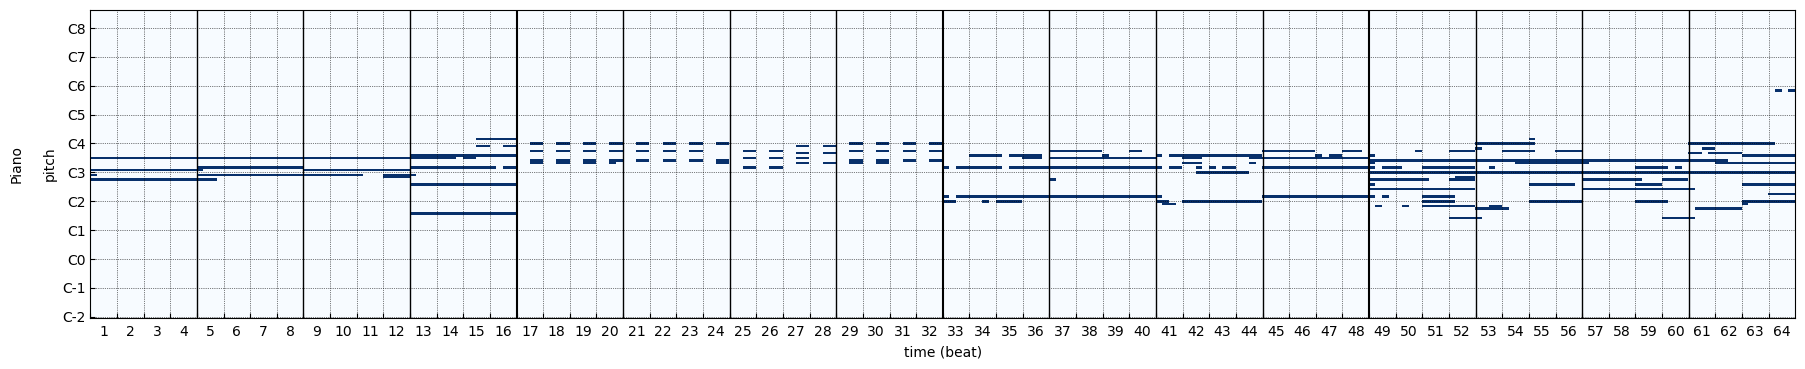

TRAIN Epoch [36/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.65it/s]




disc: -0.89078575
(fake: 5.459695
(real: -6.5466847
(grad_p: 0.19620371
gen: -5.306614


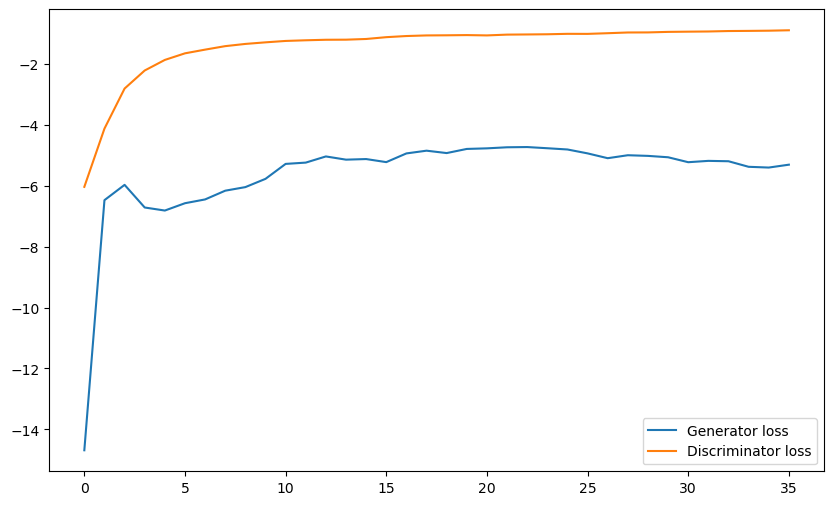

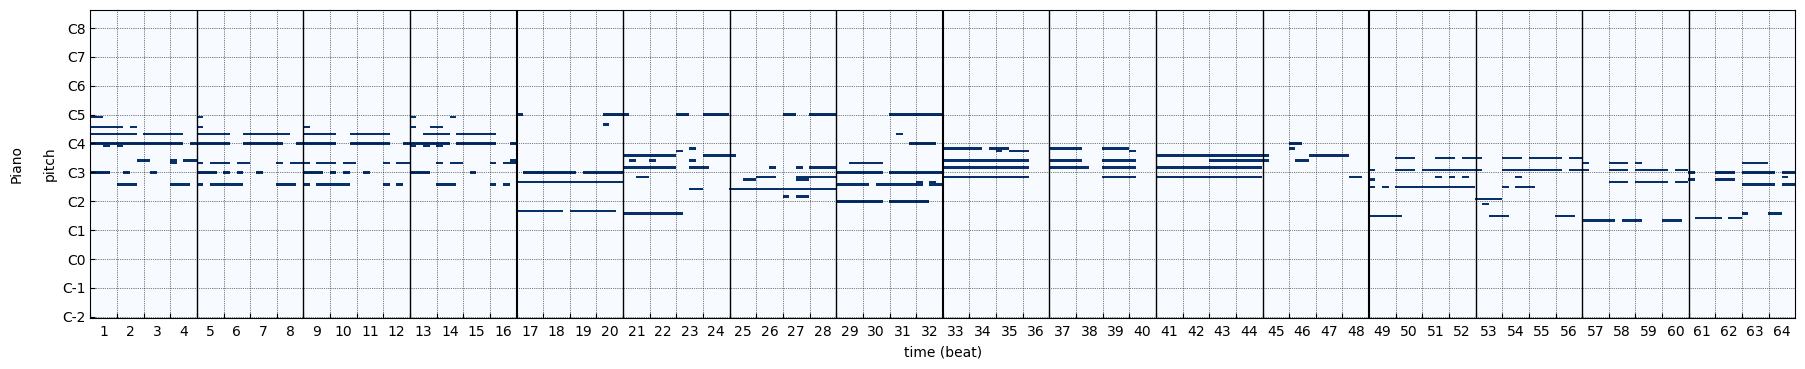

TRAIN Epoch [37/50]: 100%|██████████| 1493/1493 [09:23<00:00,  2.65it/s]




disc: -0.8839596
(fake: 5.6989307
(real: -6.77507
(grad_p: 0.19217958
gen: -5.544887


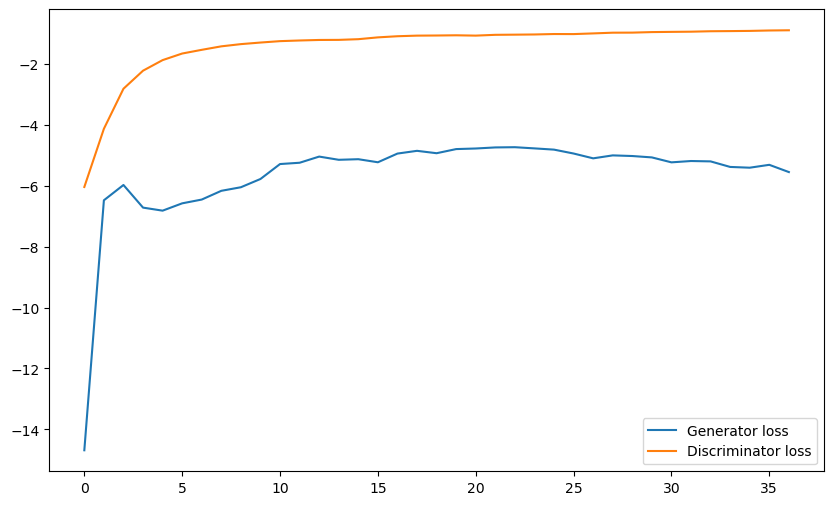

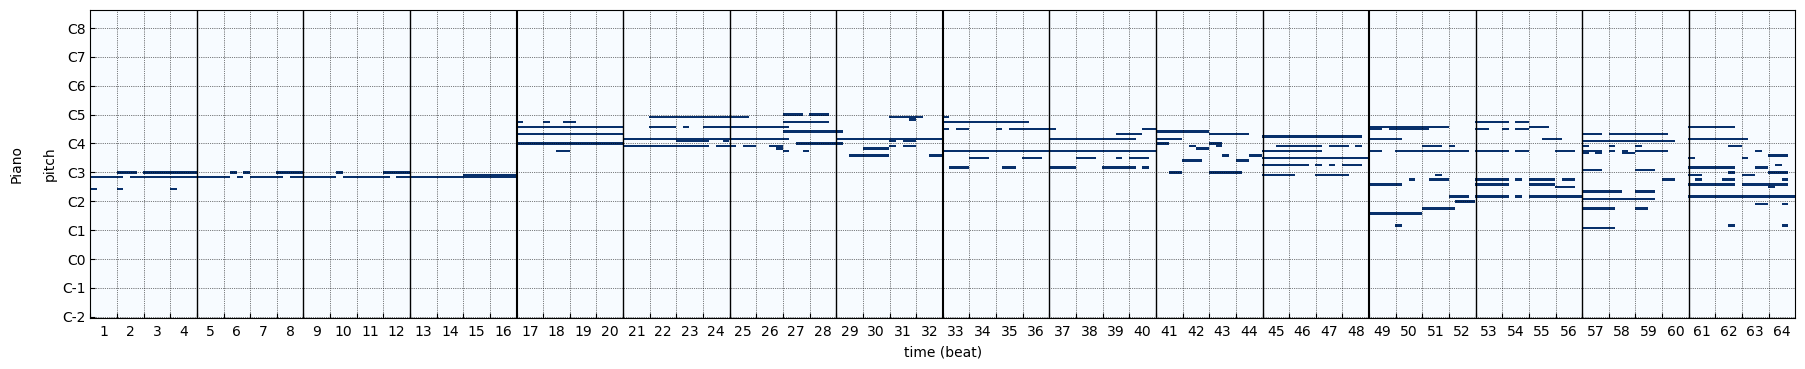

TRAIN Epoch [38/50]: 100%|██████████| 1493/1493 [09:23<00:00,  2.65it/s]




disc: -0.8799906
(fake: 5.486192
(real: -6.557207
(grad_p: 0.19102405
gen: -5.3299365


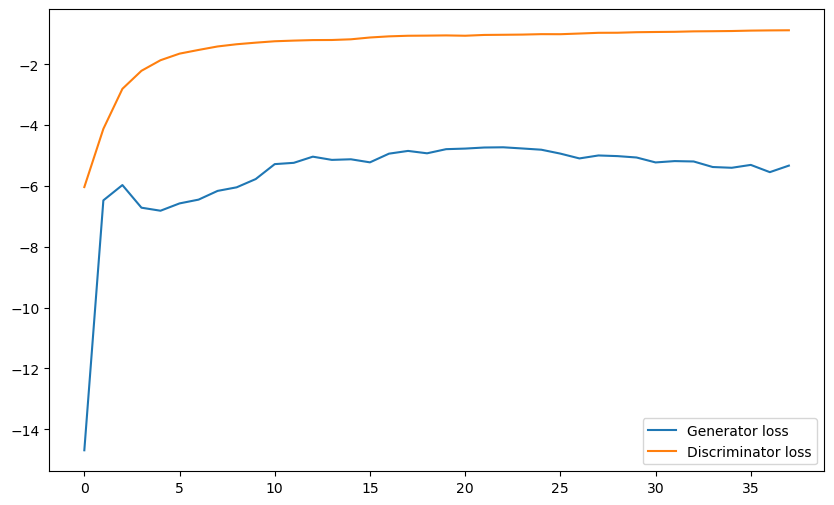

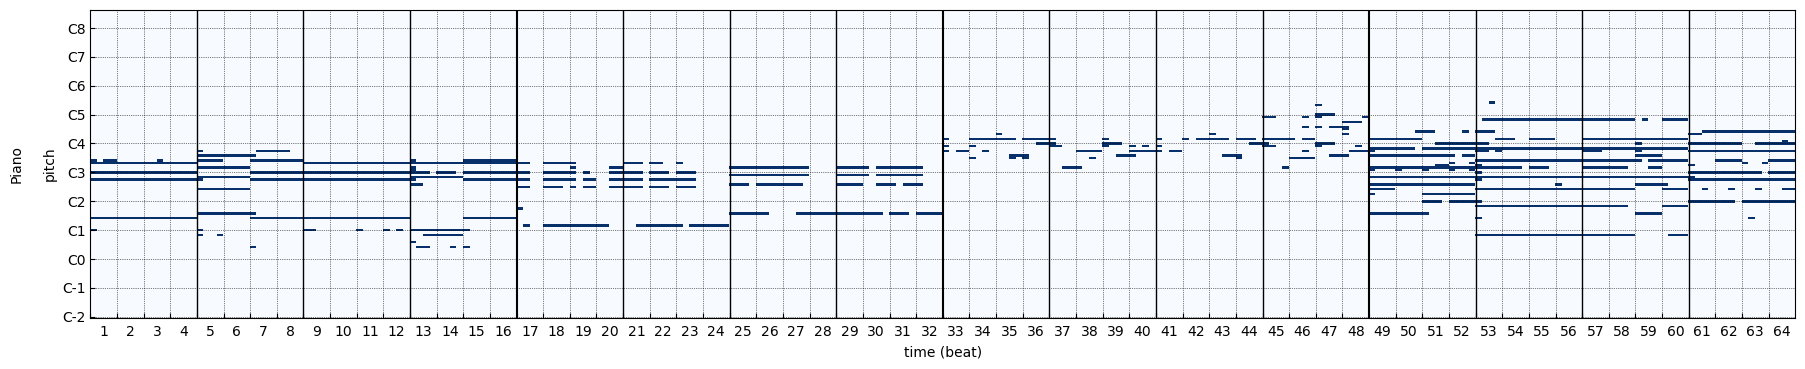

TRAIN Epoch [39/50]: 100%|██████████| 1493/1493 [09:23<00:00,  2.65it/s]




disc: -0.8719016
(fake: 5.2053294
(real: -6.2671294
(grad_p: 0.18989836
gen: -5.0517945


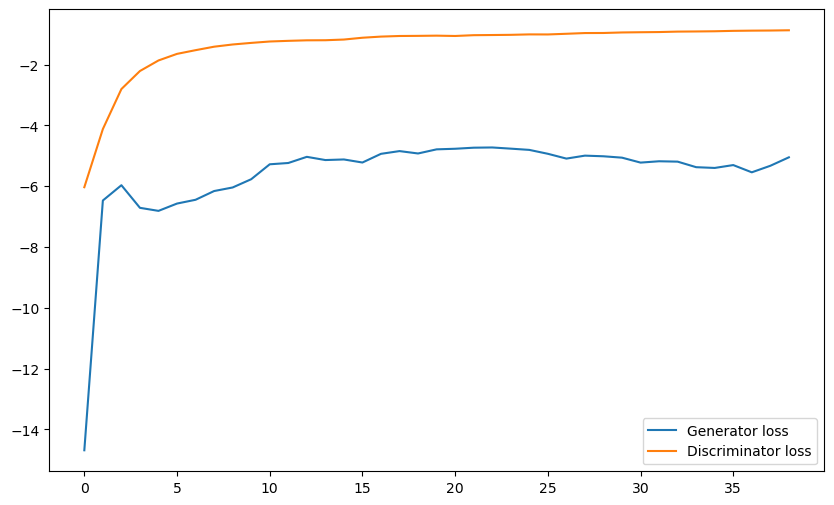

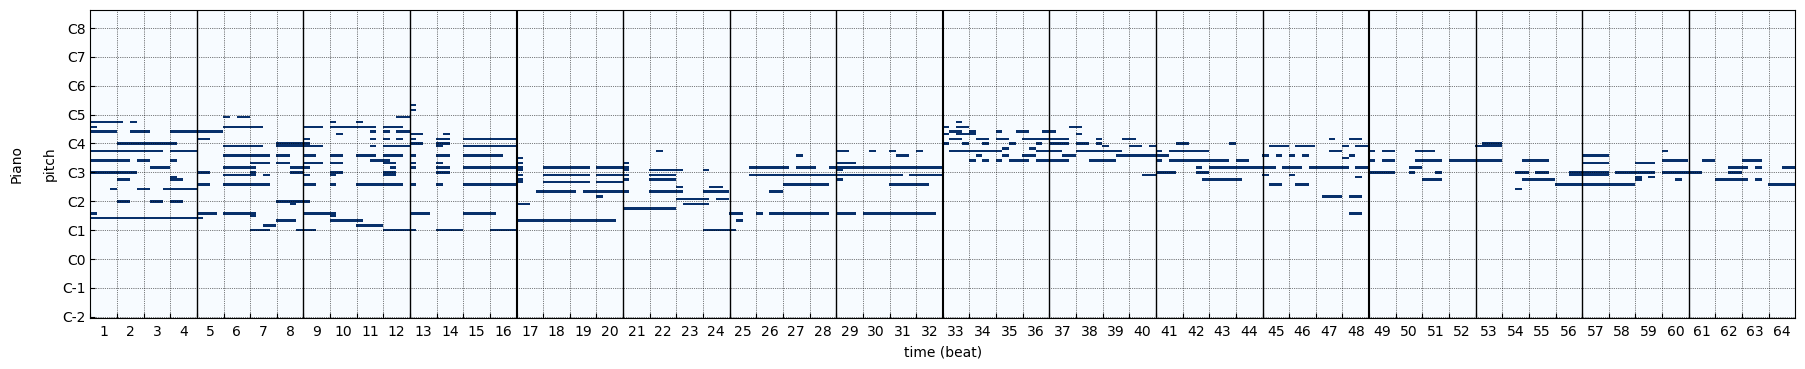

TRAIN Epoch [40/50]: 100%|██████████| 1493/1493 [09:23<00:00,  2.65it/s]




disc: -0.86955726
(fake: 5.404105
(real: -6.4620113
(grad_p: 0.18834947
gen: -5.2512374


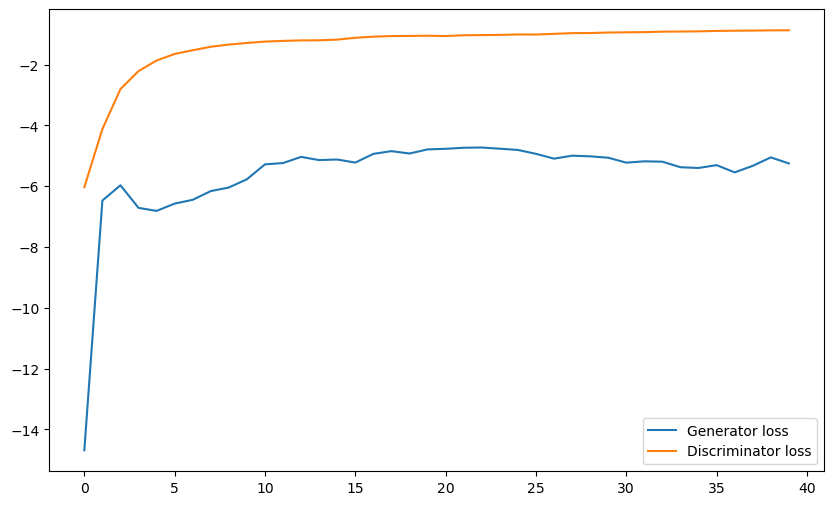

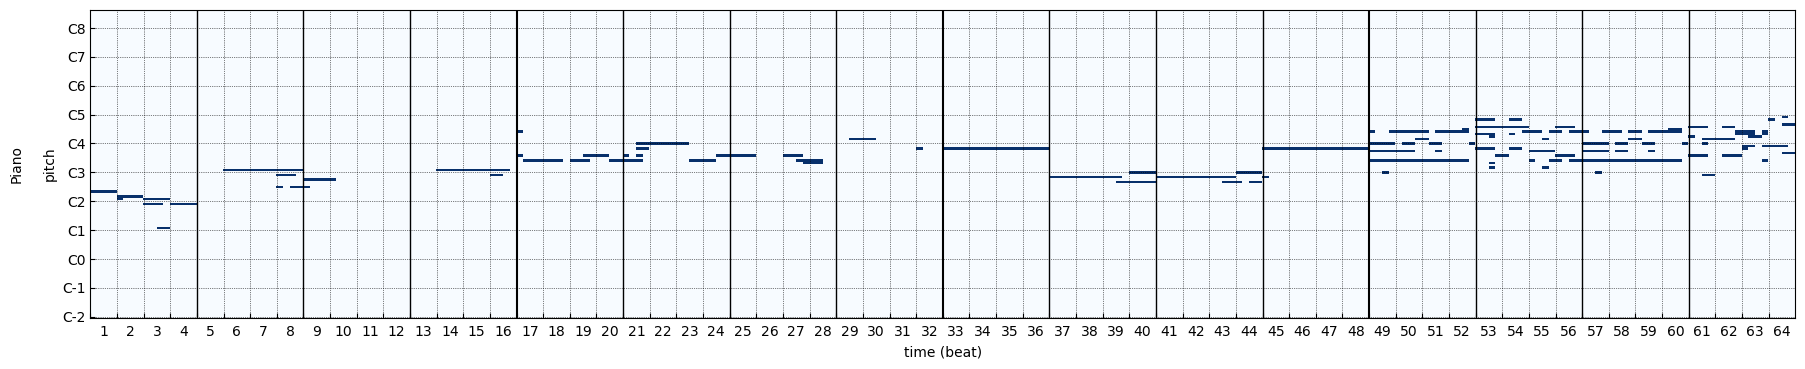

TRAIN Epoch [41/50]: 100%|██████████| 1493/1493 [09:23<00:00,  2.65it/s]




disc: -0.87795293
(fake: 5.4278464
(real: -6.4950924
(grad_p: 0.18929349
gen: -5.2734694


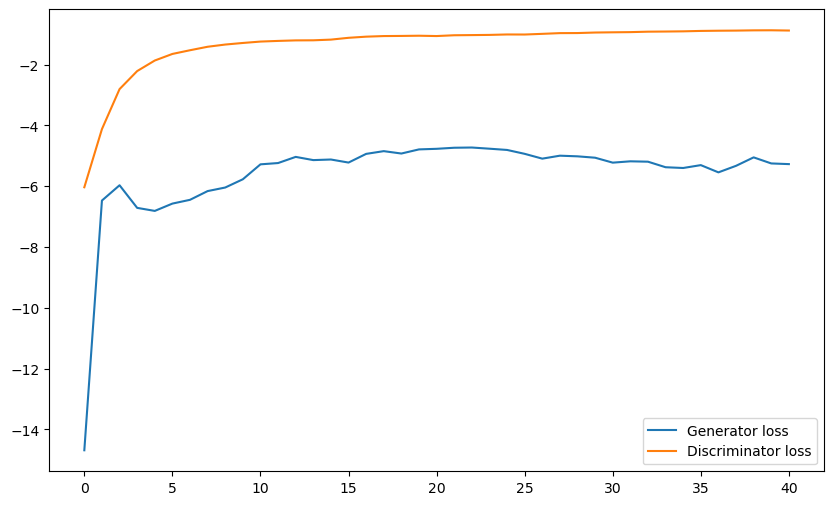

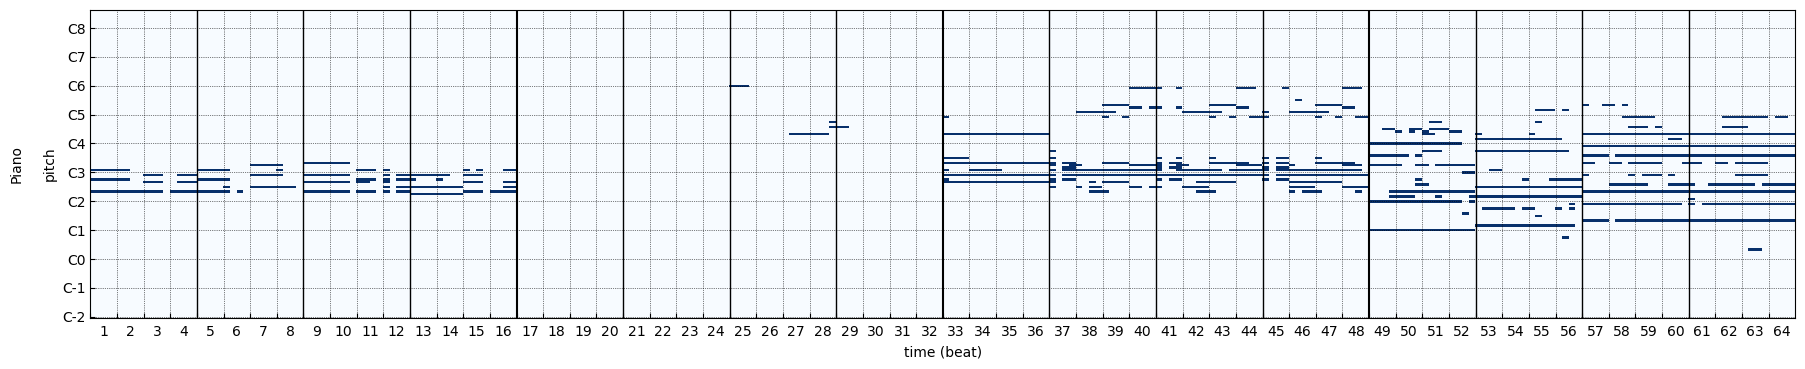

TRAIN Epoch [42/50]: 100%|██████████| 1493/1493 [09:23<00:00,  2.65it/s]




disc: -0.87983537
(fake: 5.289368
(real: -6.3605433
(grad_p: 0.19133924
gen: -5.136537


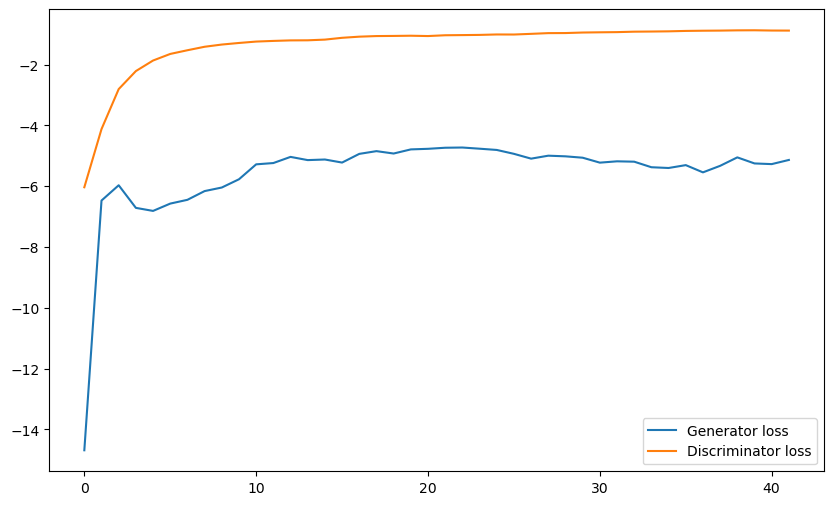

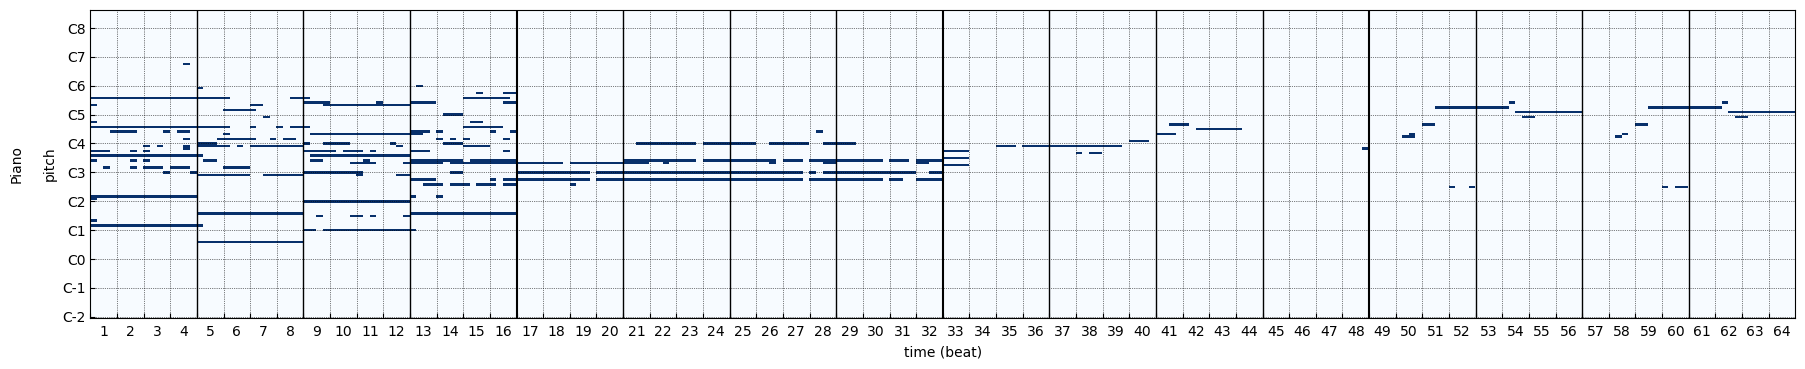

TRAIN Epoch [43/50]: 100%|██████████| 1493/1493 [09:23<00:00,  2.65it/s]




disc: -0.84337854
(fake: 5.2040544
(real: -6.228338
(grad_p: 0.18090497
gen: -5.0554156


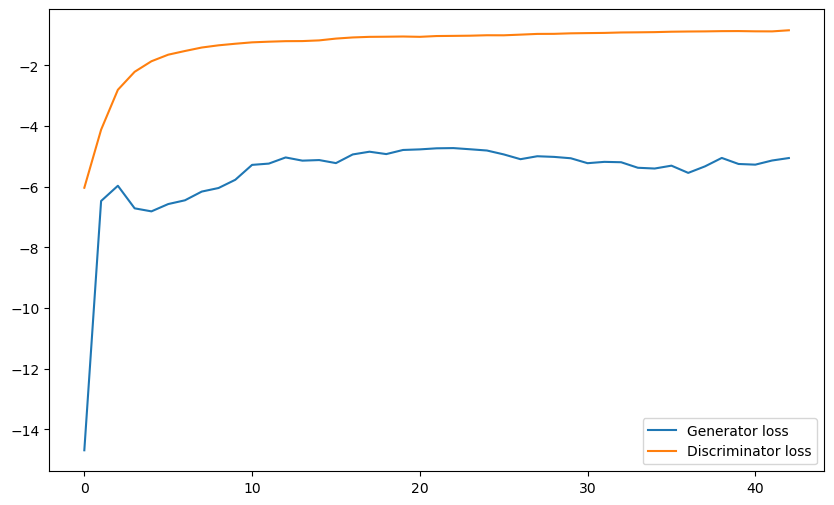

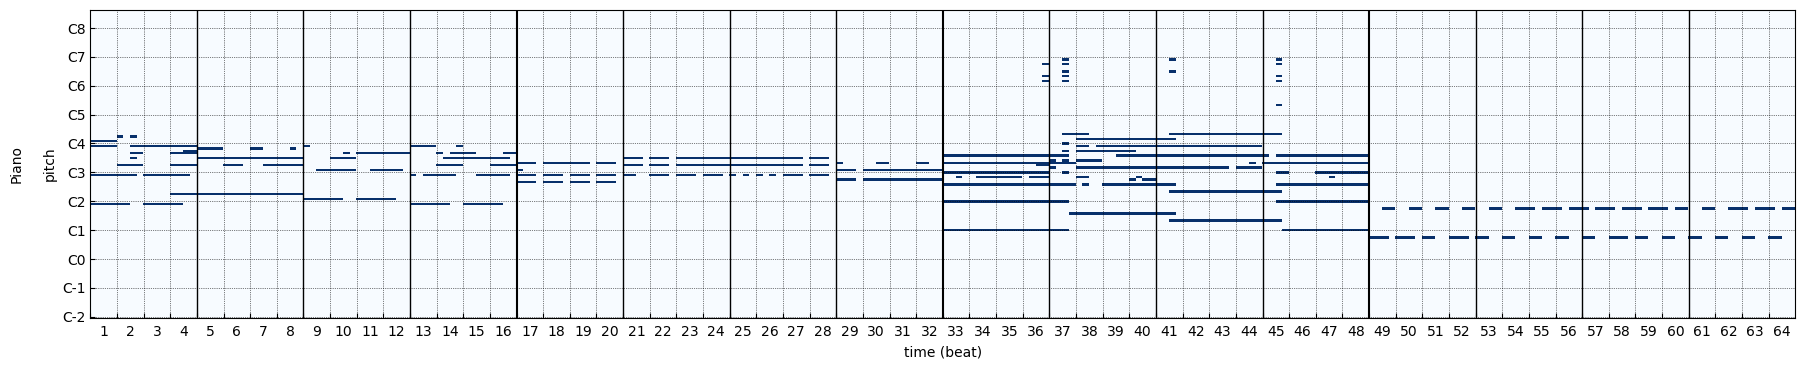

TRAIN Epoch [44/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -0.8386856
(fake: 5.2051816
(real: -6.225741
(grad_p: 0.18187422
gen: -5.052384


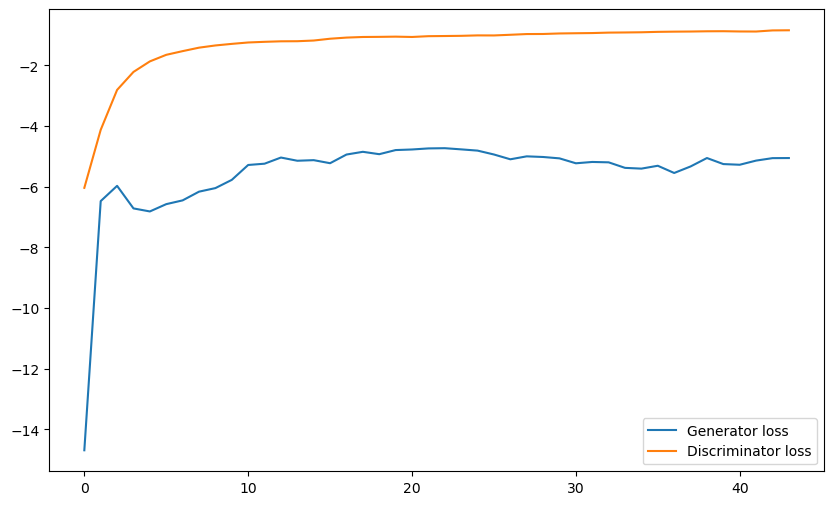

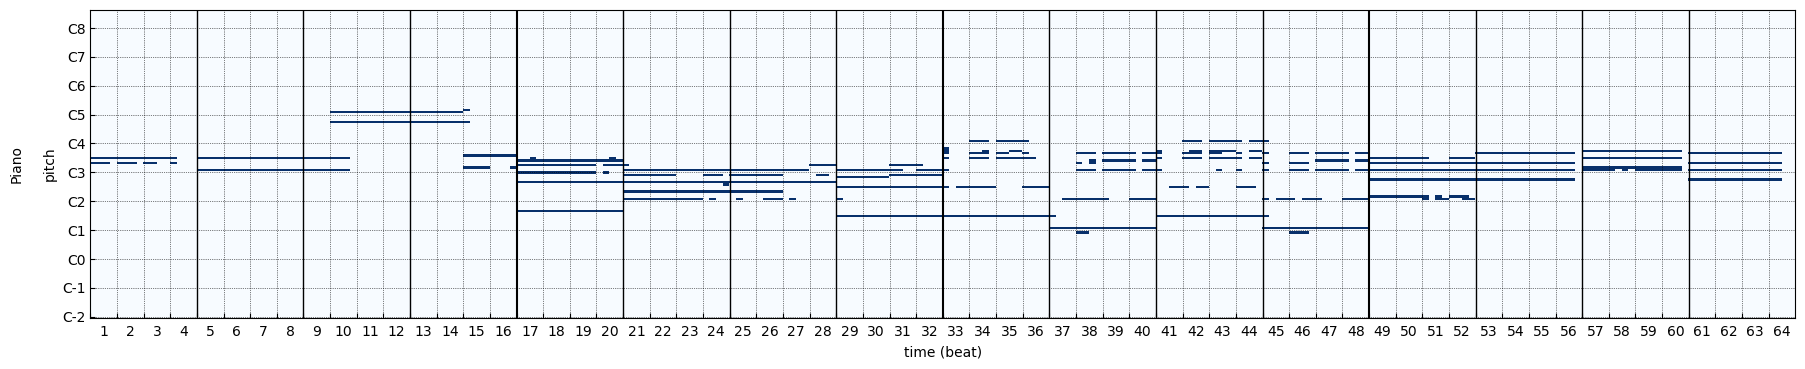

TRAIN Epoch [45/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -0.8285066
(fake: 5.380009
(real: -6.392688
(grad_p: 0.18417227
gen: -5.2313867


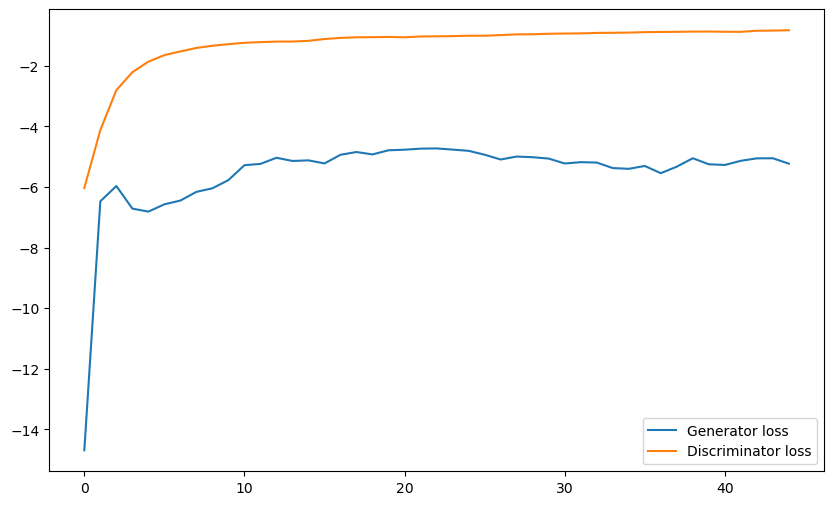

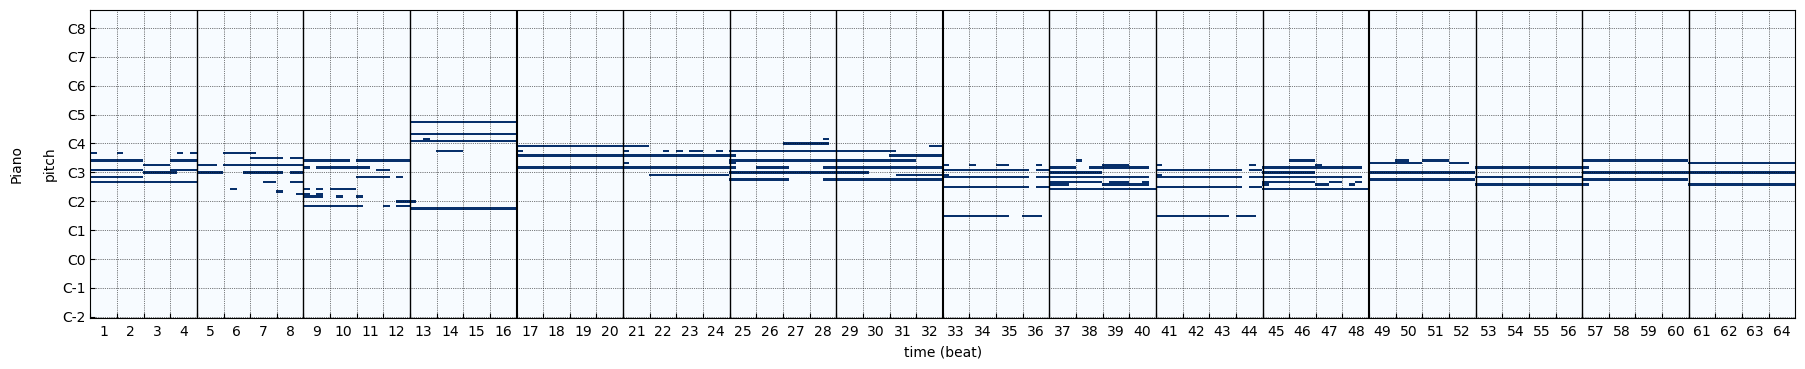

TRAIN Epoch [46/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -0.8217524
(fake: 5.344673
(real: -6.341615
(grad_p: 0.17518875
gen: -5.1964965


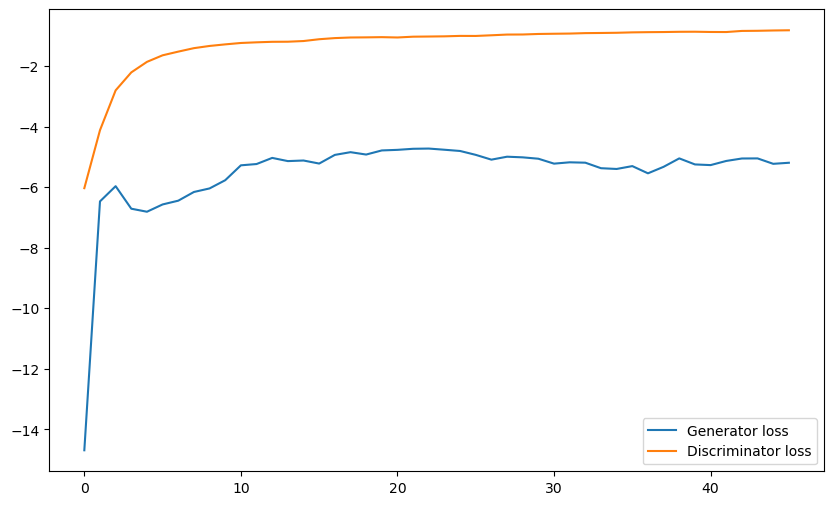

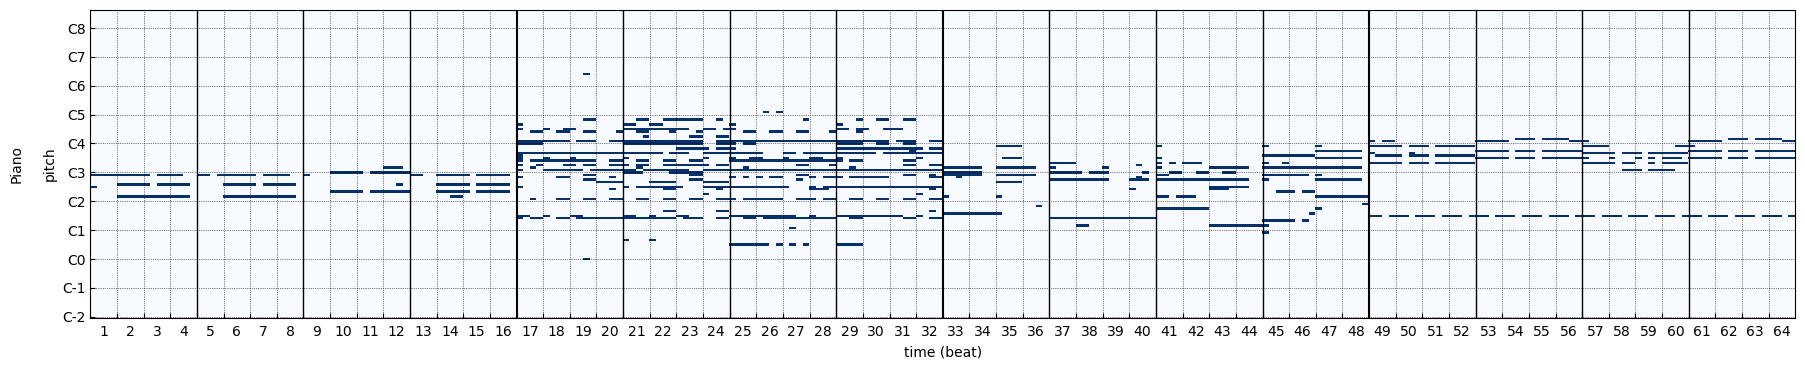

TRAIN Epoch [47/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -0.8139317
(fake: 5.412727
(real: -6.403788
(grad_p: 0.17712928
gen: -5.2676554


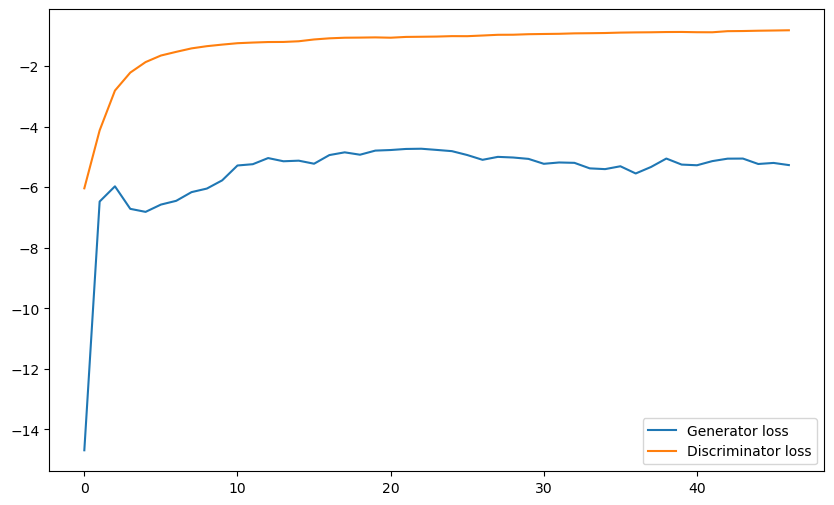

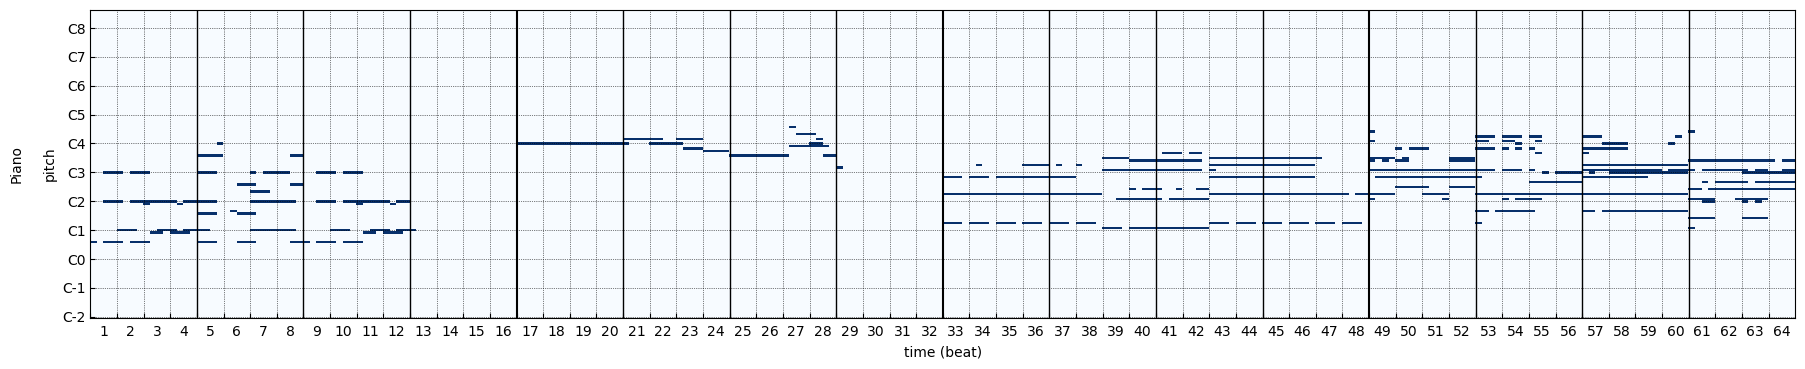

TRAIN Epoch [48/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -0.8038128
(fake: 5.3790917
(real: -6.3565545
(grad_p: 0.17365013
gen: -5.2352934


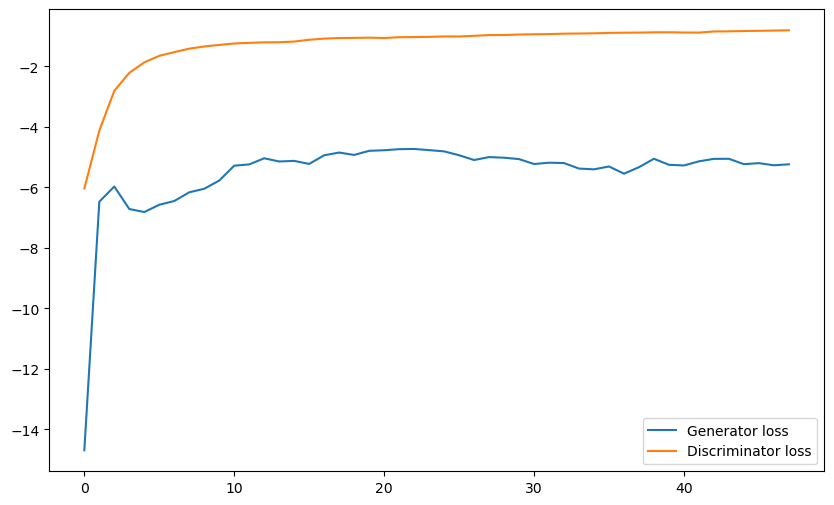

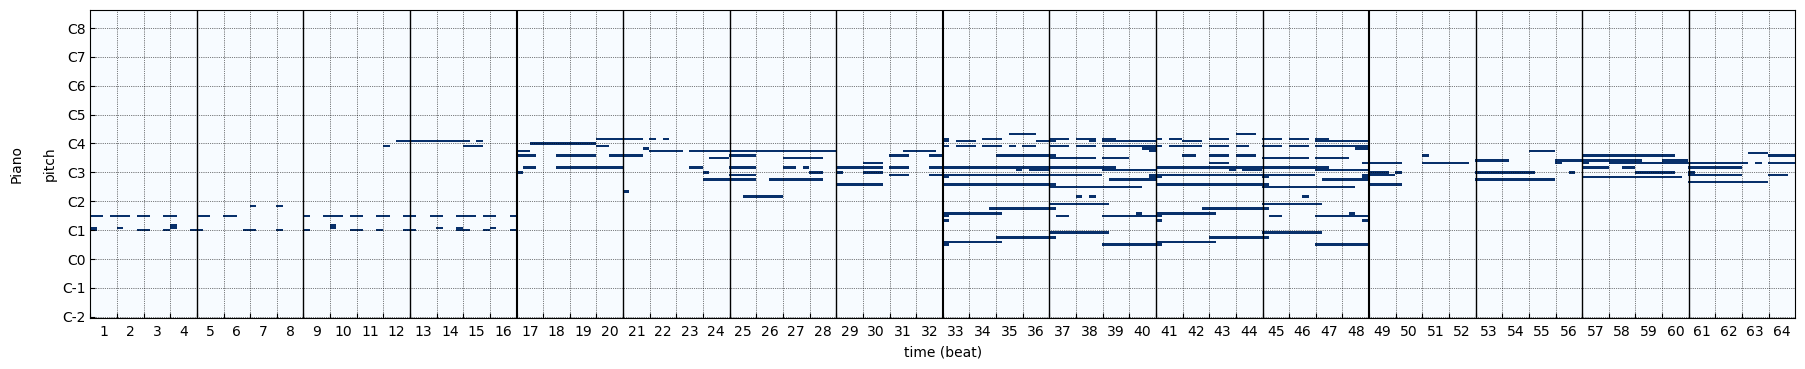

TRAIN Epoch [49/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -0.7931898
(fake: 5.4986606
(real: -6.4639106
(grad_p: 0.17206043
gen: -5.3585896


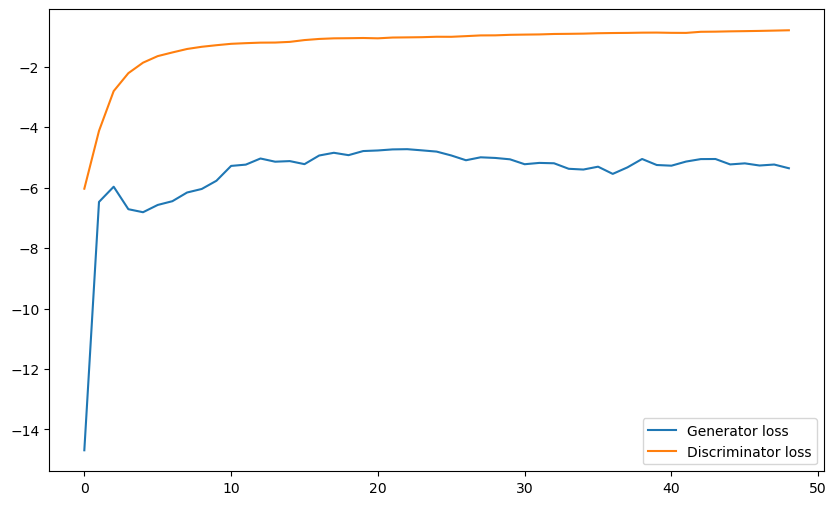

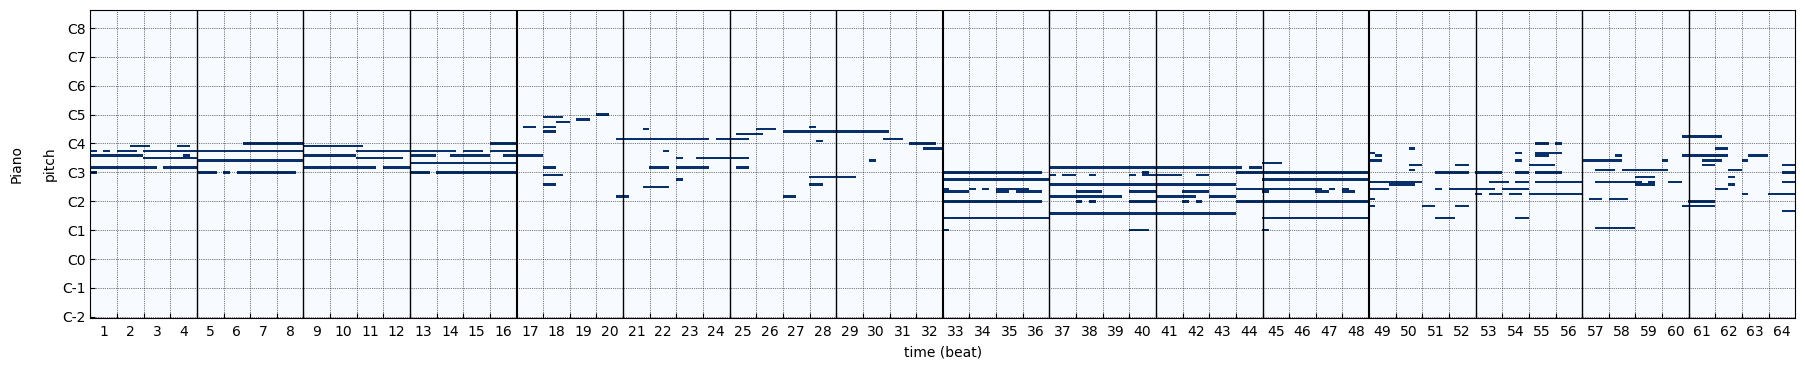

TRAIN Epoch [50/50]: 100%|██████████| 1493/1493 [09:24<00:00,  2.64it/s]




disc: -0.7693072
(fake: 5.4664145
(real: -6.4068885
(grad_p: 0.17116661
gen: -5.3241982


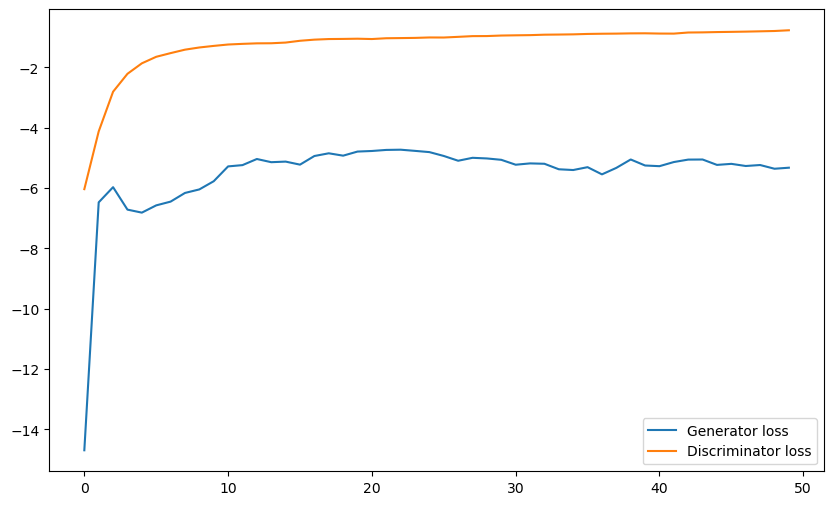

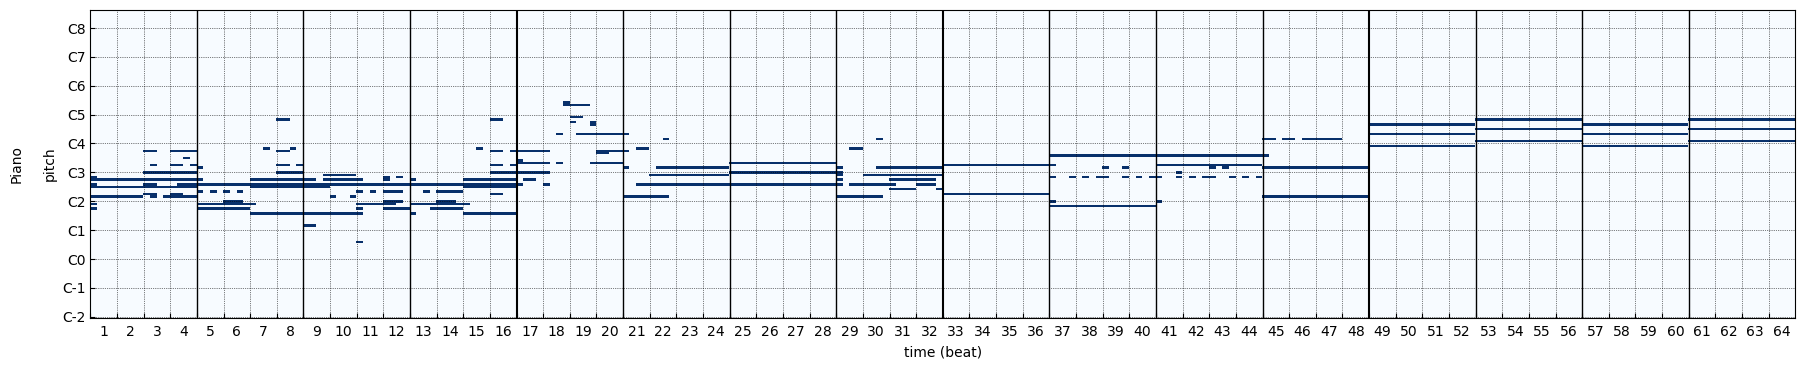

In [22]:
generator.to(device)
discriminator.to(device)

g_loss, d_loss, d_fake_loss, d_real_loss, d_gp = train(dataloader, epochs, generator, discriminator, batch_size, latent_dim, device, add_noise)

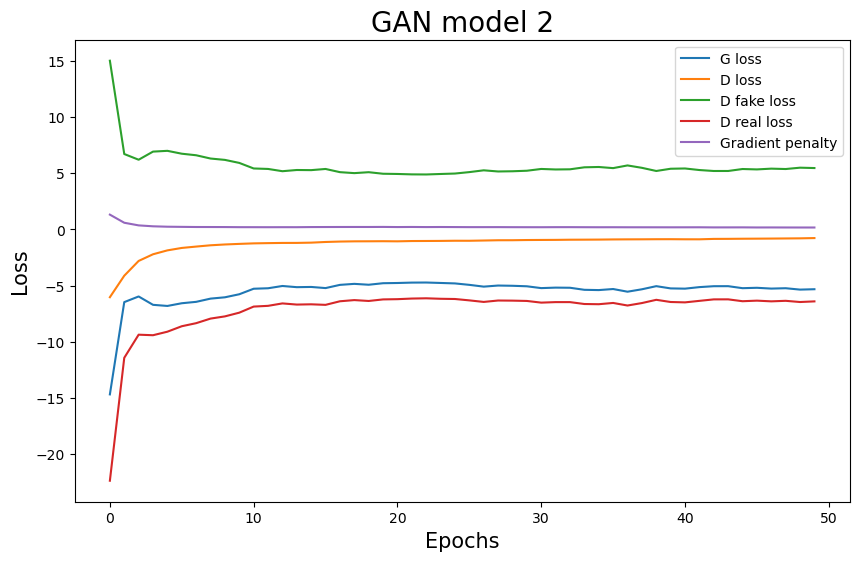

In [23]:
plt.figure(figsize=(10,6))
plt.plot(g_loss, label="G loss")
plt.plot(d_loss, label="D loss")
plt.plot(d_fake_loss, label="D fake loss")
plt.plot(d_real_loss, label="D real loss")
plt.plot(d_gp, label="Gradient penalty")
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.title("GAN model 2", fontsize = 20)
plt.legend()
plt.show()

In [24]:
### nell'ordine vanno info su:
### n_tracks, architecture, epochs, dataset, batch_size
np.save("losses/g_loss1paper50lpd64_8sps_cond_1_2", g_loss)
np.save("losses/d_loss1paper50lpd64_8sps_cond_1_2", d_loss)
np.save("losses/d_fake_loss1paper50lpd64_8sps_cond_1_2", d_fake_loss)
np.save("losses/d_real_loss1paper50lpd64_8sps_cond_1_2", d_real_loss)
np.save("losses/d_gp1paper50lpd64_8sps_cond_1_2", d_gp)

In [25]:
z = torch.randn(4, latent_dim, 1).to(device)
# dataset da shufflare
#dataset = dataset[torch.randperm(4)]

# generator.load_state_dict(torch.load("/content/drive/MyDrive/gen_alpha1.1.pt"))

#generator_music = Generator_paper2_all_s(latent_dim, n_tracks, beat_resolution, n_pitches)
#generator_music.load_state_dict(torch.load("GAN weights/gen1paper50midi64_1_1.pt", map_location=torch.device('cpu')))

generator.eval()

if CONDITIONED:
    with torch.no_grad():
        song_seed = np.arange(4) # index of the sample to continue
        x_prev = torch.from_numpy(data[song_seed, 0]).type(torch.FloatTensor).reshape(-1, n_tracks, 4*4*beat_resolution, n_pitches)
        generated_image = generator(z, x_prev.to(device)).detach().cpu().numpy() # size []
        #generated_image = generator_music(z, x_prev.to(device)).detach().cpu().numpy() # size []
else:
    with torch.no_grad():
        generated_image = generator(z).detach().cpu().numpy()
        #generated_image = generator_music(z).detach().cpu().numpy()

print(generated_image.shape)

(4, 1, 64, 84)


In [ ]:
'''z = torch.randn(4, latent_dim, 1).to(device)
print(z.shape)

# generator.load_state_dict(torch.load("/content/drive/MyDrive/gen_alpha1.1.pt"))

#generator_music = Generator_paper2_all_s(latent_dim, n_tracks, beat_resolution, n_pitches)
#generator_music.load_state_dict(torch.load("GAN weights/gen1paper50midi64_1_1.pt", map_location=torch.device('cpu')))

generator.eval()

if CONDITIONED:
    with torch.no_grad():
        song_seed = 0 # index of the sample to continue
        generated_image = generator(z, dataset[song_seed, 0].to(device)).detach().cpu().numpy() # size []
else:
    with torch.no_grad():
        generated_image = generator(z).detach().cpu().numpy()

print(generated_image.shape)'''

-0.018862048
1.0


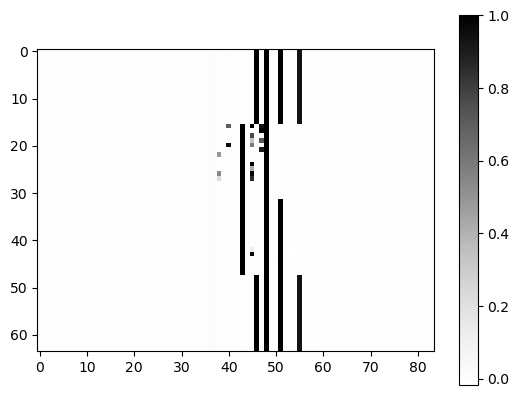

In [26]:
plt.imshow(generated_image[1, 0, :, :], cmap='Greys')
plt.colorbar()

# print the range of values of the generated images
print(np.min(generated_image))
print(np.max(generated_image))

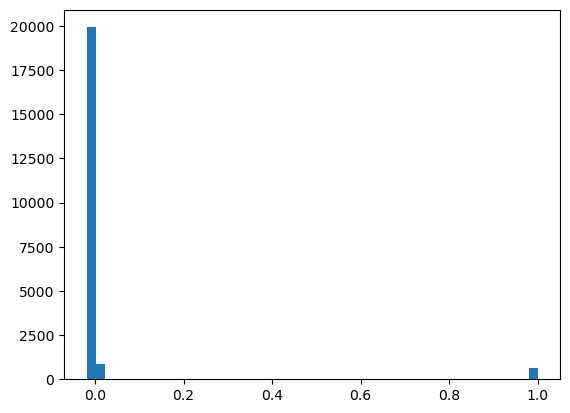

In [27]:
g = plt.hist(generated_image.flatten(), bins = 50)

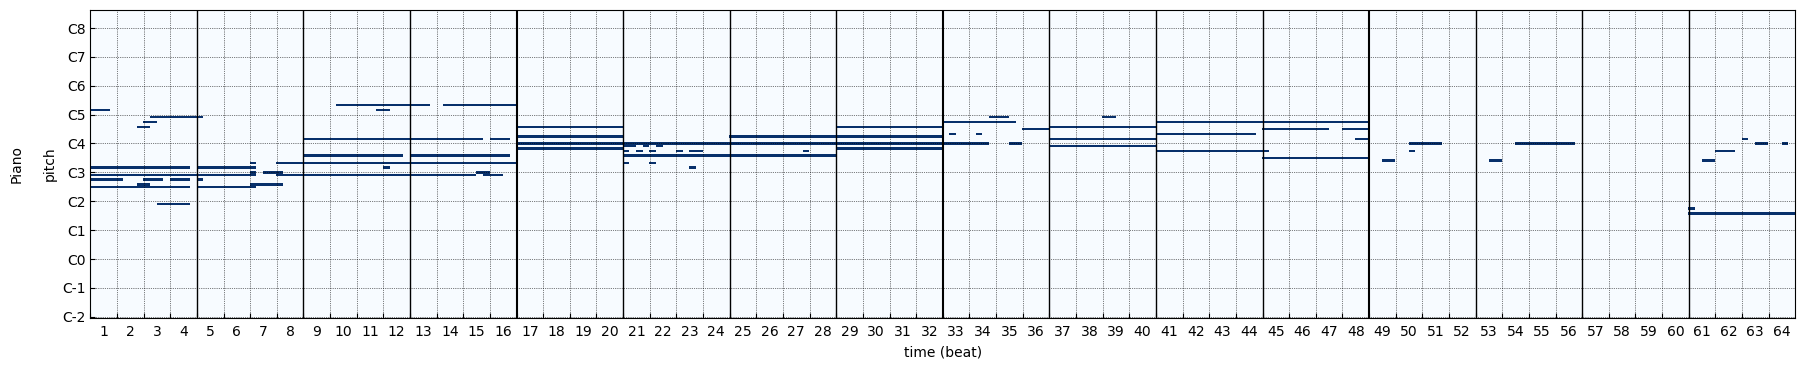

In [28]:
multitrack = build_multitrack(generated_image, 0.5)
show_multitrack(multitrack)

In [ ]:
### nell'ordine vanno info su:
### n_tracks, architecture, epochs, dataset, batch_size

In [29]:
# Saving multitrack to midi file

pypianoroll.write("generated music/GAN1paper50lpd64_8sps_cond_1_2.midi", multitrack)

In [30]:
# Saving network weights

torch.save(generator.state_dict(), "GAN weights/gen1paper50lpd64_8sps_cond_1_2.pt")

In [31]:
# Saving network weights

torch.save(discriminator.state_dict(), "GAN weights/disc1paper50lpd64_8sps_cond_1_2.pt")

## Training History

Step=0


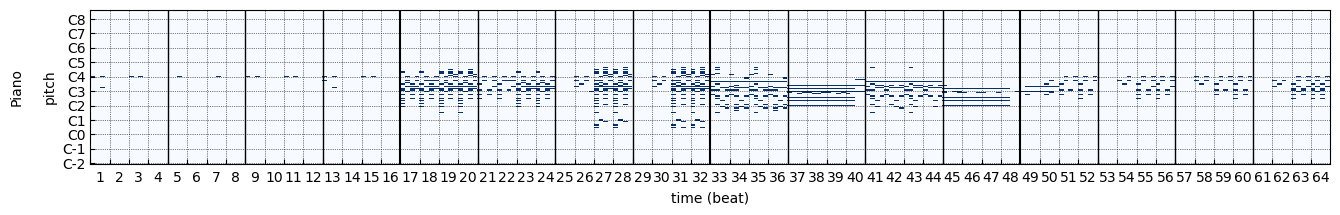

Step=1


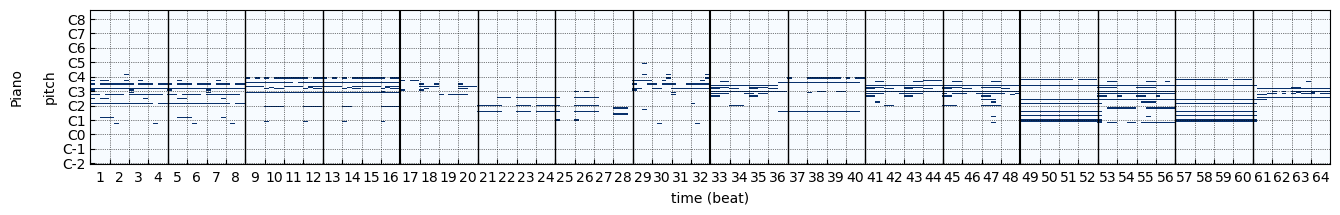

Step=2


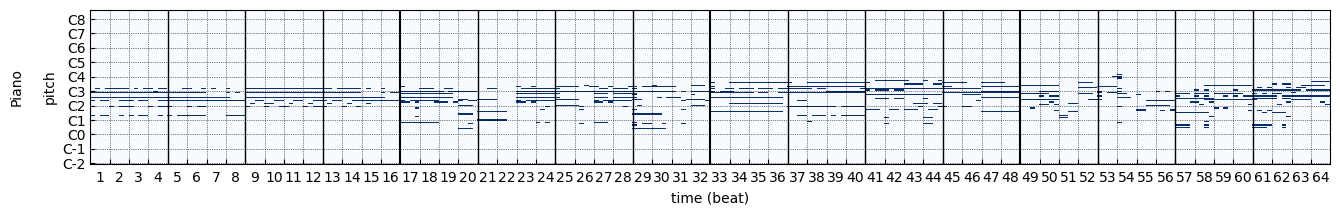

Step=3


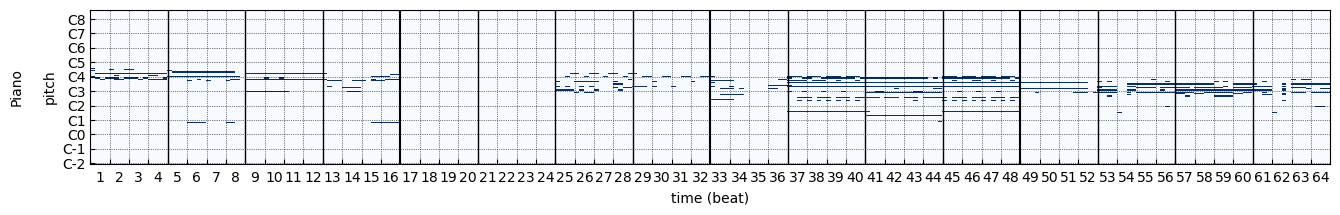

Step=4


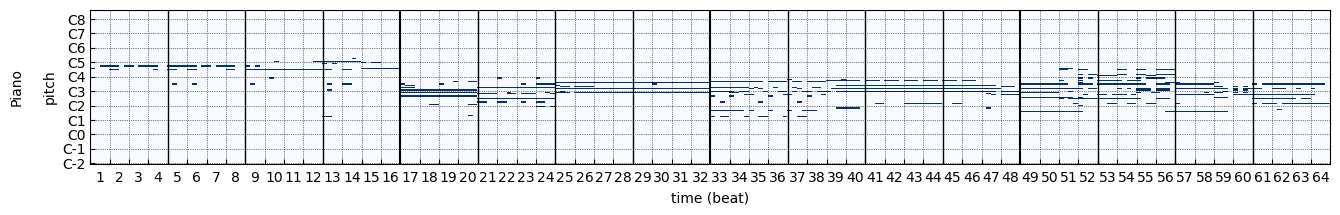

Step=5


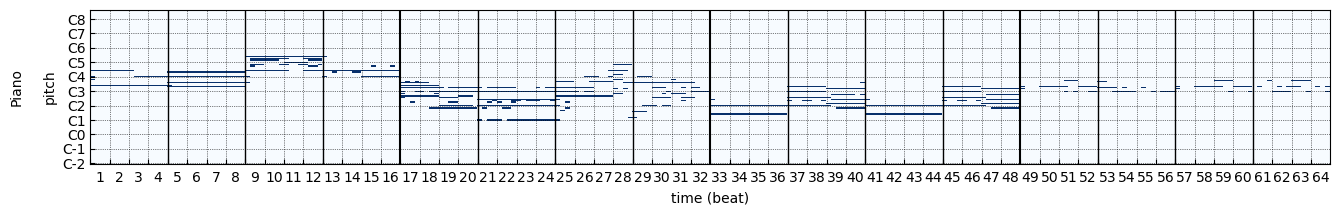

Step=6


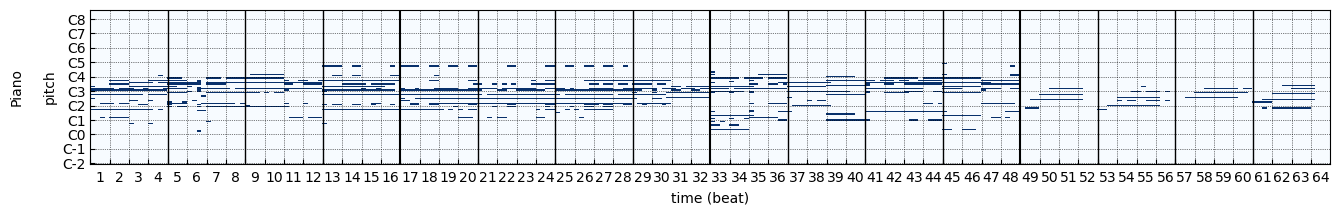

Step=7


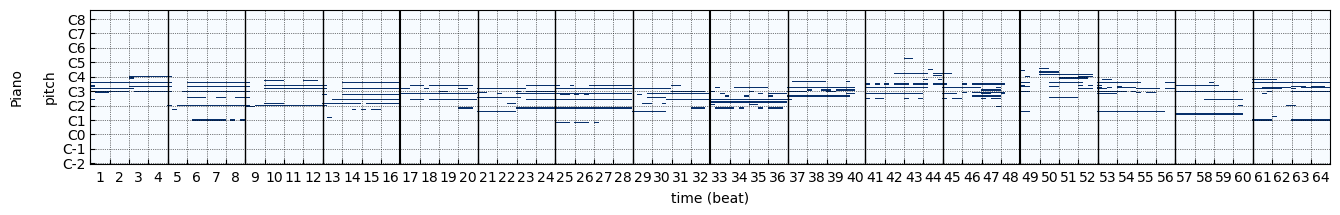

Step=8


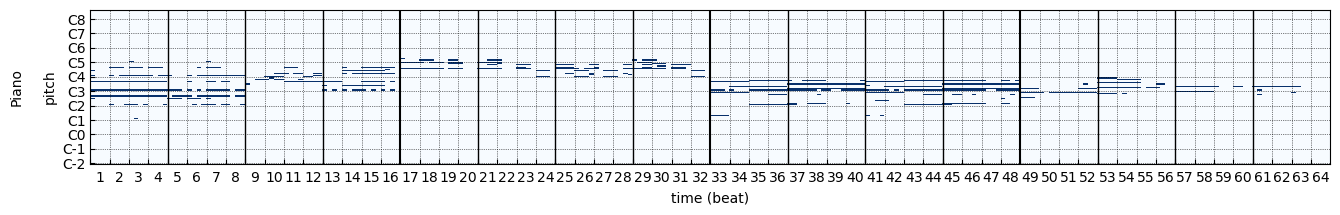

Step=9


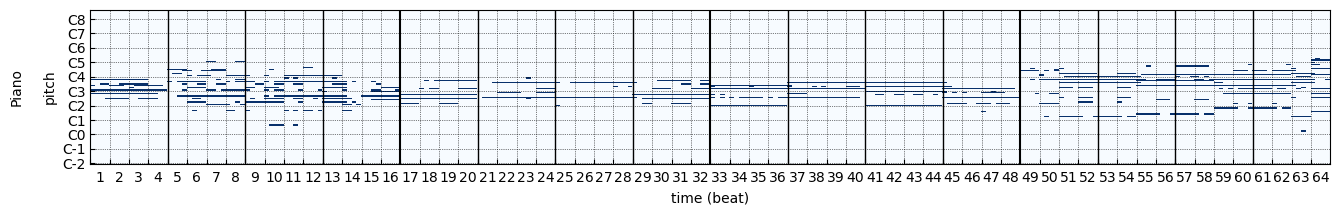

Step=10


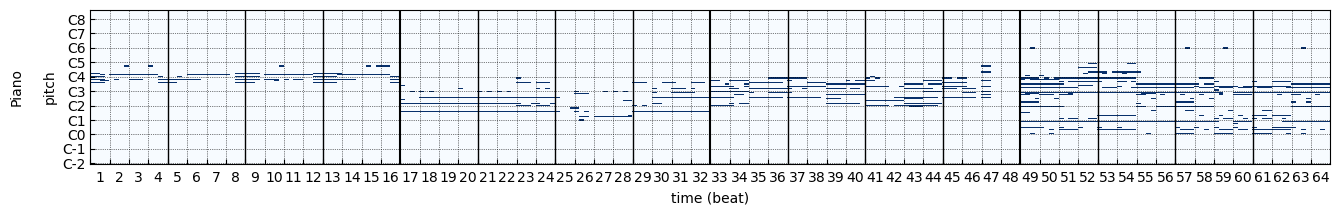

Step=11


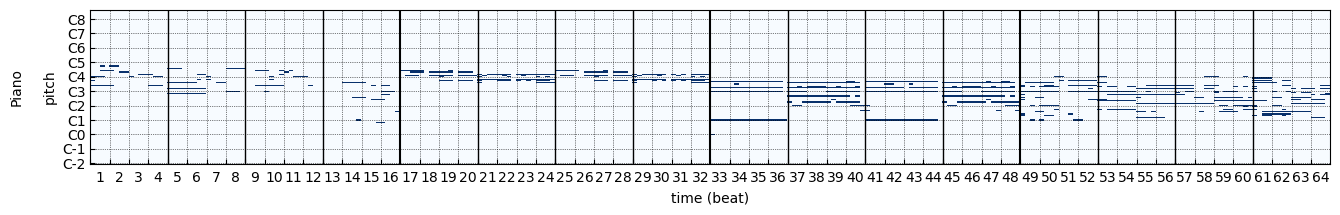

Step=12


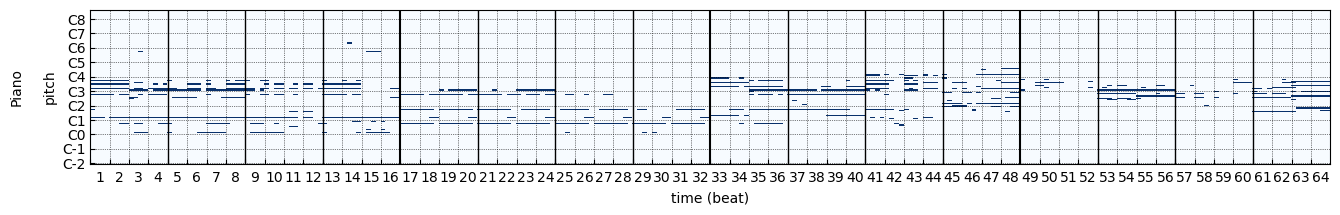

Step=13


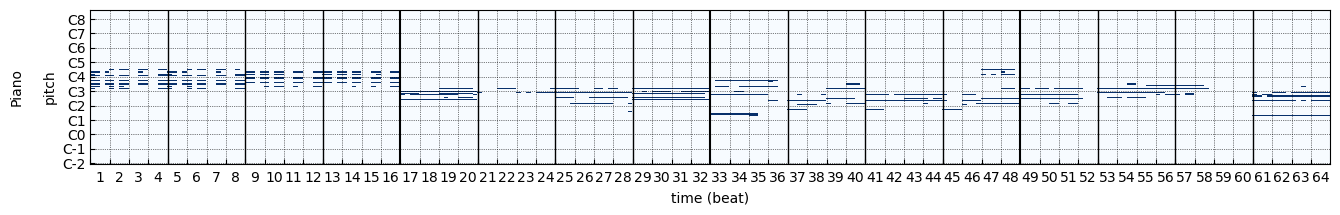

Step=14


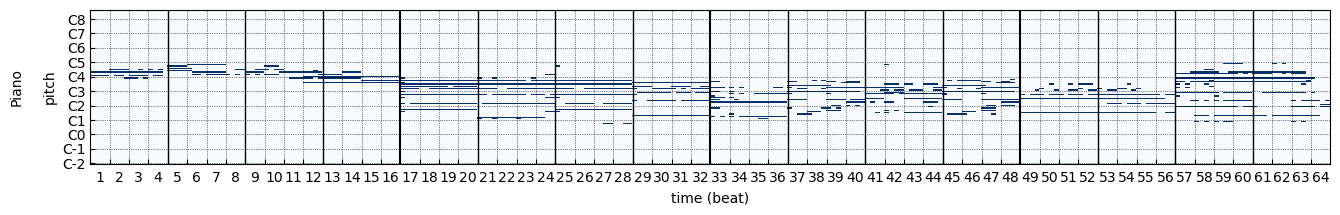

Step=15


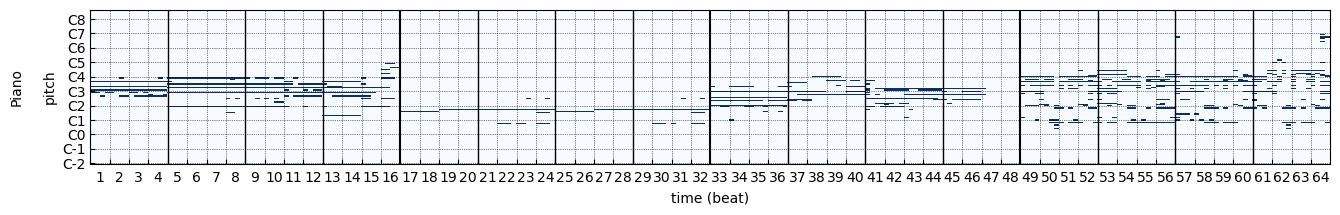

Step=16


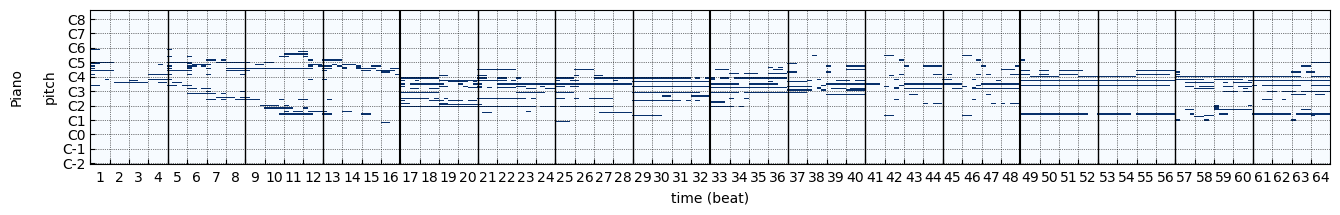

Step=17


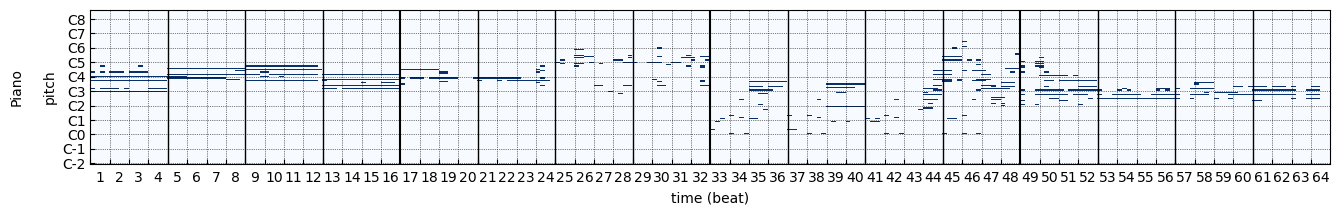

Step=18


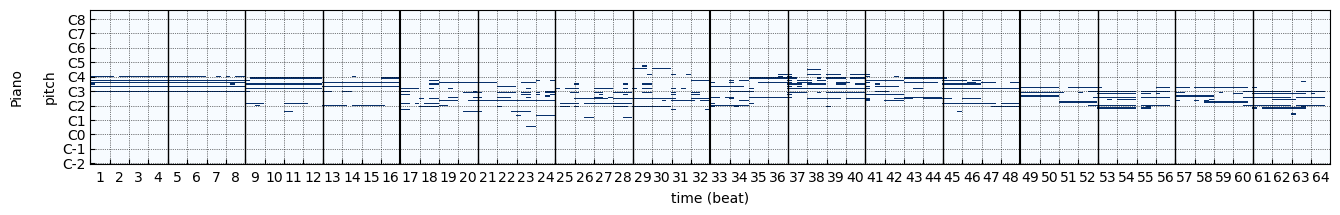

Step=19


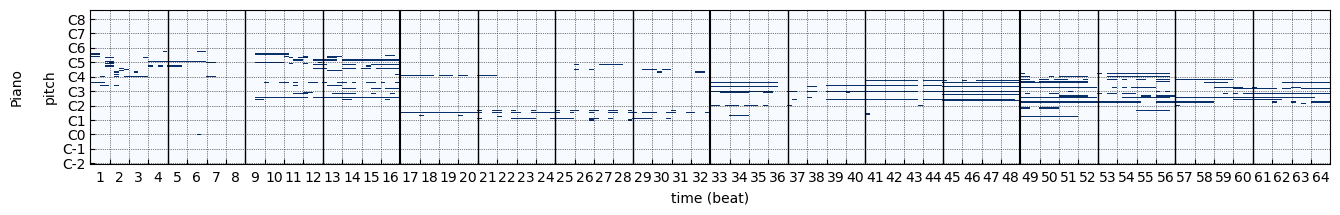

Step=20


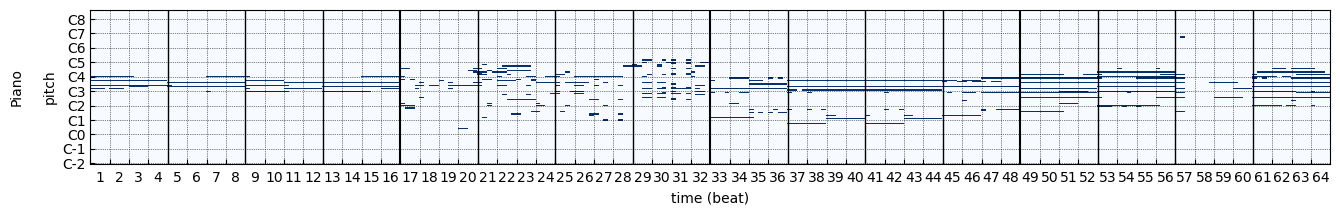

Step=21


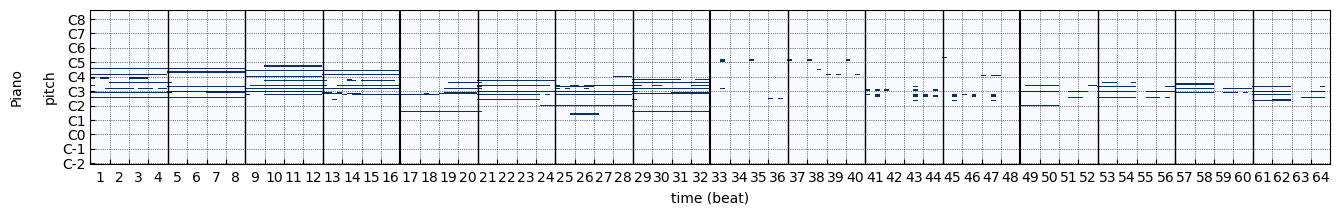

Step=22


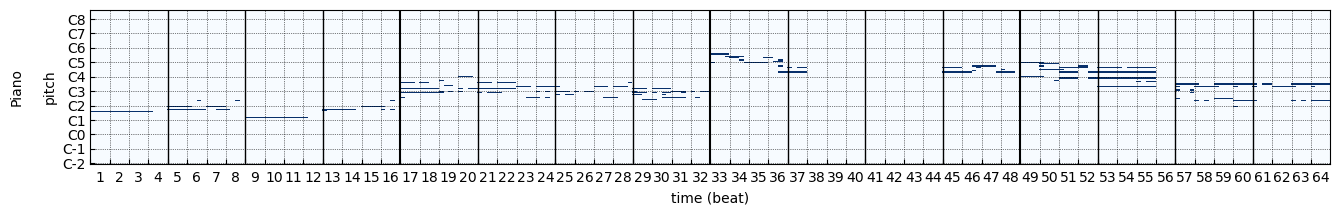

Step=23


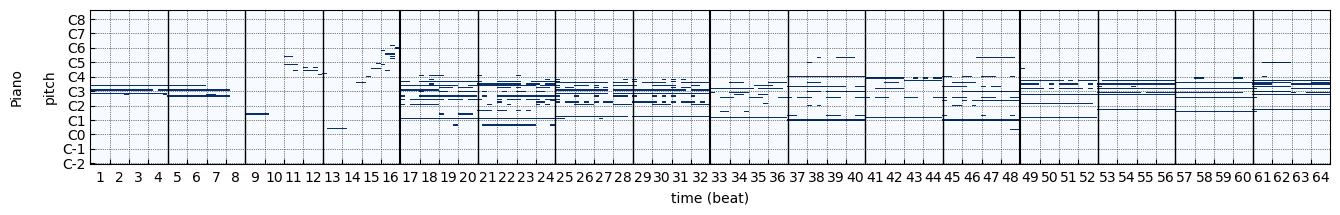

Step=24


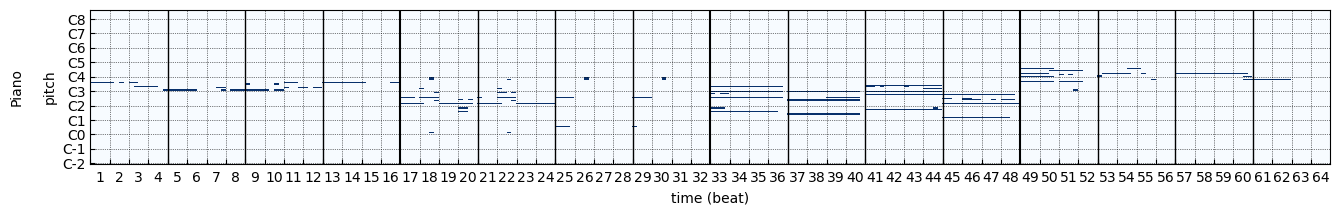

Step=25


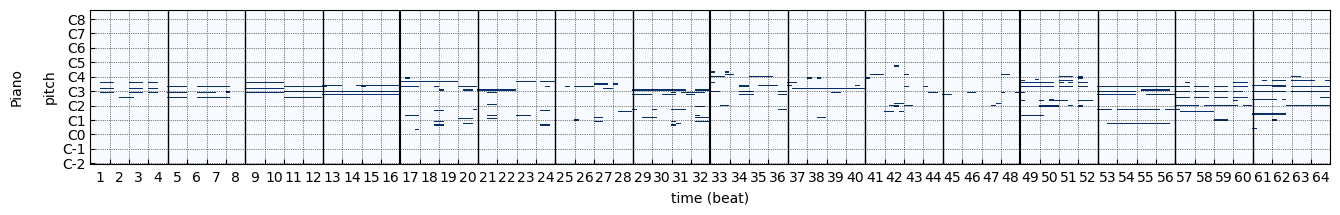

Step=26


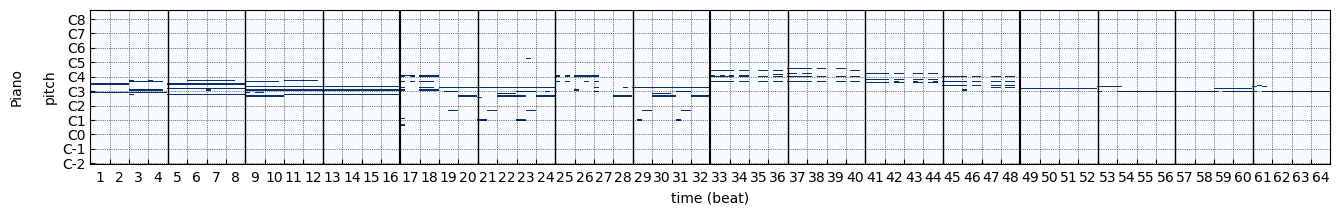

Step=27


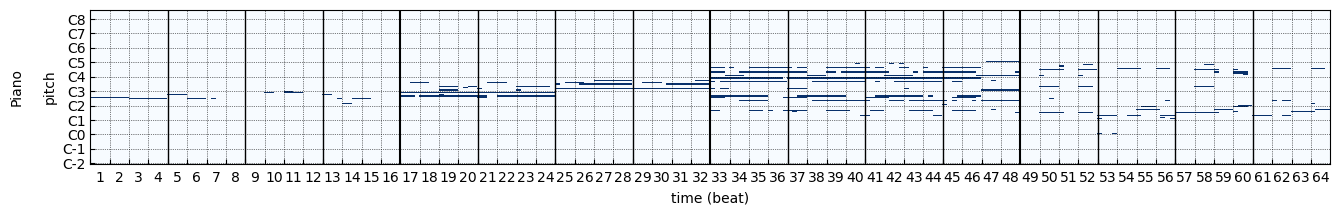

Step=28


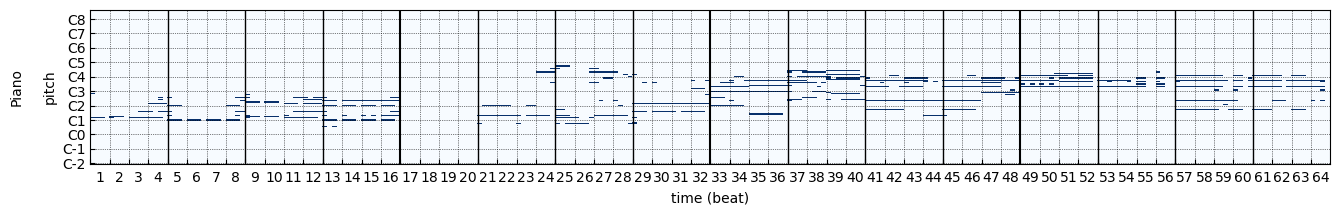

Step=29


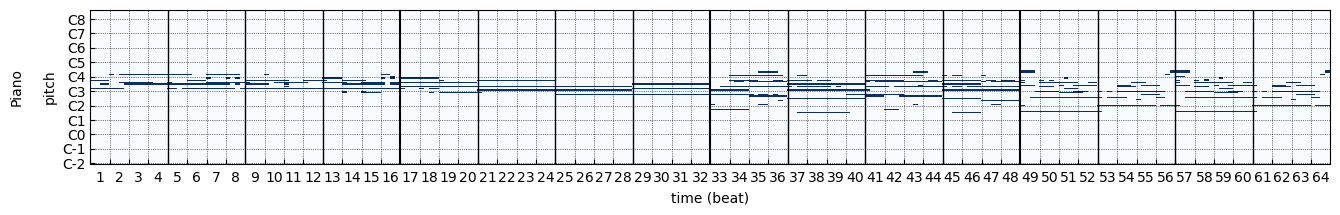

Step=30


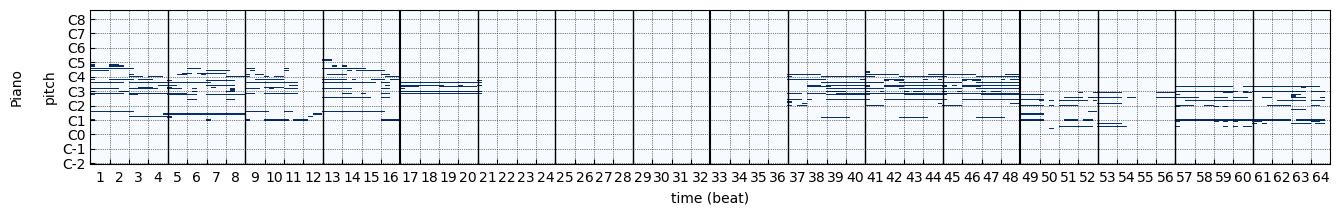

Step=31


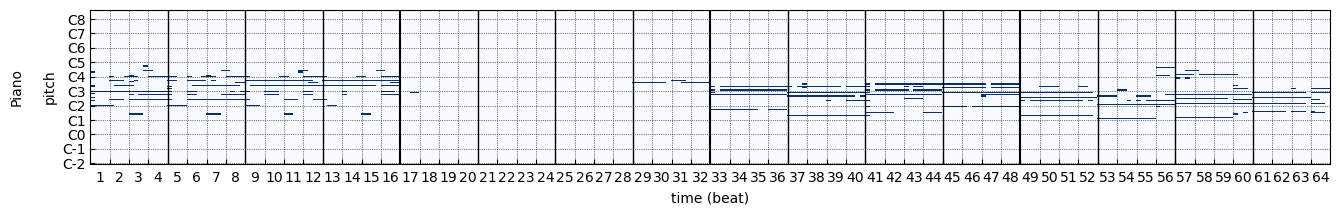

Step=32


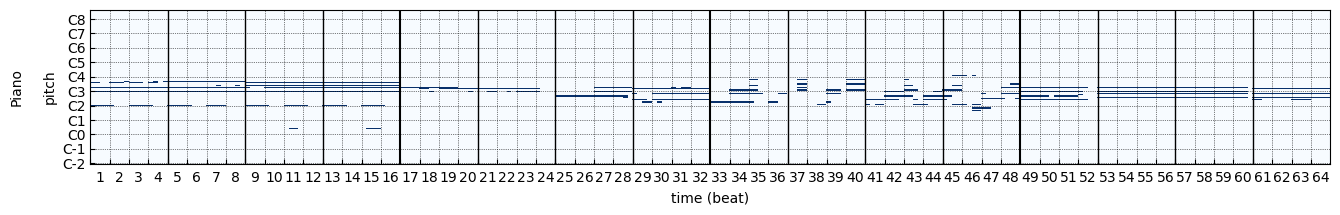

Step=33


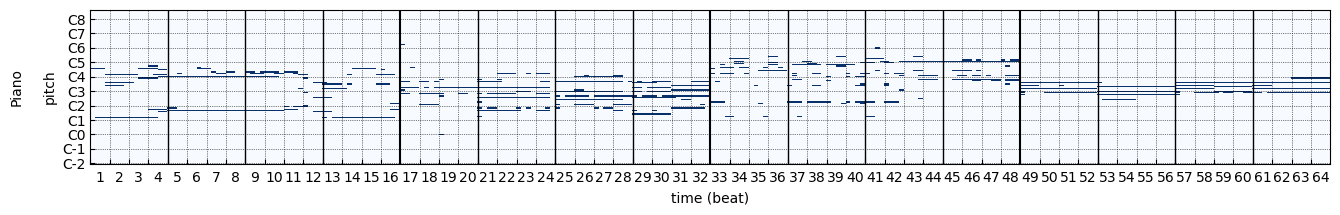

Step=34


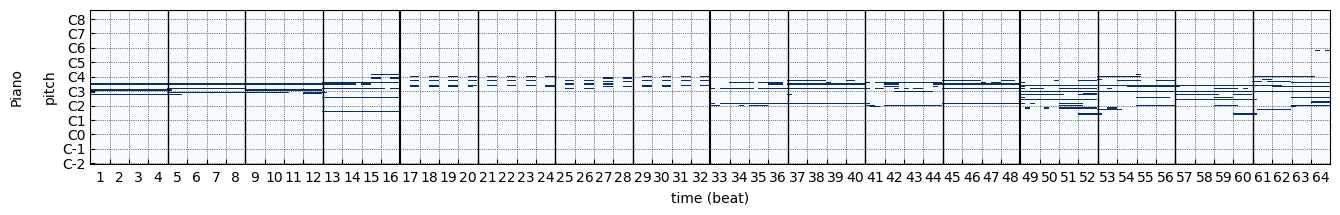

Step=35


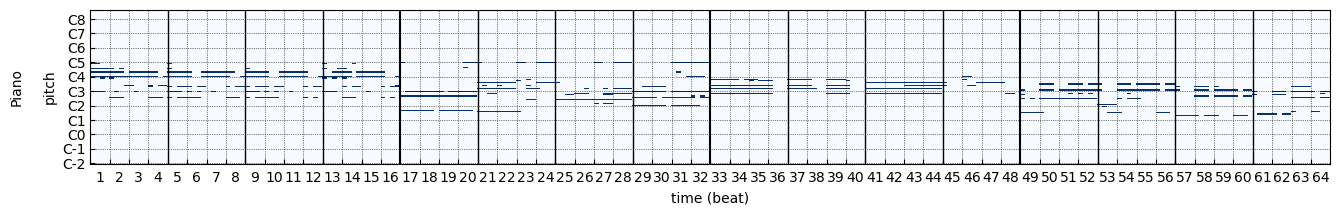

Step=36


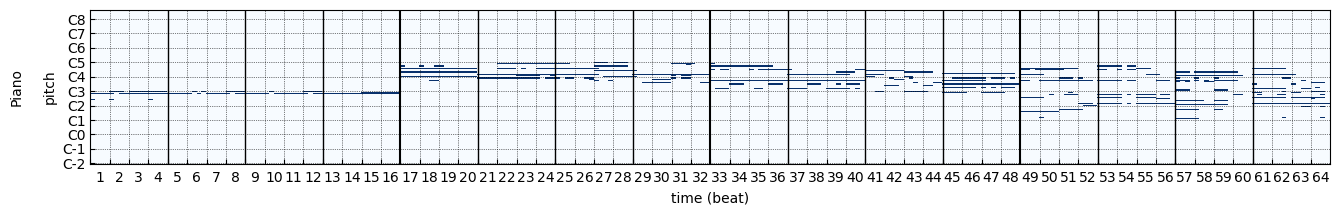

Step=37


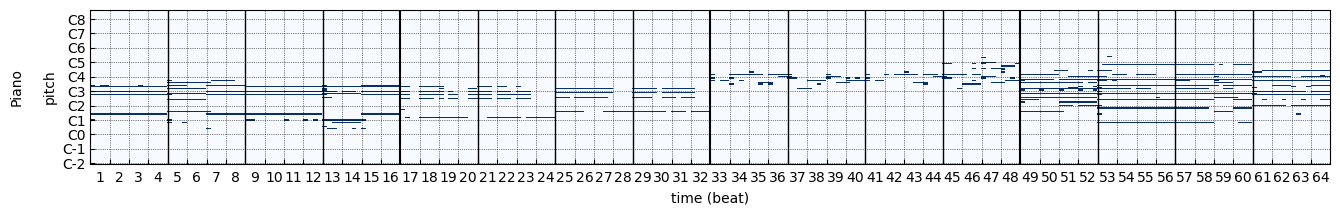

Step=38


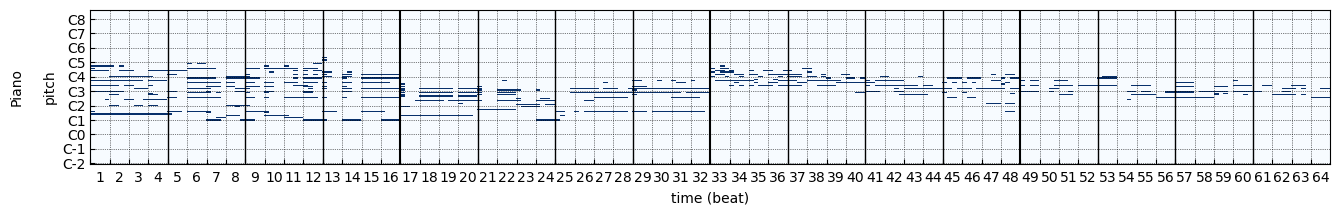

Step=39


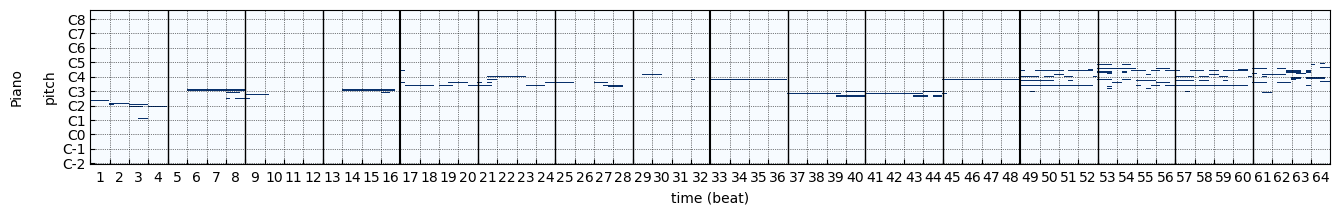

Step=40


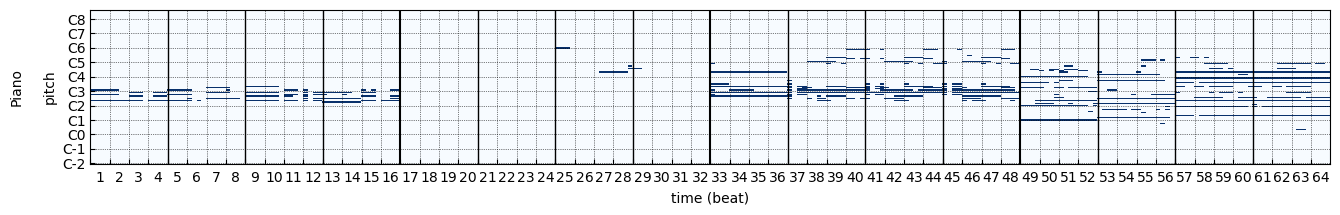

Step=41


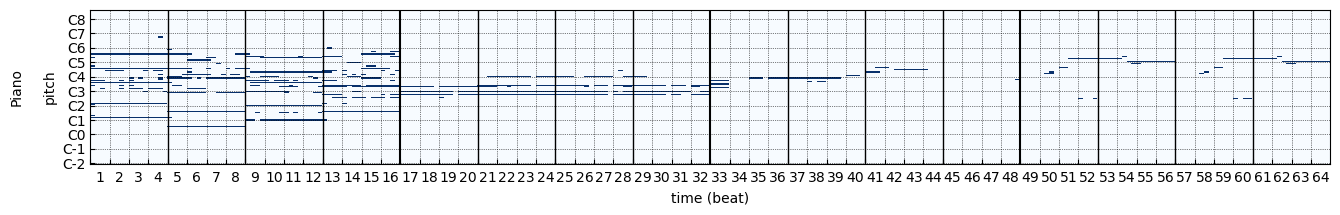

Step=42


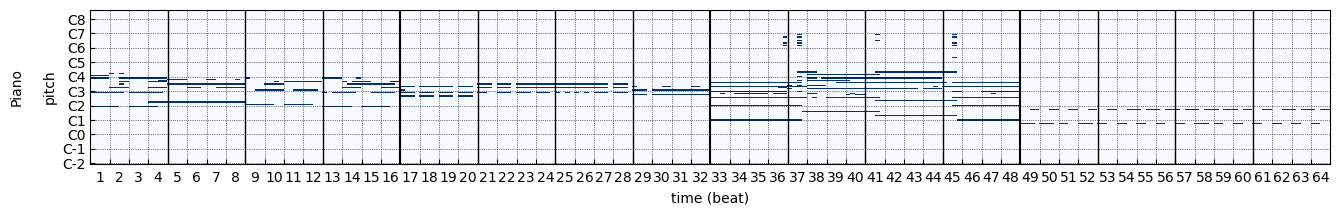

Step=43


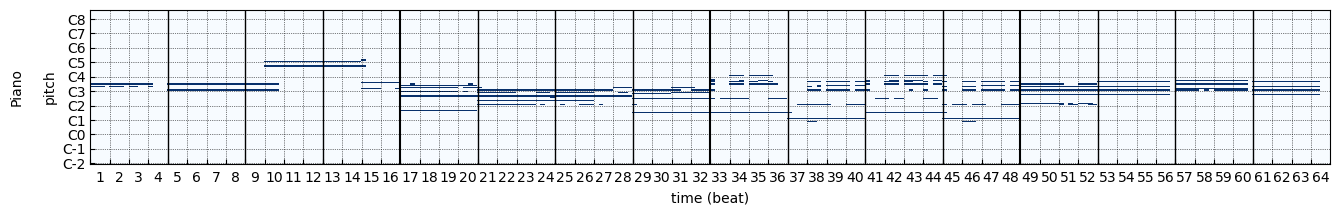

Step=44


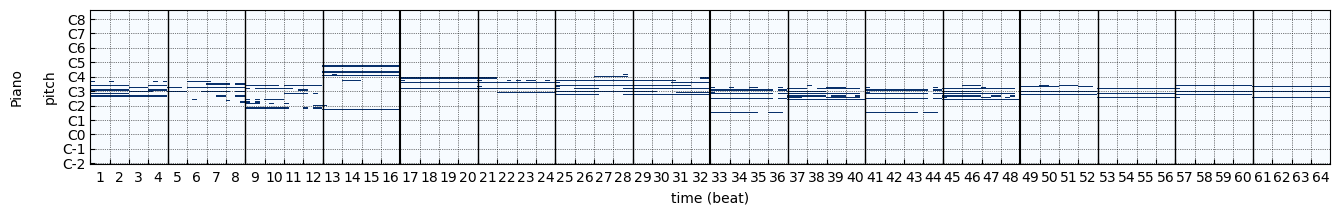

Step=45


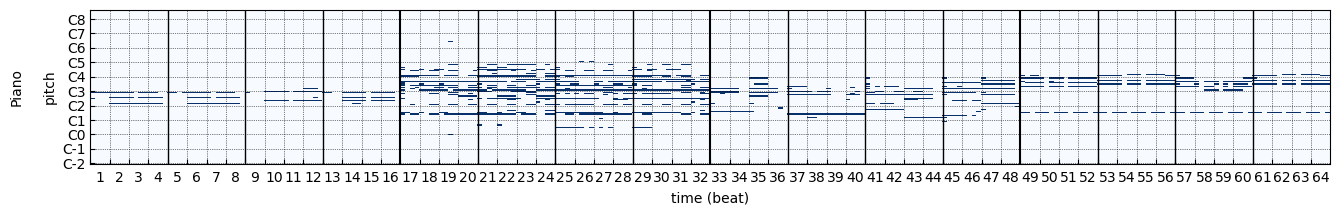

Step=46


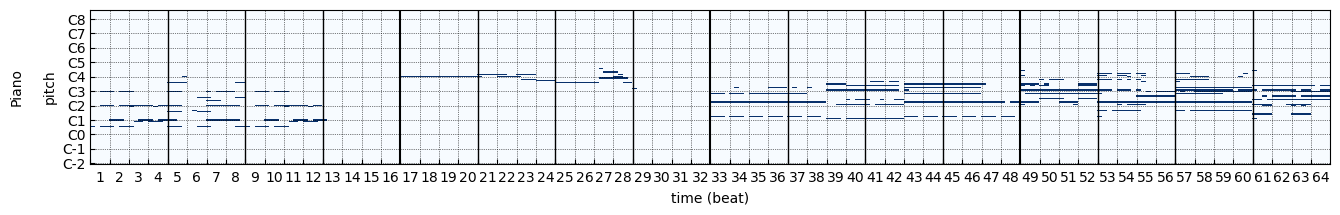

Step=47


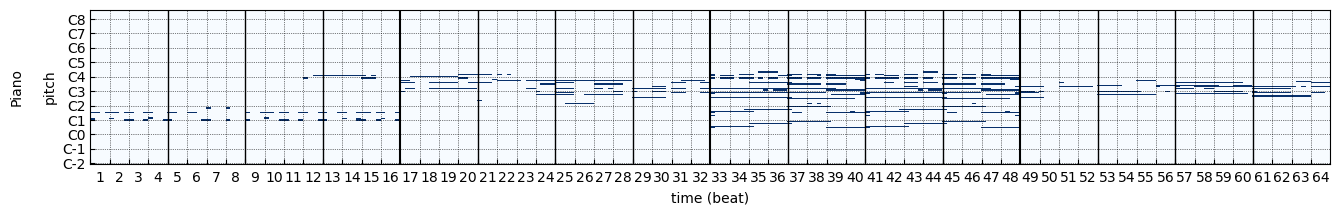

Step=48


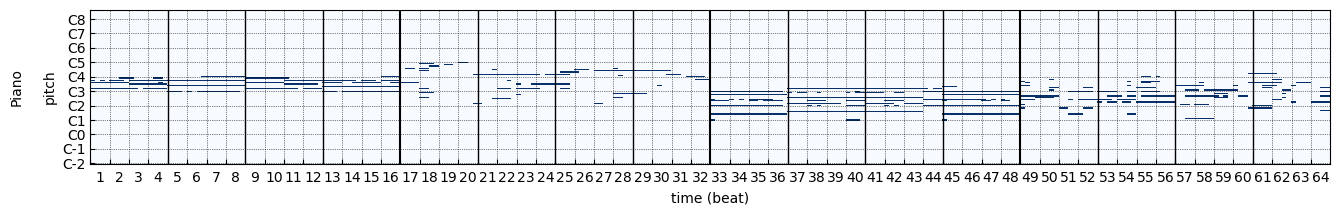

Step=49


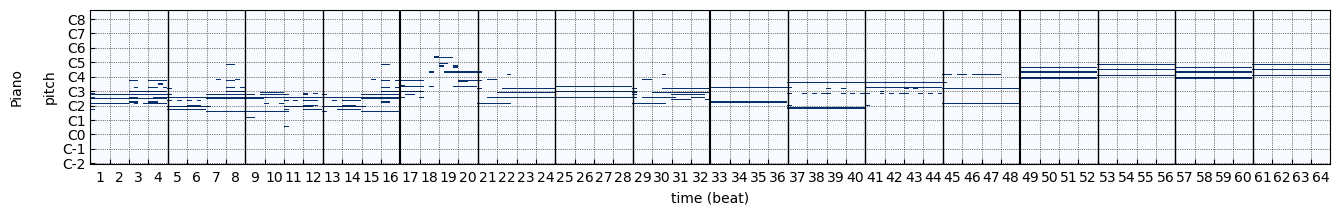

In [32]:
# Show history
steps = range(0, epochs, 1)
for step in steps:
    print(f"Step={step}")
    samples = history_samples[step].transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
    tracks = []
    for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
        pianoroll = np.pad(
            samples[idx] > 0.5,
            ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
        )
        tracks.append(
            Track(
                name=track_name,
                program=program,
                is_drum=is_drum,
                pianoroll=pianoroll,
            )
        )
    m = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
    axs = m.plot()
    for ax in axs:
        for x in range(
            bar_resolution,
            4 * bar_resolution * n_bars,
            bar_resolution
        ):
            if x % (bar_resolution * 4) == 0:
                ax.axvline(x - 0.5, color='k')
            else:
                ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.gcf().set_size_inches((16, 2*n_tracks))
    plt.show()

'''
multitrack = build_multitrack(history_samples[30].transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches), 0.5)
show_multitrack(multitrack)
'''

In [57]:
'''
pypianoroll.write("generated music/GAN4git50lnttur_2000amg.1.3.midi", multitrack)
'''

## Metrics

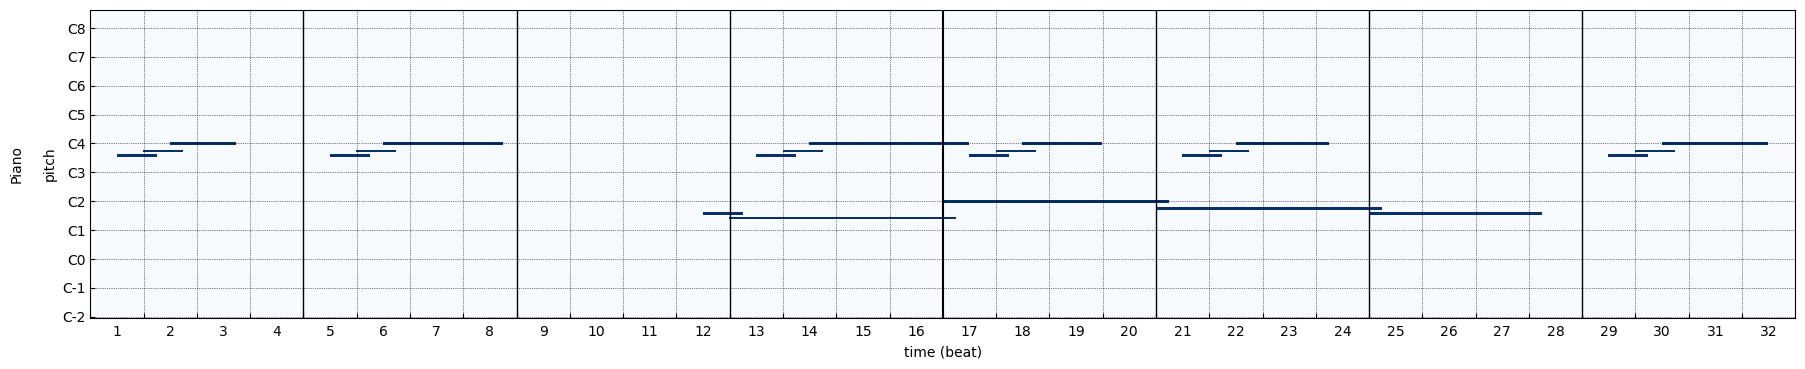

In [33]:
multitrack = build_multitrack(data[3])
show_multitrack(multitrack)

In [38]:
metrics_params = {
    'n tracks': n_tracks,
    'n pitches': n_pitches,
    'lowest pitch': lowest_pitch,
    'n samples per song': n_samples_per_song,
    'n measures': n_bars,
    'beat resolution': beat_resolution,
    'programs': programs,
    'is drums': is_drums,
    'track names': track_names,
    'tempo': tempo
}

In [39]:
data_shuffled = np.copy(data)
np.random.shuffle(data_shuffled)



non empty beat rate
 count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: 1, dtype: float64 
mode  1.0


non empty beat rate, only non empty tracks
 count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: 1, dtype: float64 
mode  1.0


pitches used
 count     3.0
mean     84.0
std       0.0
min      84.0
25%      84.0
50%      84.0
75%      84.0
max      84.0
Name: 2, dtype: float64 
mode  84


number of pitch classes used
 count     3.0
mean     12.0
std       0.0
min      12.0
25%      12.0
50%      12.0
75%      12.0
max      12.0
Name: 3, dtype: float64 
mode  12


number of pitch classes used, generated 
 count    95604.000000
mean         6.782572
std          1.830036
min          1.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         12.000000
Name: 3, dtype: float64 
mode  7


pitch range
 count     3.0
mean     83.0
std       0.0
min

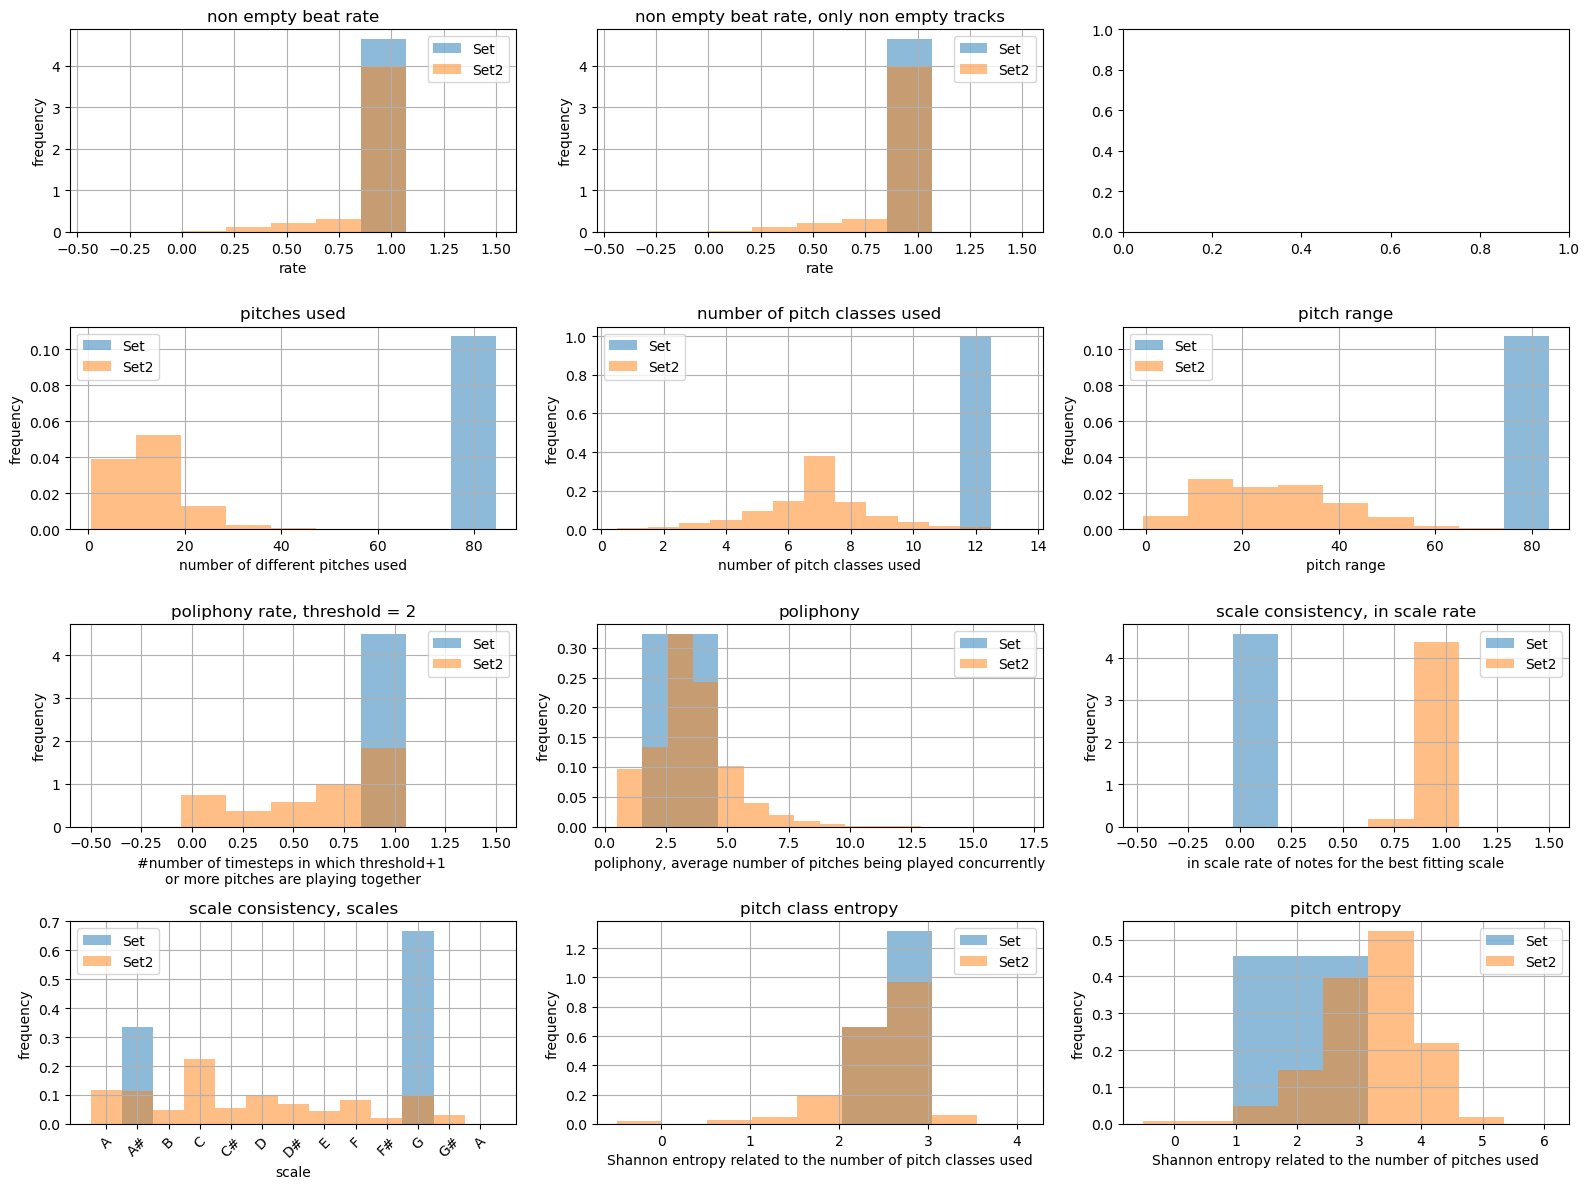

In [40]:
metrics.multitrack_metrics_plot(generated_image, metrics_params, data2 = data[:, 0])



non empty beat rate
 count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: 1, dtype: float64 
mode  1.0


non empty beat rate, only non empty tracks
 count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: 1, dtype: float64 
mode  1.0


pitches used
 count     3.0
mean     84.0
std       0.0
min      84.0
25%      84.0
50%      84.0
75%      84.0
max      84.0
Name: 2, dtype: float64 
mode  84


number of pitch classes used
 count     3.0
mean     12.0
std       0.0
min      12.0
25%      12.0
50%      12.0
75%      12.0
max      12.0
Name: 3, dtype: float64 
mode  12


pitch range
 count     3.0
mean     83.0
std       0.0
min      83.0
25%      83.0
50%      83.0
75%      83.0
max      83.0
Name: 5, dtype: float64 
mode  83


poliphony rate, threshold = 2
 count    3.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: 6, dtype:

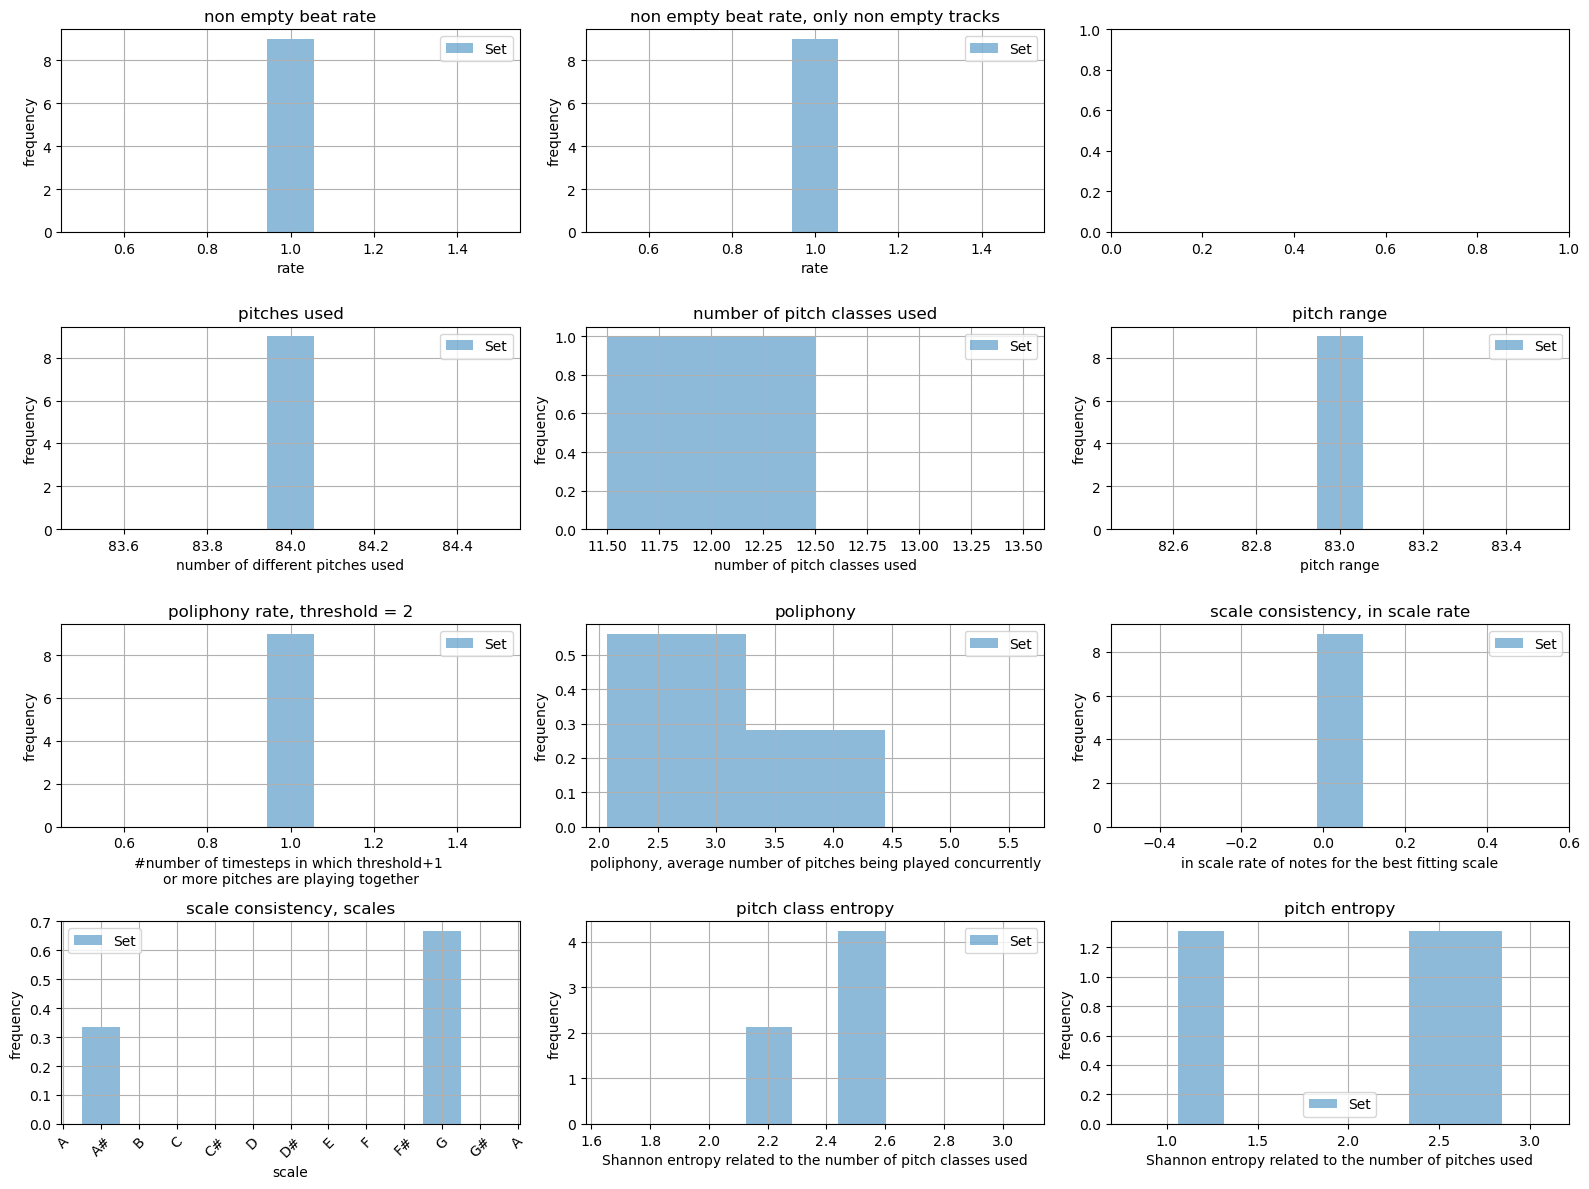

In [41]:
metrics.multitrack_metrics_plot(generated_image, metrics_params, diff=True, data_to_diff= data[:10000, 0])



non empty beat rate
 count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: 1, dtype: float64 
mode  1.0


non empty beat rate, only non empty tracks
 count    4.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: 1, dtype: float64 
mode  1.0


pitches used
 count     3.0
mean     84.0
std       0.0
min      84.0
25%      84.0
50%      84.0
75%      84.0
max      84.0
Name: 2, dtype: float64 
mode  84


number of pitch classes used
 count     3.0
mean     12.0
std       0.0
min      12.0
25%      12.0
50%      12.0
75%      12.0
max      12.0
Name: 3, dtype: float64 
mode  12


pitch range
 count     3.0
mean     83.0
std       0.0
min      83.0
25%      83.0
50%      83.0
75%      83.0
max      83.0
Name: 5, dtype: float64 
mode  83


poliphony rate, threshold = 2
 count    3.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: 6, dtype:

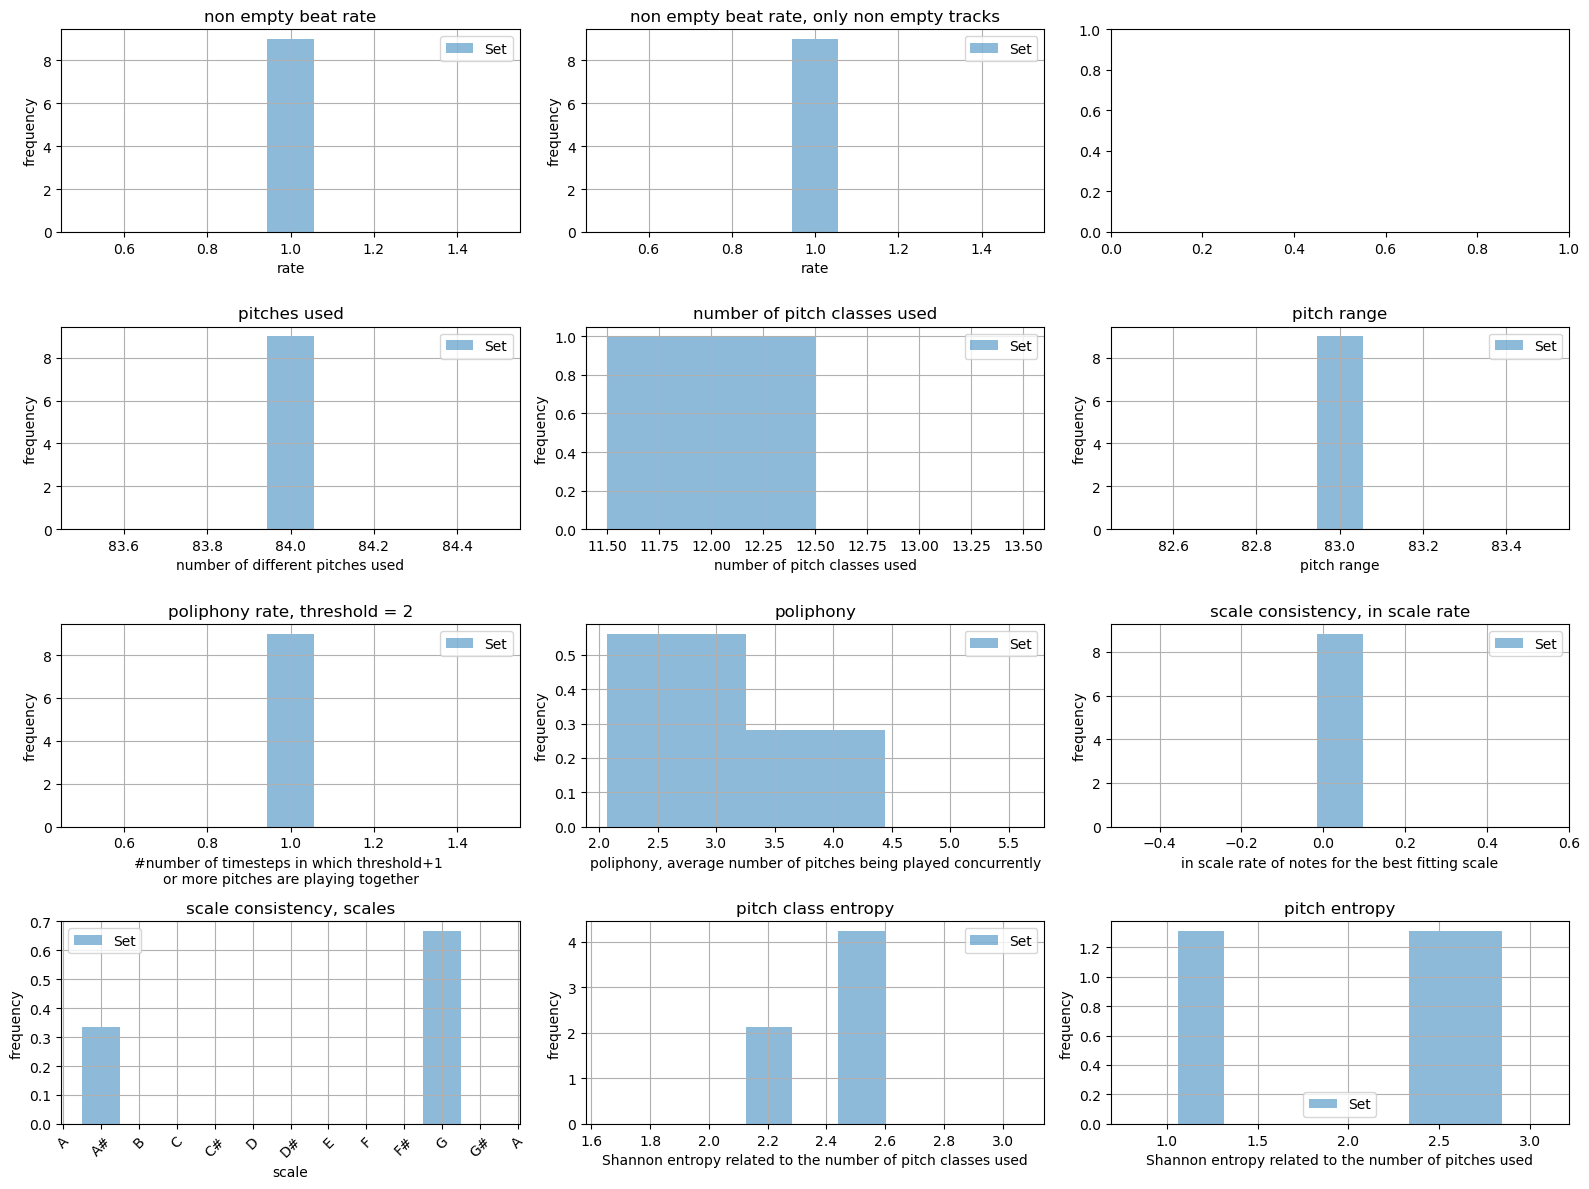

In [42]:
metrics.multitrack_metrics_plot(generated_image, metrics_params, diff=True, data_to_diff= data_shuffled[:10000, 0])

## Superimposed plots

In [43]:
df_diff_ii = metrics.create_list_dfs(generated_image, metrics_params, wght=False, diff=True, data2=data[:10000, 0])
df_diff_ij = metrics.create_list_dfs(generated_image, metrics_params, wght=False, diff=True, data2=data_shuffled[:10000, 0])

KeyError: 'Drums'

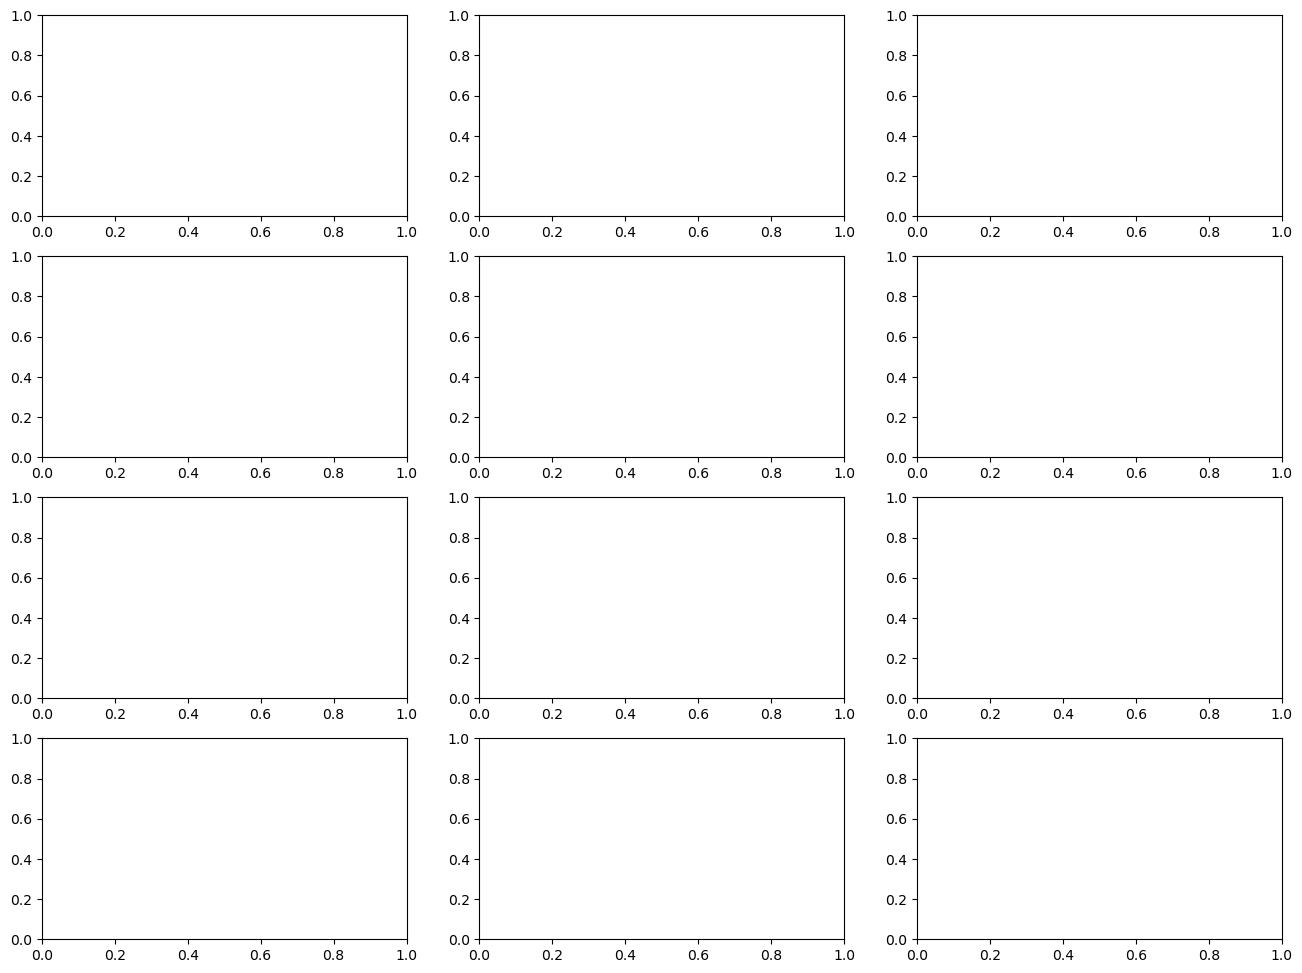

In [47]:
metrics.superimposed_metrics_plot(df_diff_ii, metrics_params, df_diff_ij)

In [45]:
#metrics.multitrack_metrics_all(data[3], beat_resolution, [programs, is_drums, track_names], n_pitches)

In [46]:
#metrics.multitrack_metrics_plot(data, beat_resolution, [programs, is_drums, track_names], n_pitches)